In [1]:
import pandas as pd
import os
from os import listdir
from os.path import join
import pickle
from tqdm import tqdm
import shutil
import time
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
import numpy as np
# import matplotlib.backends.backend_pdf

### Let's see the distribution of expressed and non-expressed gene p-val

In [90]:
#Construct dataframe for nonexp and exp genes
dir_org = '../org_cov_maf'

out_dir_nonexp_05 = '../p-val_adjust/nonexp_org_cov_maf/org_cov_maf_5'

df_nonexp_gene = pd.DataFrame()
df_exp_gene = pd.DataFrame()
col_name = []
for organ in listdir(dir_org):
    list_organ = []
    if not organ.startswith('.') and not organ == 'SoftTissue':
        col_name.append(organ)
        files_05 = [f for f in listdir(join(out_dir_nonexp_05,organ)) if f.endswith('.txt')][0]
        df_cov_05 = pd.read_csv(join(out_dir_nonexp_05,organ,files_05), sep = '\t')
        ne_gene = df_cov_05['gene'].unique()
        
        files_all = [f for f in listdir(join(dir_org,organ)) if f.endswith('102120.txt')][0]
        df_cov_all = pd.read_csv(join(dir_org,organ,files_all), sep = '\t')
        all_gene = df_cov_all['gene'].unique()
        exp_gene = [gene for gene in all_gene if gene not in ne_gene]
        
        df_ne = pd.DataFrame({organ:ne_gene})
        df_nonexp_gene = pd.concat([df_nonexp_gene,df_ne],ignore_index=True, axis=1)
        df_nonexp_gene.columns = col_name
        
        df_exp = pd.DataFrame({organ:exp_gene})
        df_exp_gene = pd.concat([df_exp_gene,df_exp], names = col_name,ignore_index=True, axis=1)
        df_exp_gene.columns = col_name

In [4]:
pickle.dump(df_nonexp_gene,open('df_nonexp_gene','wb'))
pickle.dump(df_exp_gene,open('df_exp_gene','wb'))

NameError: name 'df_nonexp_gene' is not defined

In [2]:
with open('df_exp_gene', 'rb') as handle:
    df_exp_gene = pickle.load(handle)
with open('df_nonexp_gene', 'rb') as handle:
    df_nonexp_gene = pickle.load(handle)

In [3]:
df_nonexp_gene

,Ovary,Thy,Biliary,Breast,Panc,Lung,Liver,CNS,Lymph,Bone,...,ColoRect,Kidney,Myeloid,Stomach,Prost,Skin,Head,Uterus,Cervix,Bladder
0,RNF17,C16orf11,C16orf11,RNF17,RNF17,C16orf11,ZNF709,RNF17,REM1,RNF17,...,RNF17,RNF17,REM1,RNF17,RNF17,RNF17,RNF17,RNF17,C16orf11,RNF17
1,ZNF709,ZNF709,ZNF709,C16orf11,REM2,ZNF709,CTRL,C16orf11,C16orf11,C16orf11,...,C16orf11,DUOXA2,C16orf11,C16orf11,REM2,C16orf11,C16orf11,ZNF709,NDP,C16orf11
2,SP9,RNF112,SP9,DUOXA2,ZNF709,CTRL,FAM90A26,DUOXA2,DUOXA2,ZNF709,...,ZNF709,ZNF709,DUOXA2,ZNF709,ZNF709,DUOXA2,ZNF709,CTRL,ZNF709,ZNF709
3,FAM90A26,SP9,SYNGR4,ZNF709,SP9,FAM90A26,FTMT,ZNF709,NDP,CTRL,...,HMGCLL1,SP9,NDP,HMGCLL1,SP9,ZNF709,HMGCLL1,FAM90A26,RNF112,CTRL
4,FTMT,CTRL,CTRL,CTRL,FAM90A26,FTMT,TMOD4,EDARADD,ASS1,FAM90A26,...,CTRL,SYNGR4,ASS1,IQCA1,SYNGR4,HMGCLL1,CTRL,FTMT,HMGCLL1,FAM90A26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6691,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HEPH,NaN,...,NaN,NaN,HEPH,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6692,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DACH2,NaN,...,NaN,NaN,DACH2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6693,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CEA,NaN,...,NaN,NaN,CEA,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6694,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PLEKHG5,NaN,...,NaN,NaN,PLEKHG5,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Find common nonexp genes and exp genes
cols = df_nonexp_gene.columns

for i in range(0, len(cols)-1):
    if i == 0:
        lne = set(df_nonexp_gene[cols[i]]).intersection(set(df_nonexp_gene[cols[i+1]]))
        le = set(df_exp_gene[cols[i]]).intersection(set(df_exp_gene[cols[i+1]]))
    else:
        lne = set(lne).intersection(set(df_nonexp_gene[cols[i+1]]))
        le = set(le).intersection(set(df_exp_gene[cols[i+1]]))

In [75]:
### Plot boxplot in one plot
### Then map the p-vals in the sig gene files for common exp and nonexp genes
syn_dir = '../mutsig_out/syn/out10212020'


df_exp = pd.DataFrame(); df_ne = pd.DataFrame();col_name = []
for org in listdir(syn_dir):
    if not org.startswith('.') and not org == 'SoftTissue':
        col_name.append(org)
        org_dir = join(syn_dir,org)
        for f in listdir(org_dir):
            if f.endswith('sig_genes.txt'):
                f_dir = join(org_dir,f)
                df_org = pd.read_csv(f_dir,sep = '\t')
                df_org.loc[df_org['p']==0, 'p'] = 1e-30
                df_org = df_org[df_org['p']<1]
                
#                 df_exp_p = -np.log10(df_org[df_org['gene'].isin(le)]['p'])
#                 df_exp_p = df_exp_p.to_frame().reset_index(drop = True)
#                 df_nonexp_p = -np.log10(df_org[df_org['gene'].isin(lne)]['p'])
#                 df_nonexp_p = df_nonexp_p.to_frame().reset_index(drop = True)
                df_exp_p = -np.log10(df_org[df_org['gene'].isin(df_exp_gene[org])]['p'])
                df_exp_p = df_exp_p.to_frame().reset_index(drop = True)
                df_nonexp_p = -np.log10(df_org[df_org['gene'].isin(df_nonexp_gene[org])]['p'])
                df_nonexp_p = df_nonexp_p.to_frame().reset_index(drop = True)
                
                df_exp = pd.concat([df_exp,df_exp_p],ignore_index=True, axis=1)
                df_ne = pd.concat([df_ne, df_nonexp_p],ignore_index = True, axis = 1)
                
                df_exp.columns = col_name;df_ne.columns = col_name

In [76]:
df_exp['exp/nonexp'] = 'Exp'
df_ne['exp/nonexp'] = 'Non-exp'

df_all = pd.concat([df_exp,df_ne], ignore_index = True)

In [73]:
pdf = matplotlib.backends.backend_pdf.PdfPages("common_pval<1.pdf")

/opt/aci/sw/anaconda3/2020.07_gcc-4.8.5-khh/lib/python3.8/site-packages/pandas/plotting/_matplotlib/boxplot.py:364: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  ax = boxplot(
/opt/aci/sw/anaconda3/2020.07_gcc-4.8.5-khh/lib/python3.8/site-packages/pandas/plotting/_matplotlib/boxplot.py:364: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  ax = boxplot(


Text(0.5, 0.95, 'Tumor specific exp/nonexp pval<1 distribution')

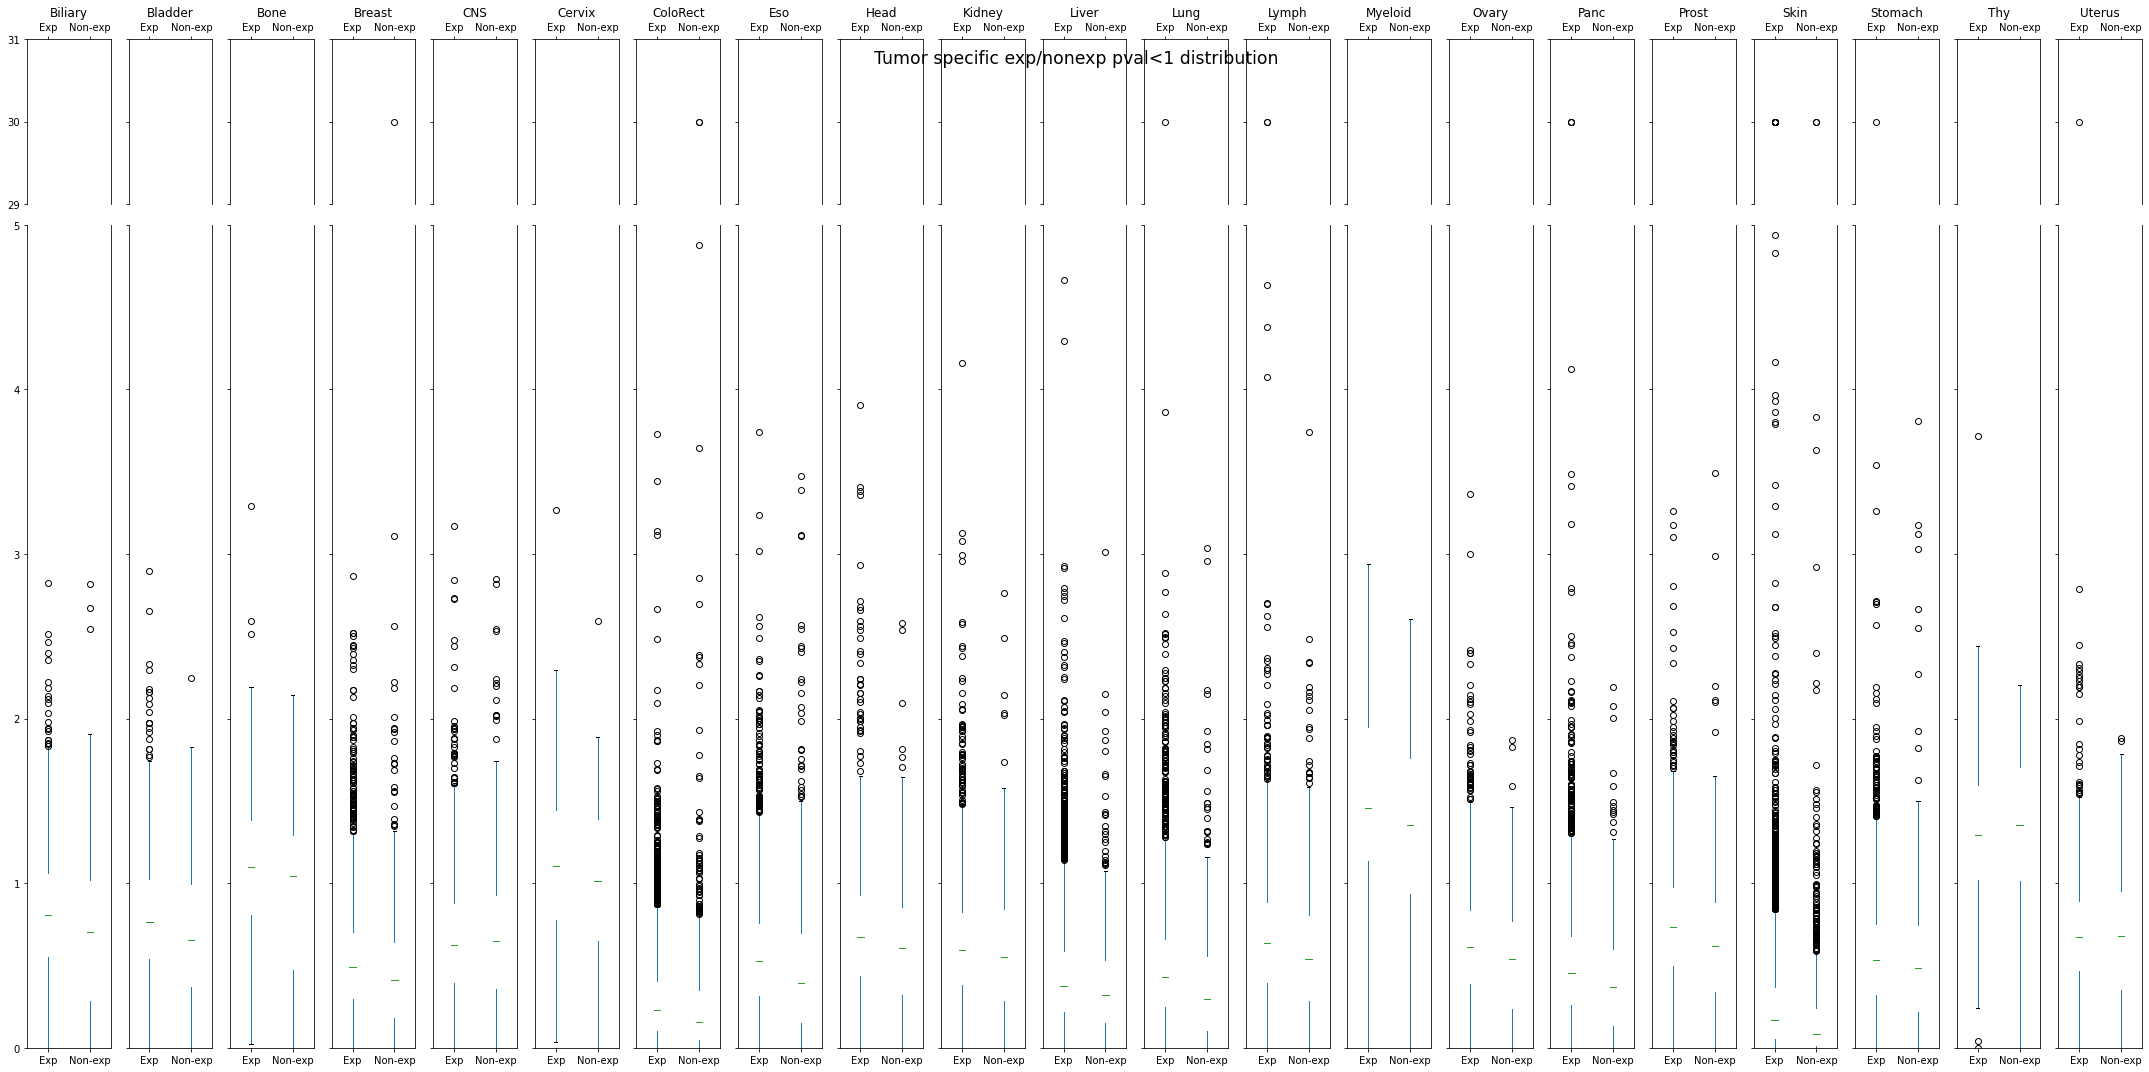

In [79]:

fig, axs = plt.subplots(nrows=2, ncols=21,figsize=(30,15),gridspec_kw={'height_ratios': [1, 5]})

axes = df_all.boxplot(by='exp/nonexp', grid = False, return_type='axes',ax = axs[0,:])
n=-1
for ax in axes.values:
    ax.set_ylim(29, 31)
    ax.spines['bottom'].set_visible(False)
    ax.xaxis.tick_top()
    ax.tick_params(labelbottom=False)
    ax.set_xlabel('')
    ax.set_yticks([29,30,31])
    n+=1
    if n > 0:
        ax.set_ylabel('')
        ax.set_yticklabels('')

axes1 = df_all.boxplot(by='exp/nonexp',grid = False,showbox = False, return_type='axes', ax = axs[1,:])
n = -1
for ax in axes1.values:
    ax.set_ylim(0,5)
    ax.spines['top'].set_visible(False)
    ax.xaxis.tick_bottom()
    ax.tick_params(labeltop=False)
    ax.set_title('')
    ax.set_xlabel('')
    n+=1
    if n >0:
        ax.set_ylabel('')
        ax.set_yticklabels('')
plt.tight_layout()
fig.suptitle('Tumor specific exp/nonexp pval<1 distribution', x=0.5, y=0.95, fontsize='xx-large')


# pdf.savefig(fig)

In [78]:
pdf.close()

<ipython-input-119-9d4b35622865>:33: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrows=1, ncols=4,figsize=(18,10))
<ipython-input-119-9d4b35622865>:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrows=1, ncols=4,figsize=(18,10))
<ipython-input-119-9d4b35622865>:33: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see

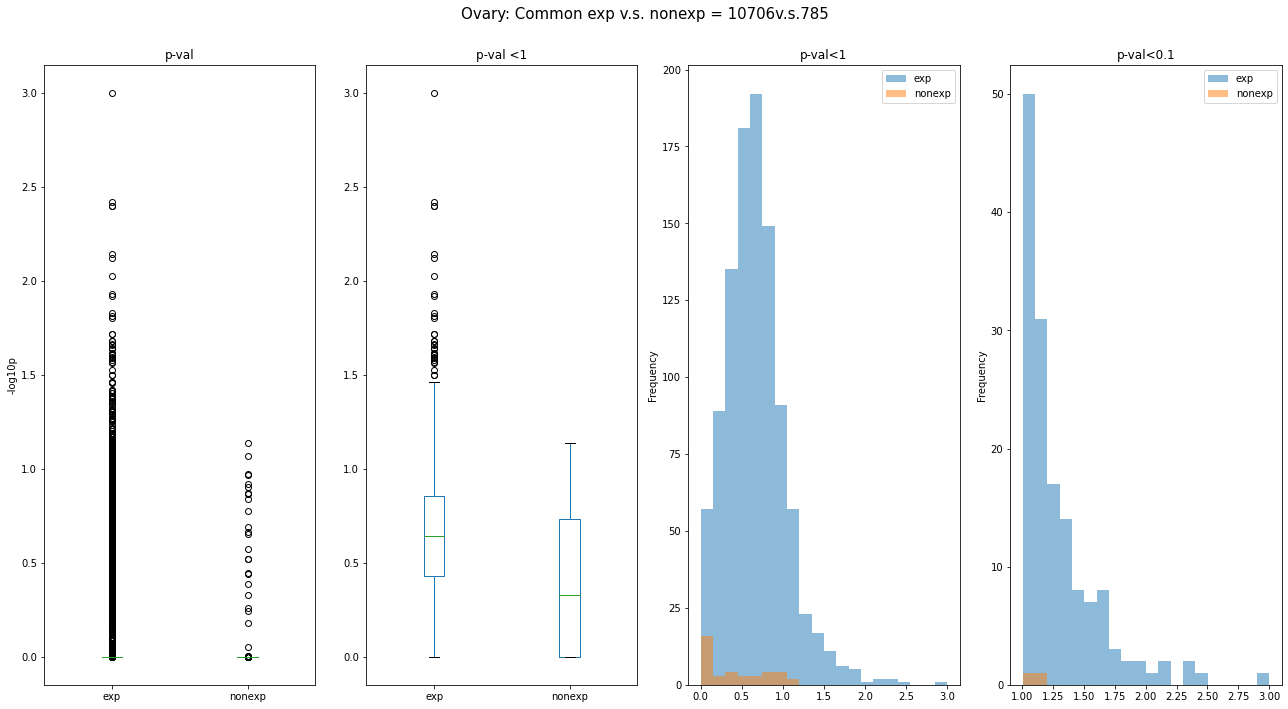

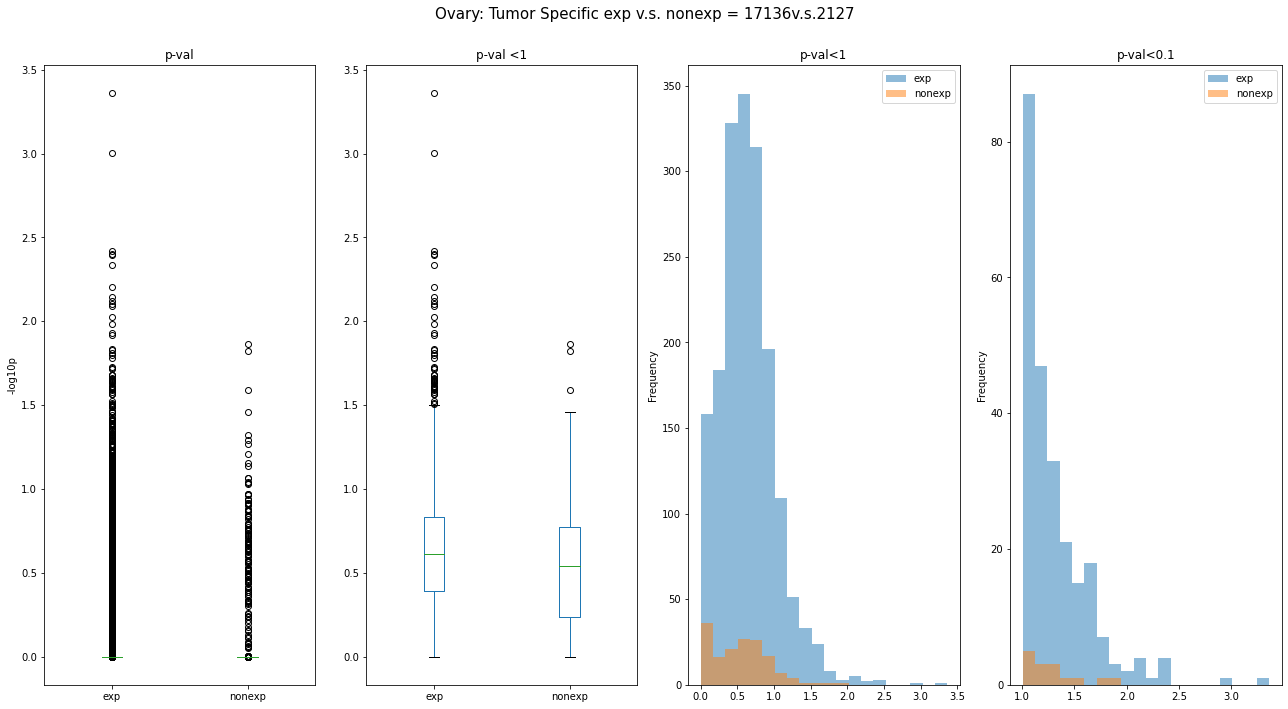

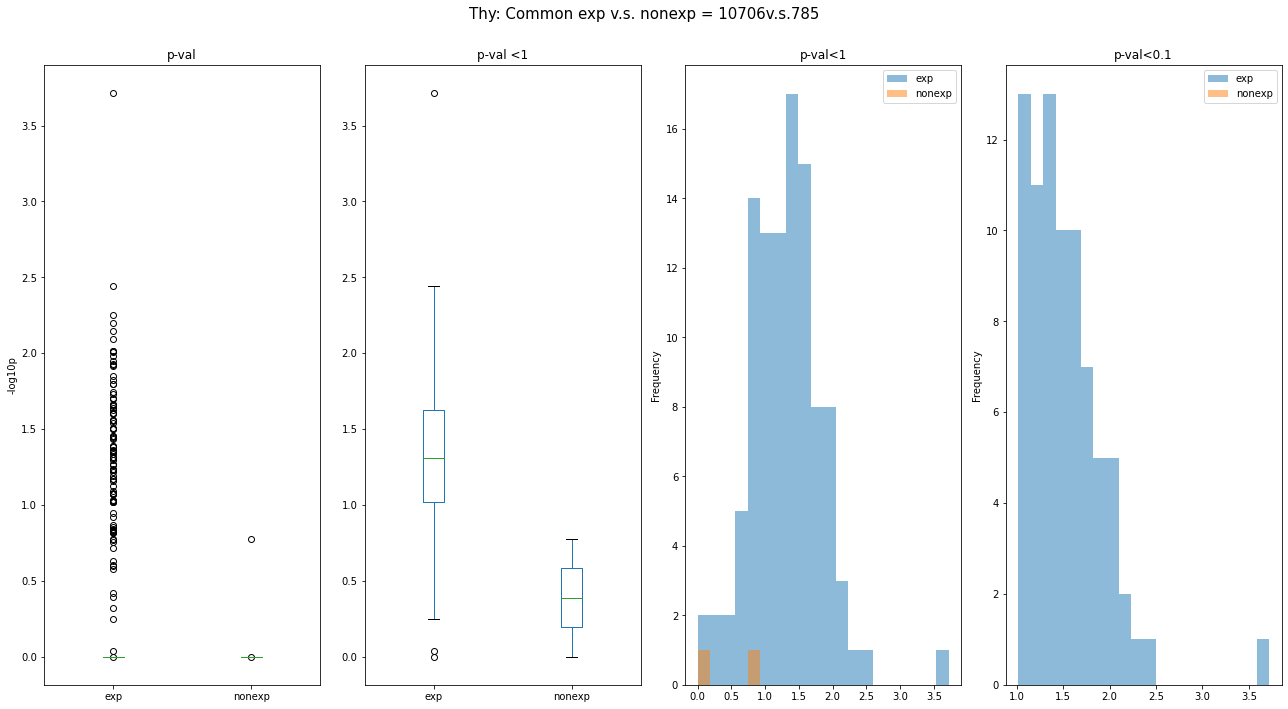

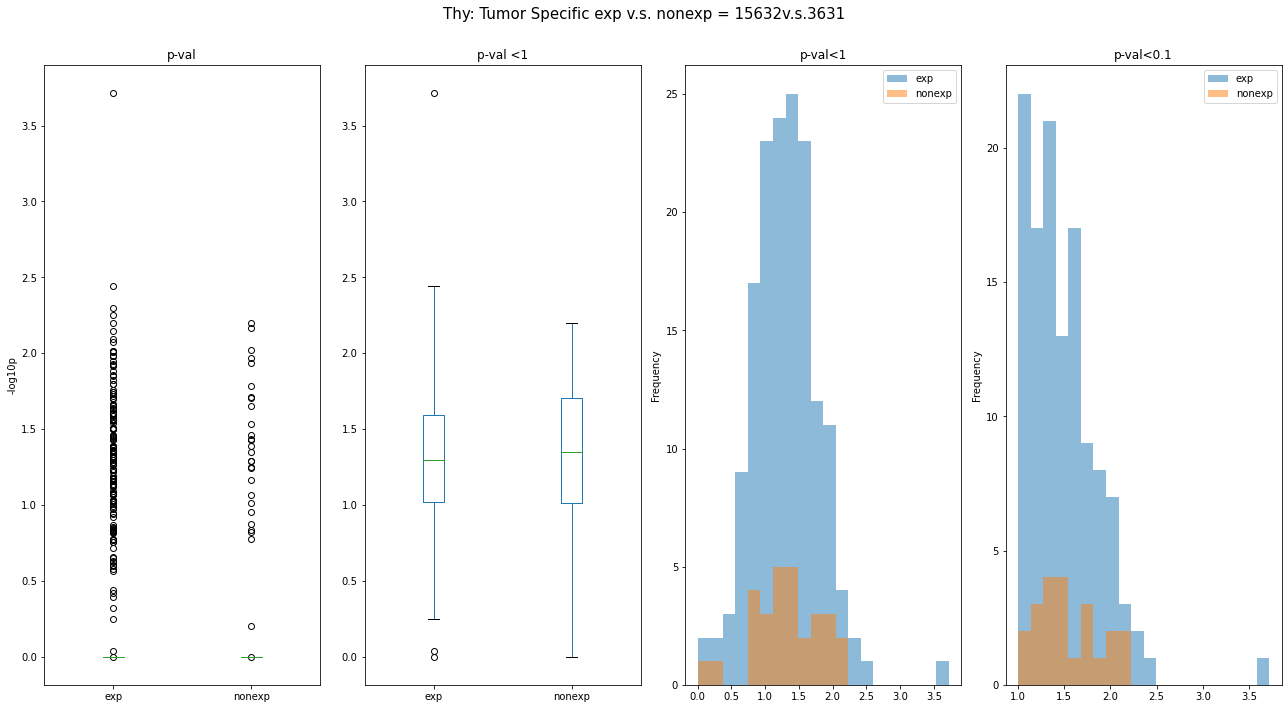

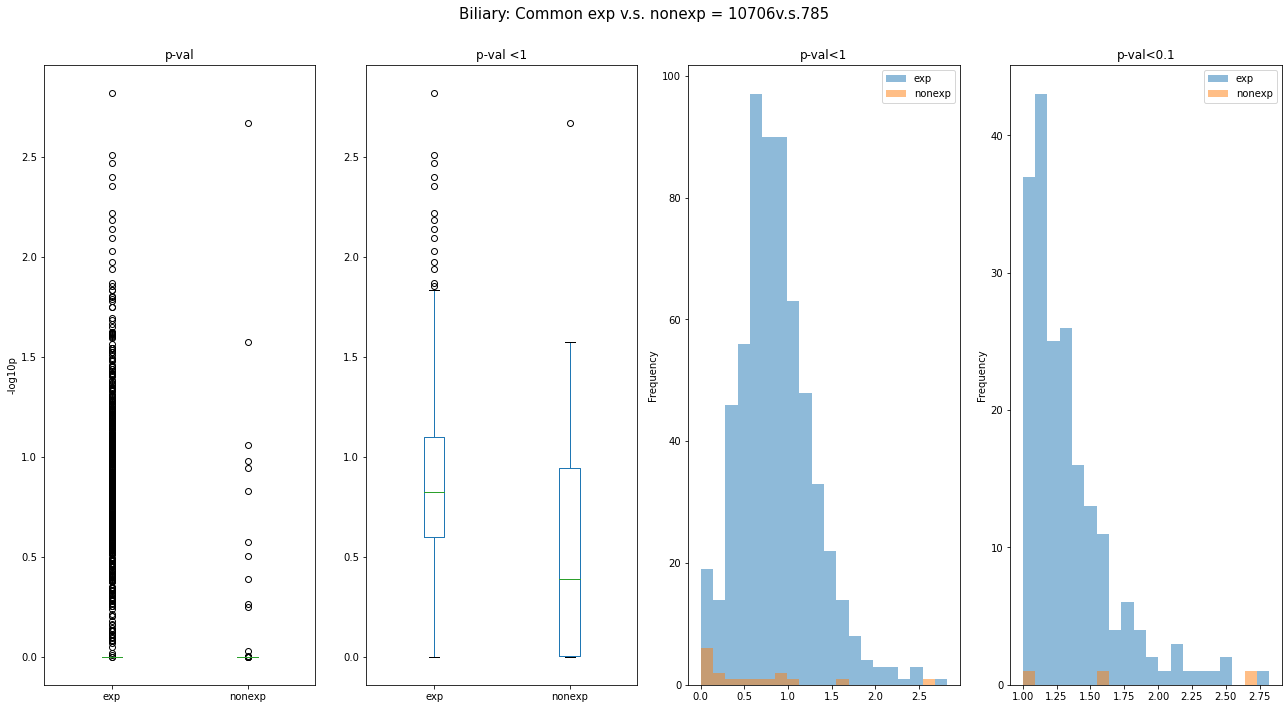

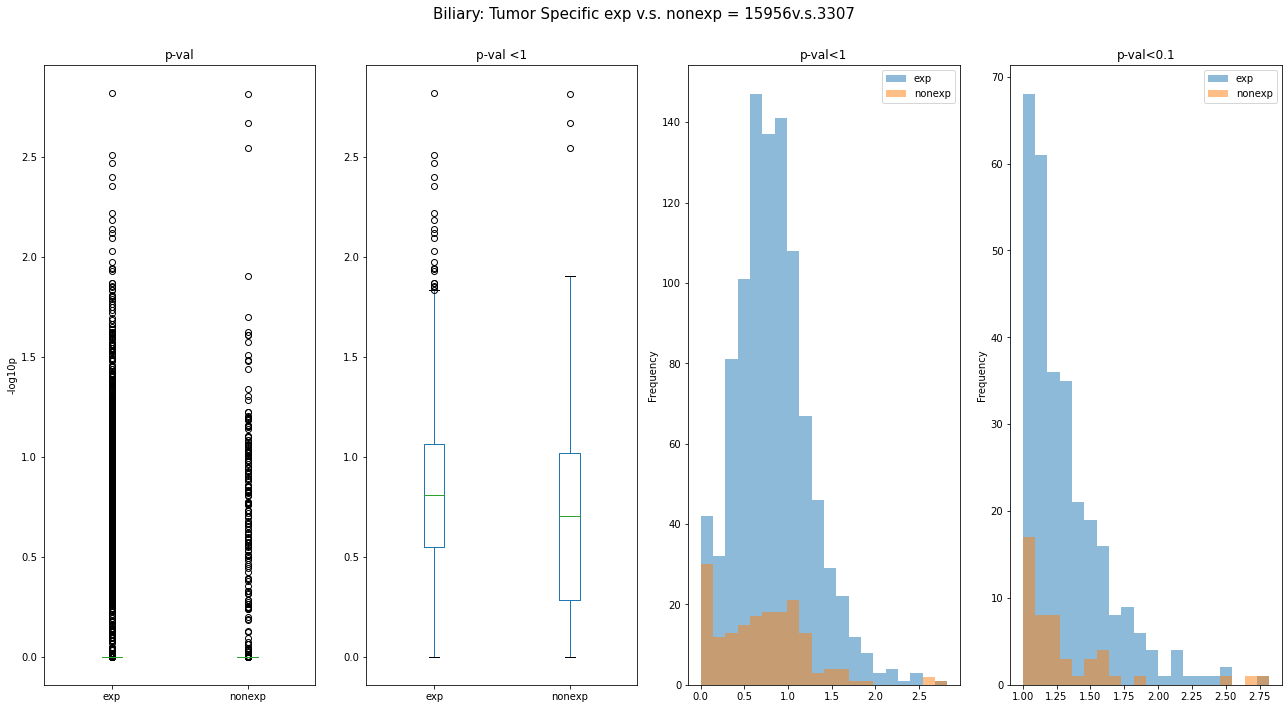

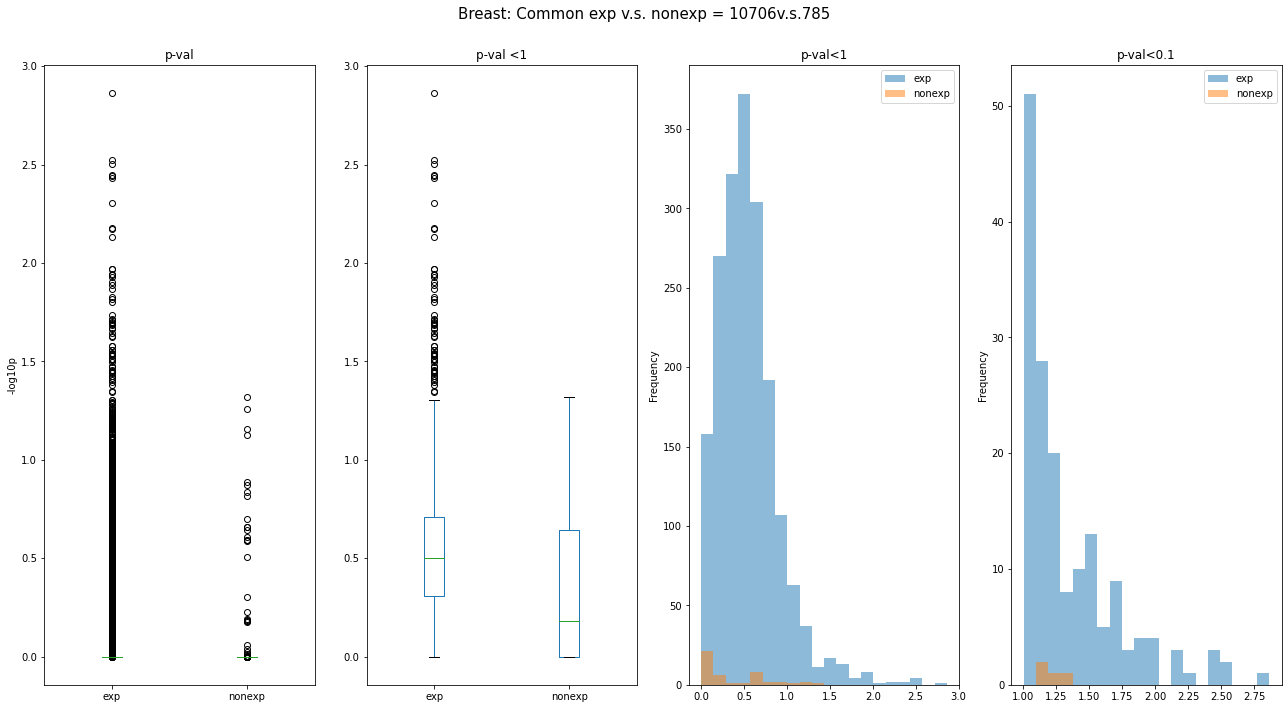

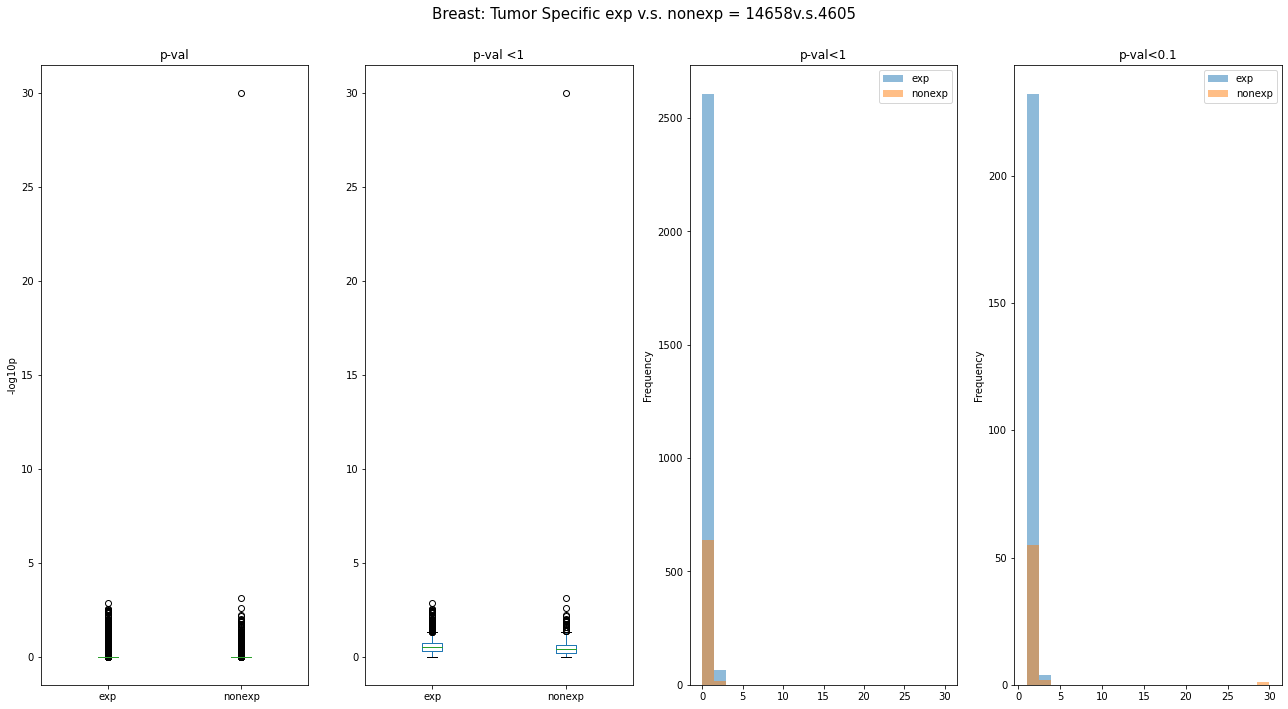

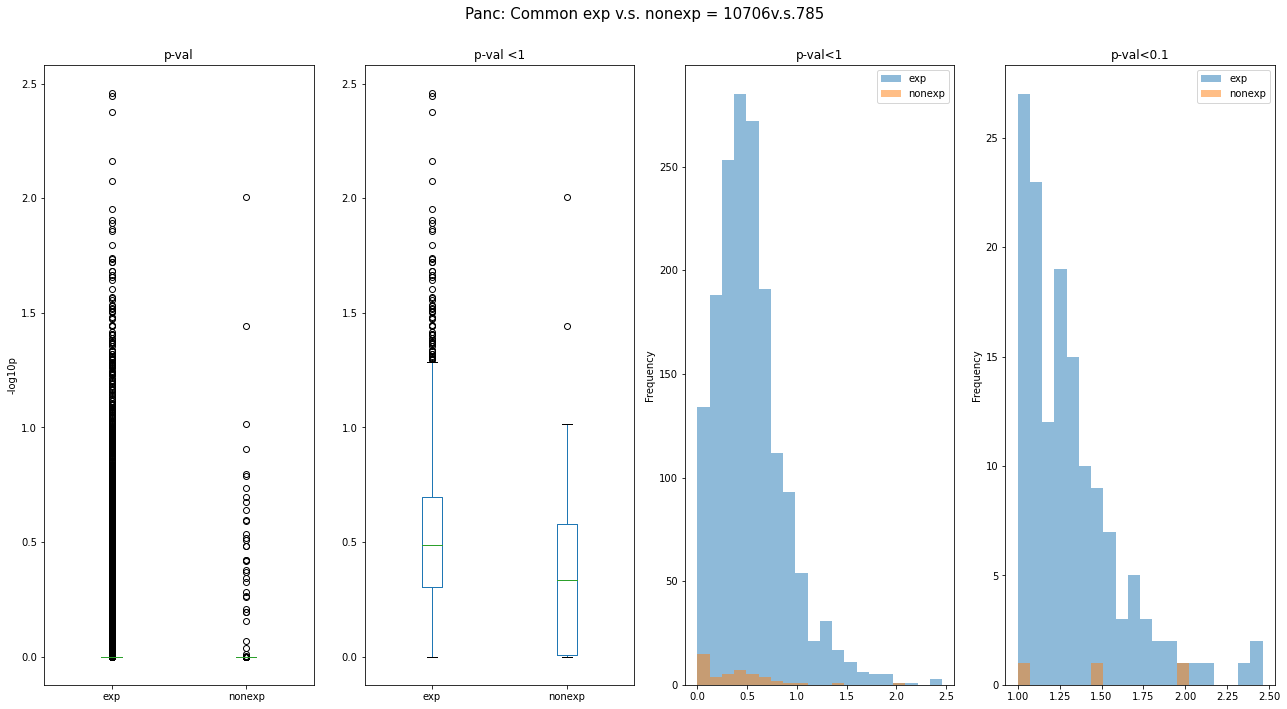

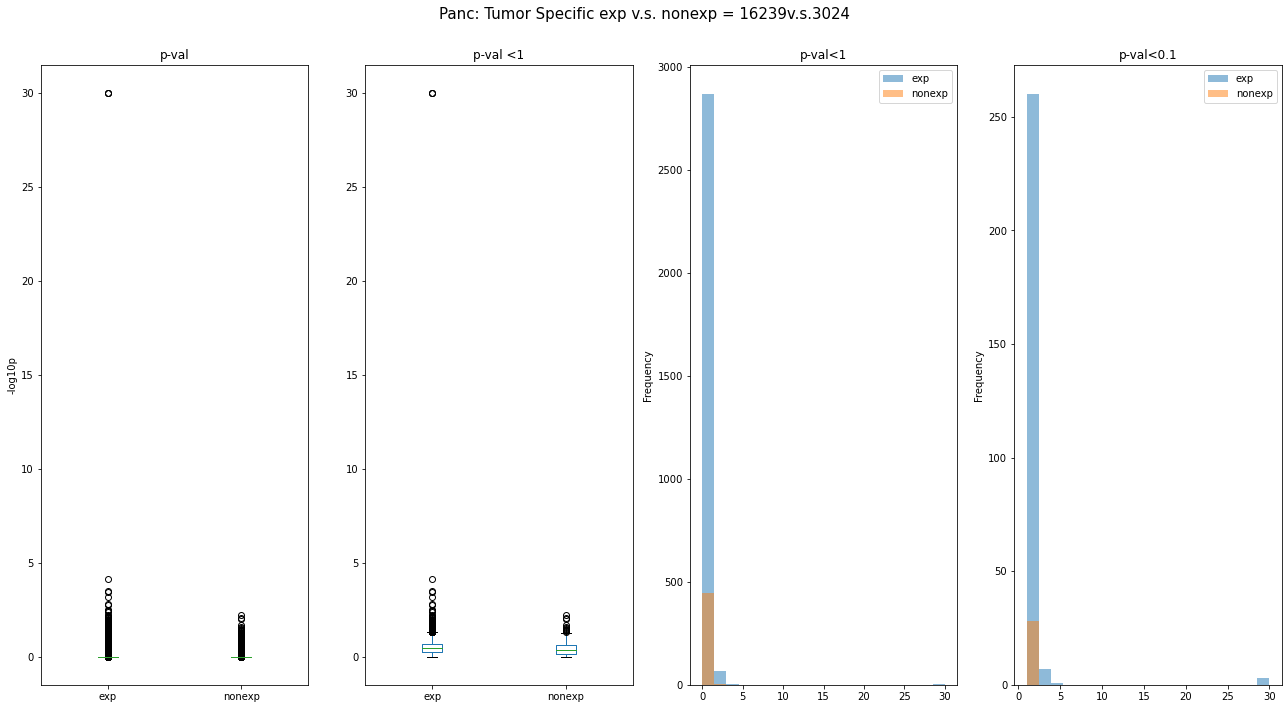

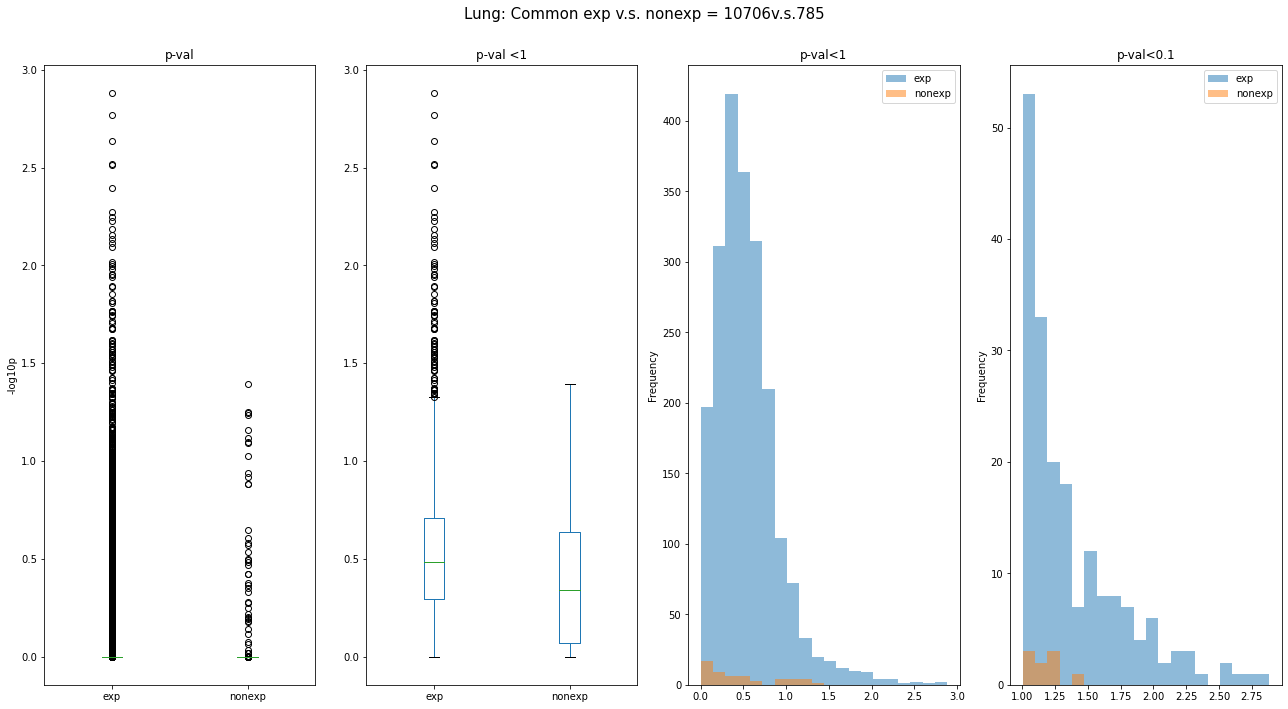

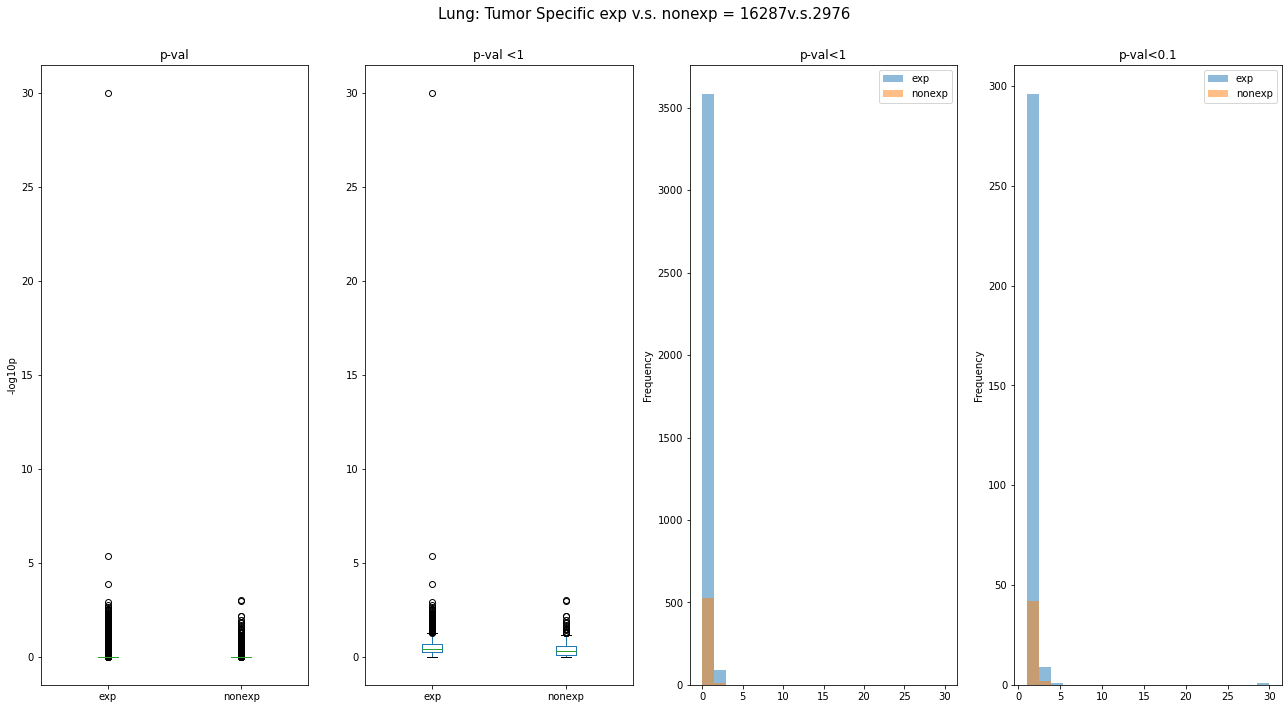

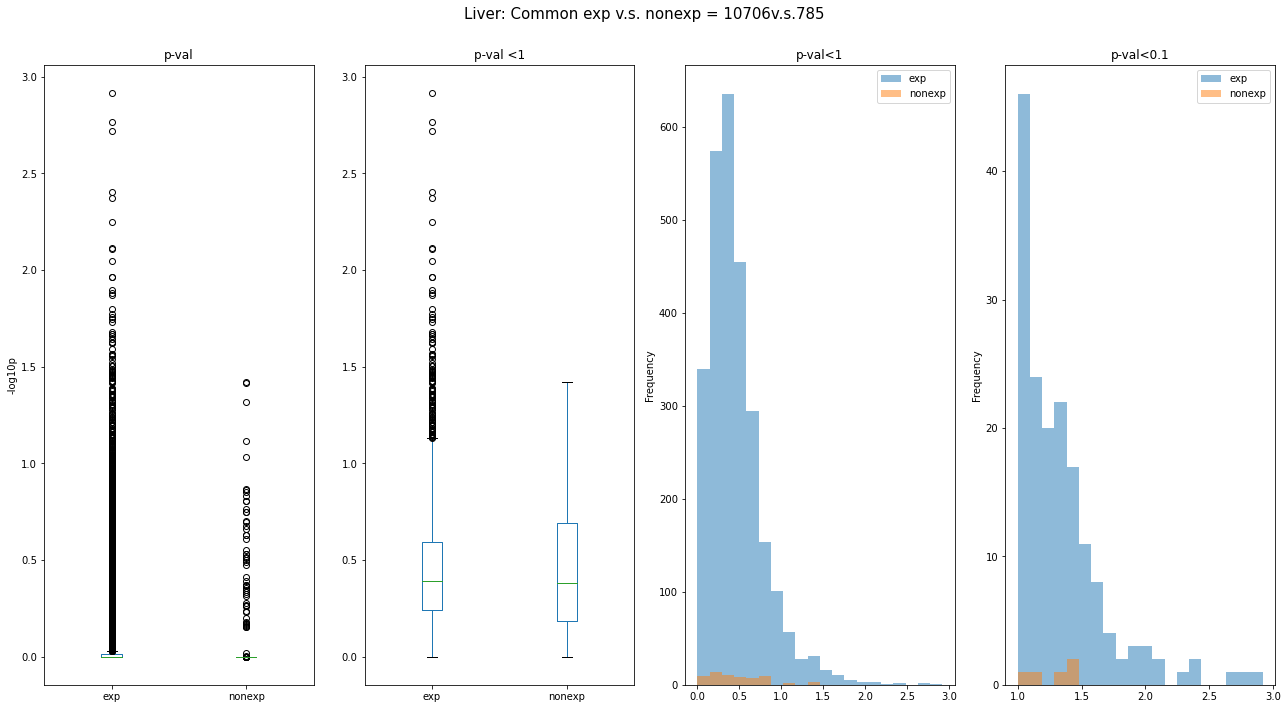

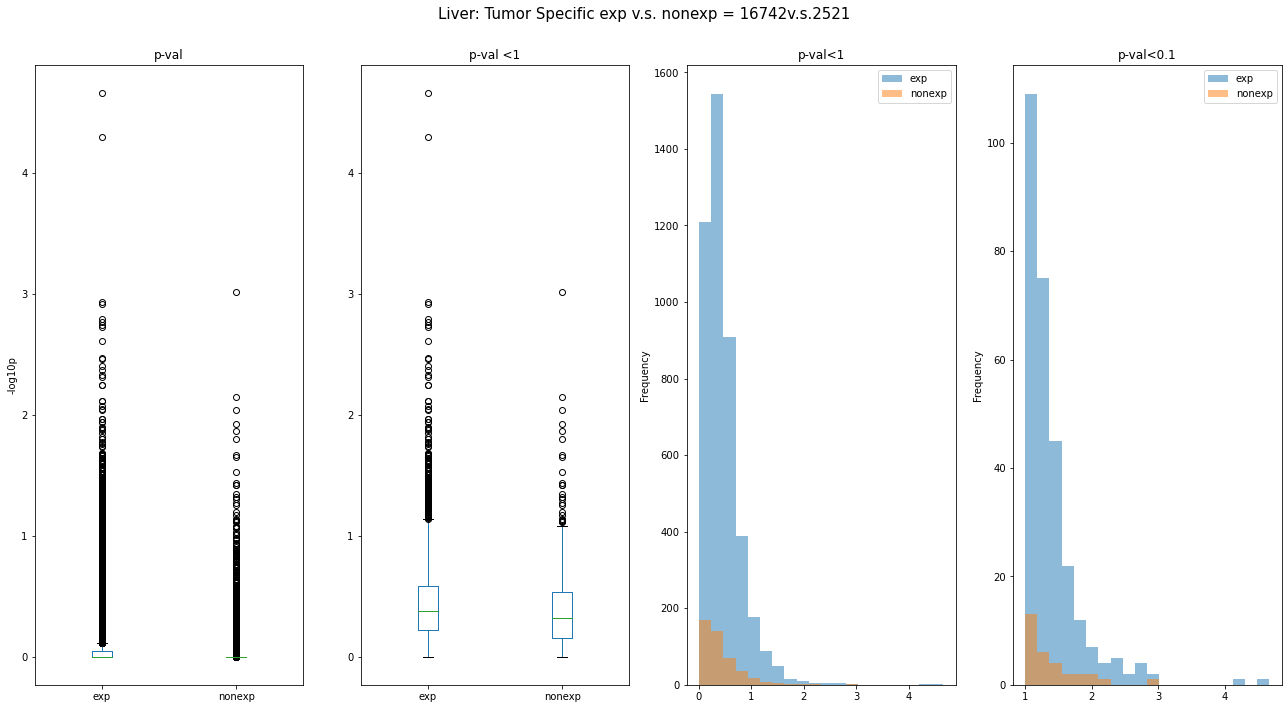

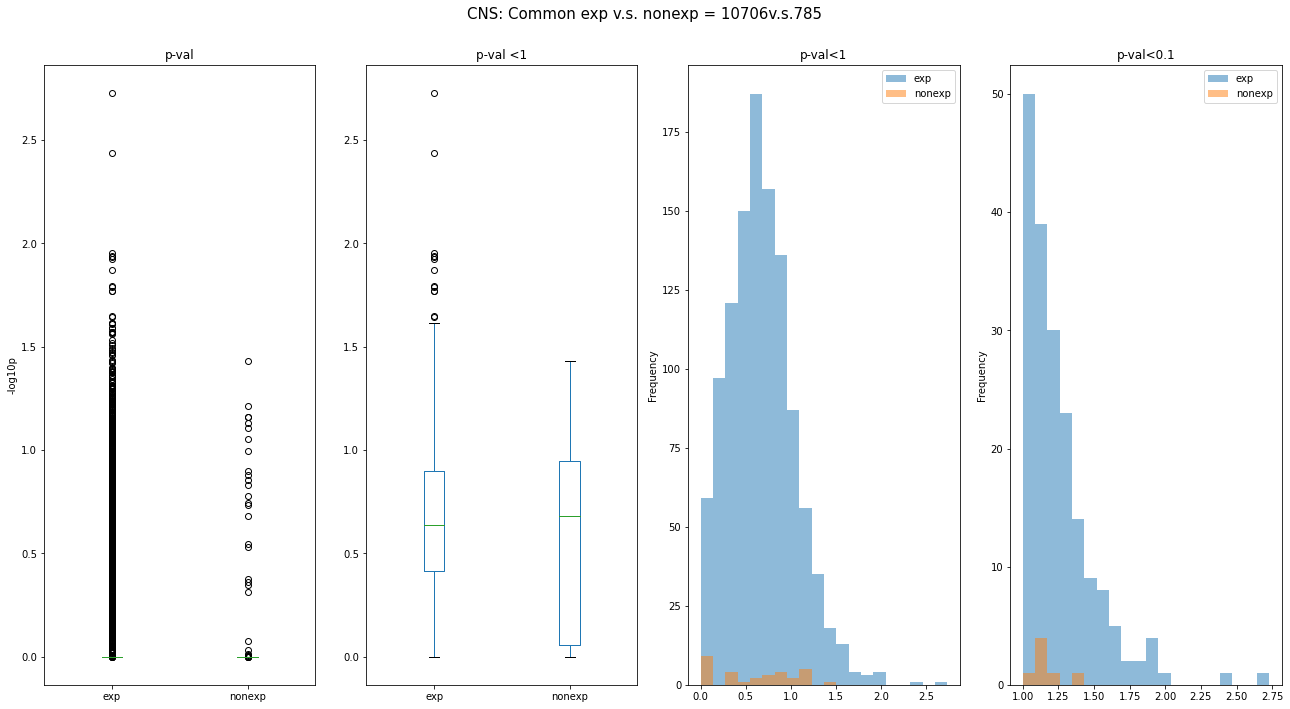

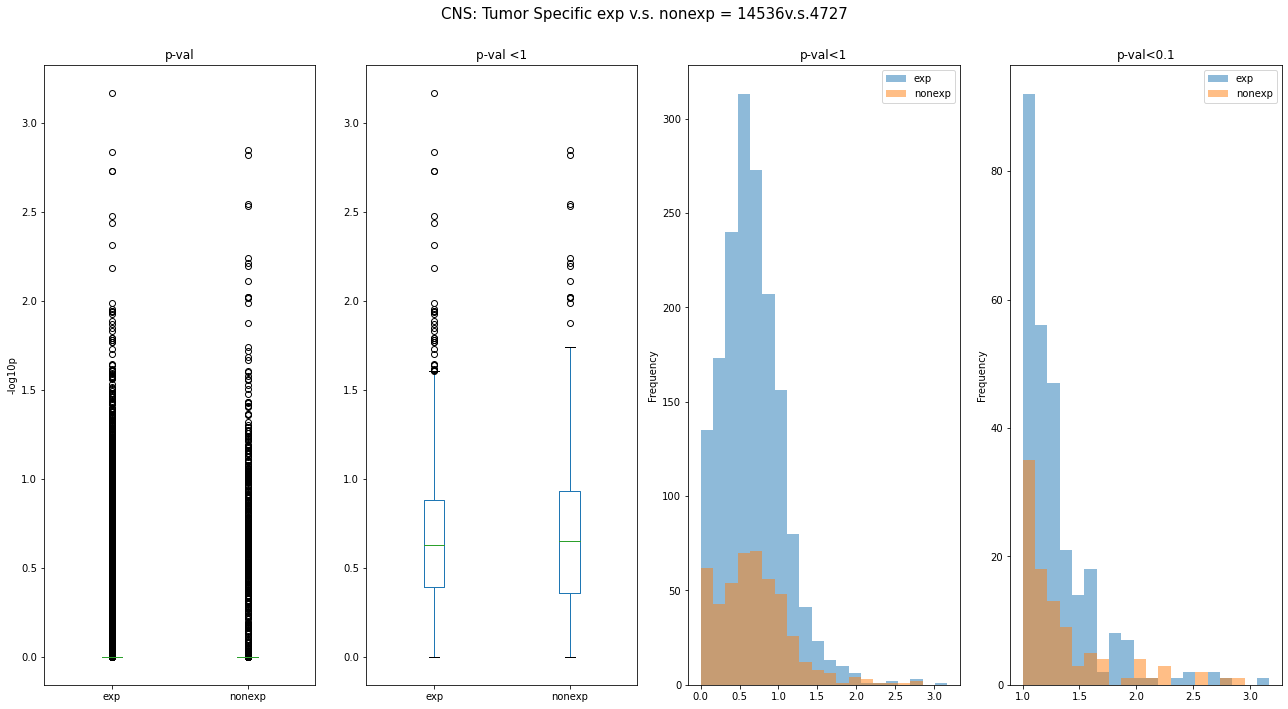

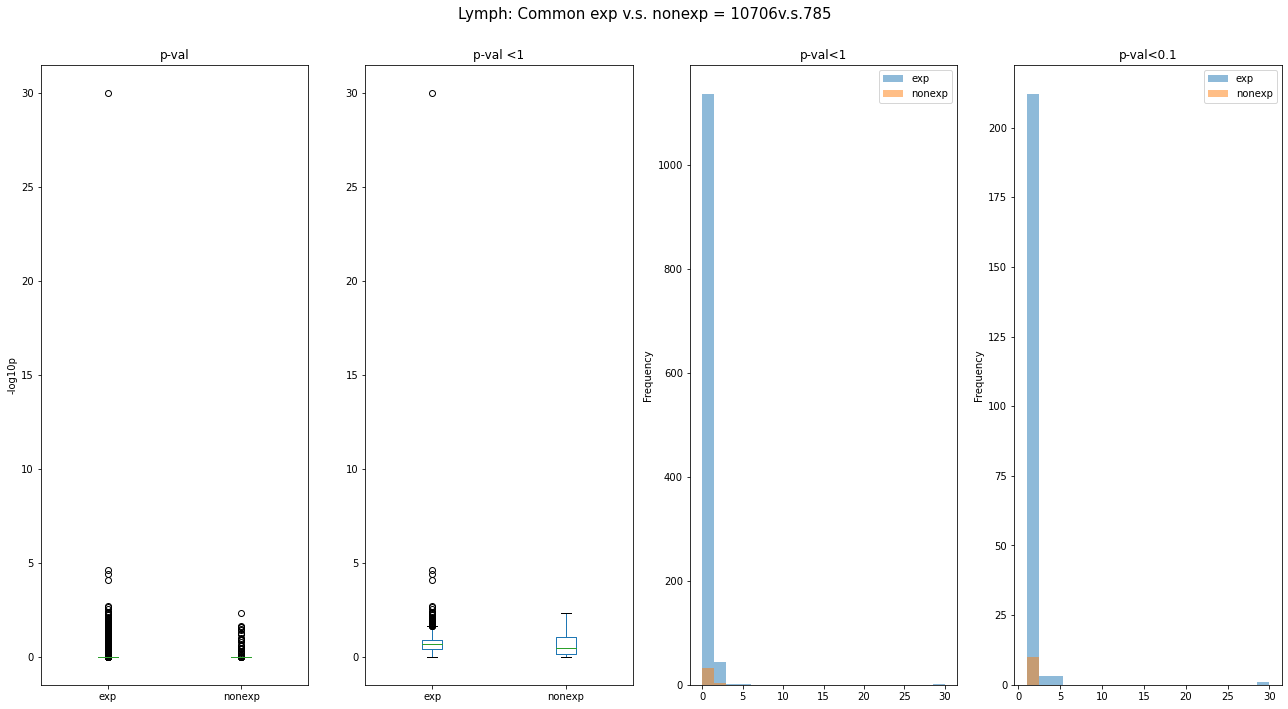

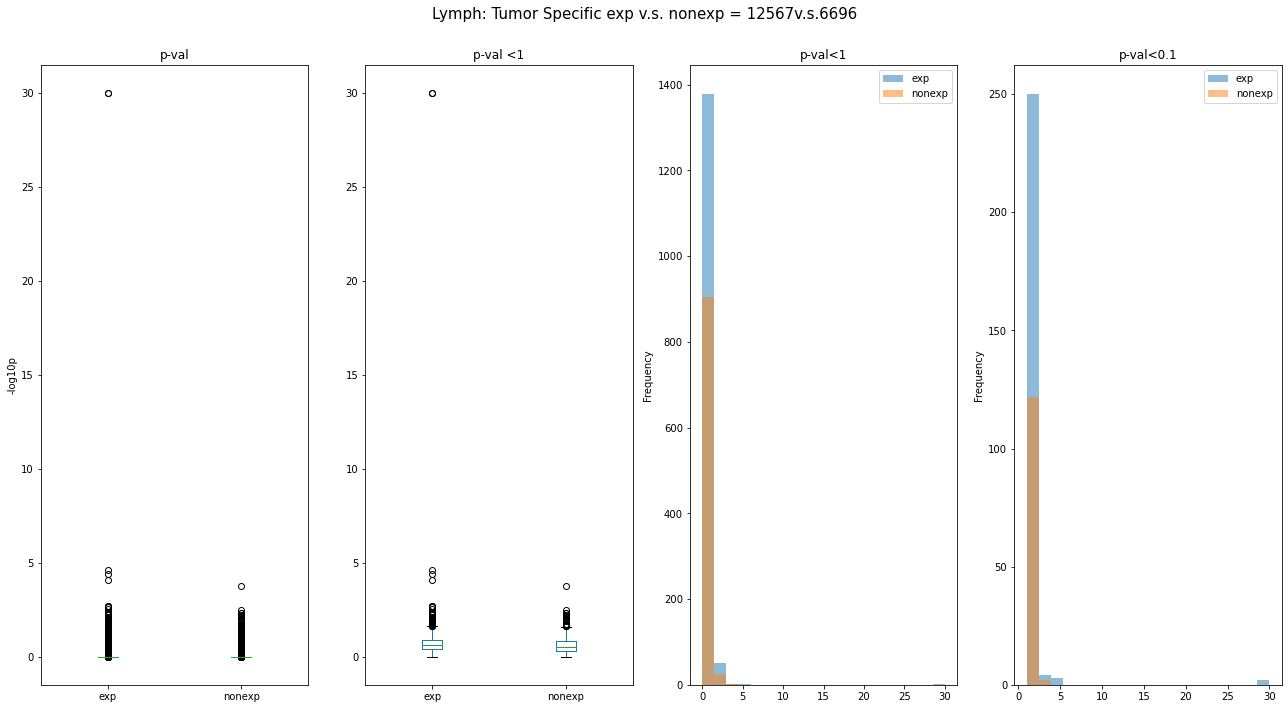

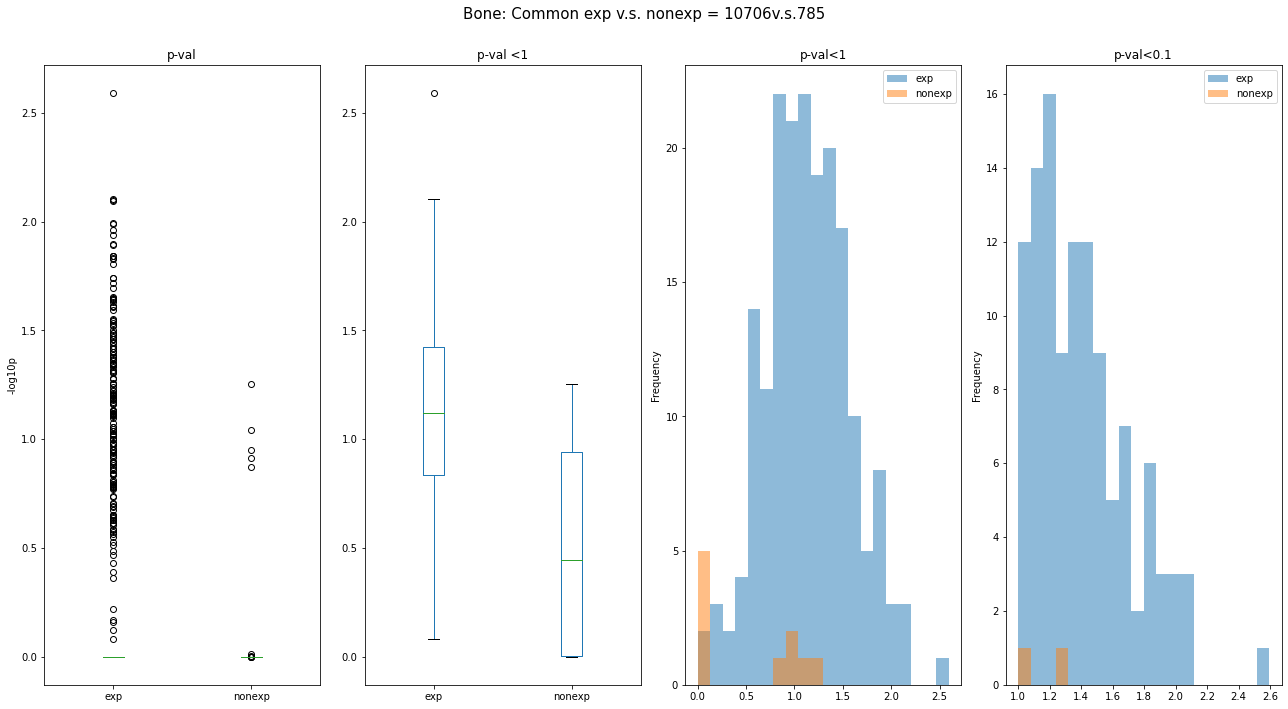

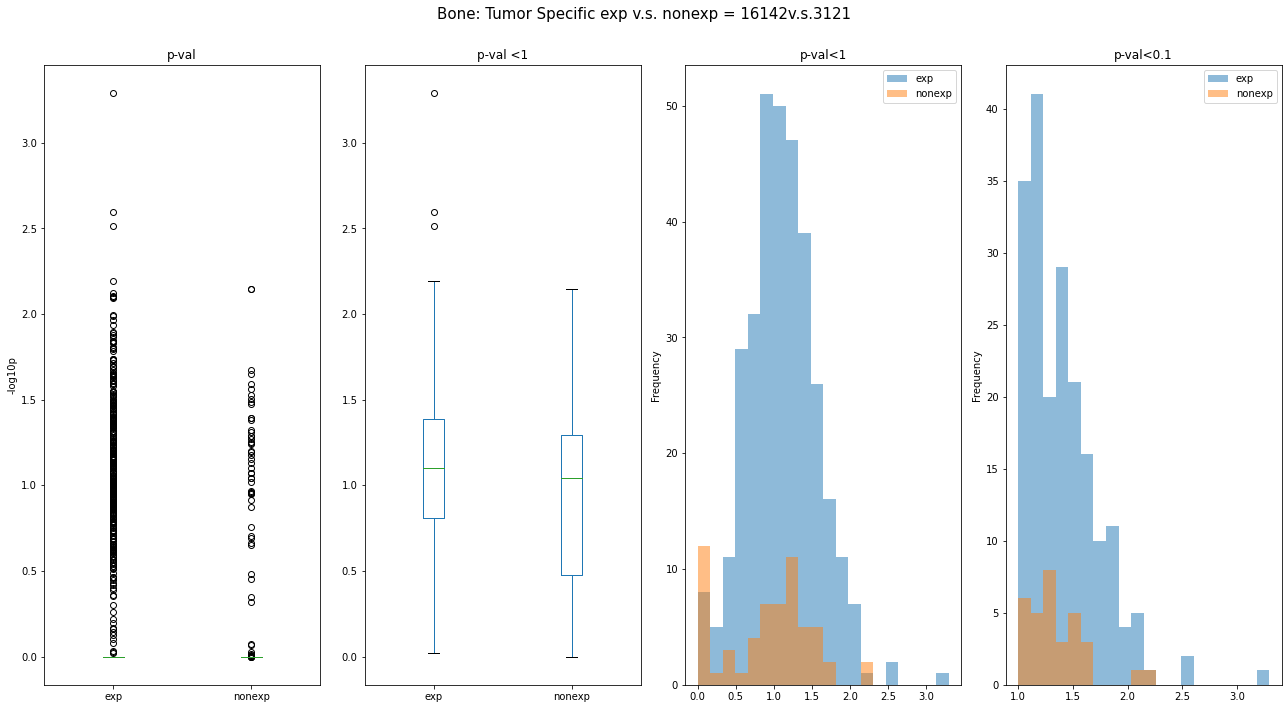

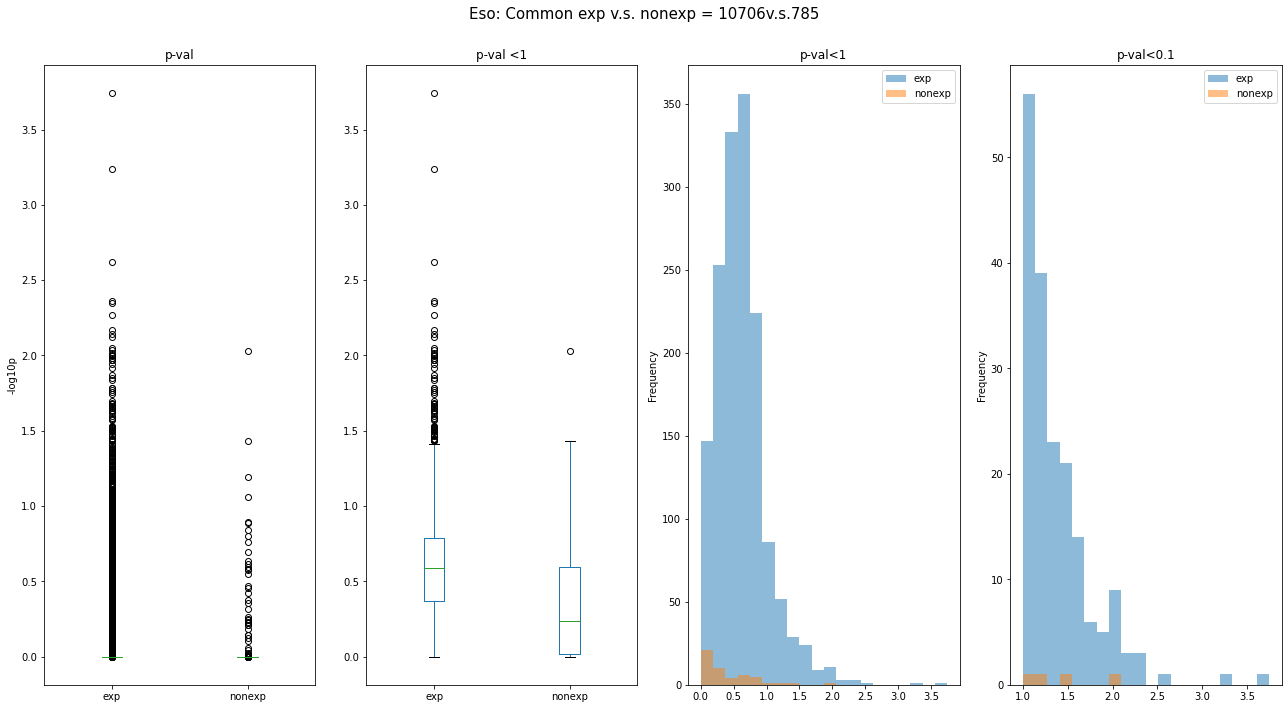

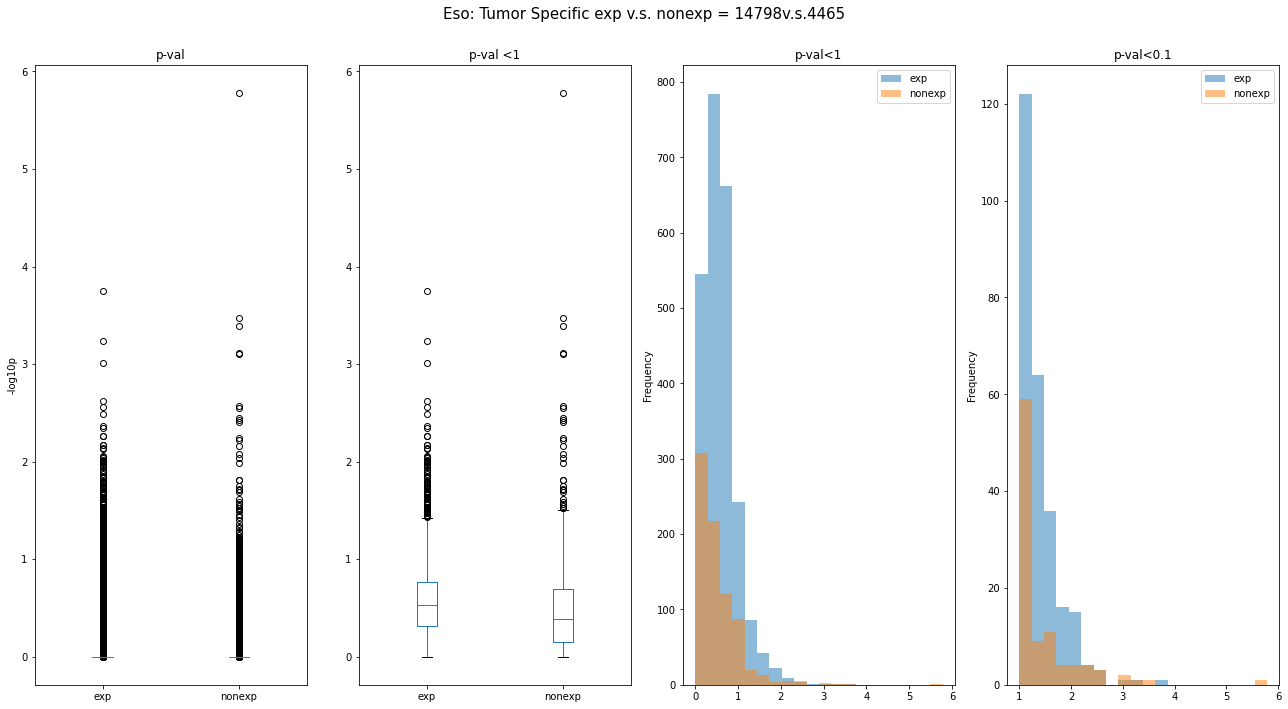

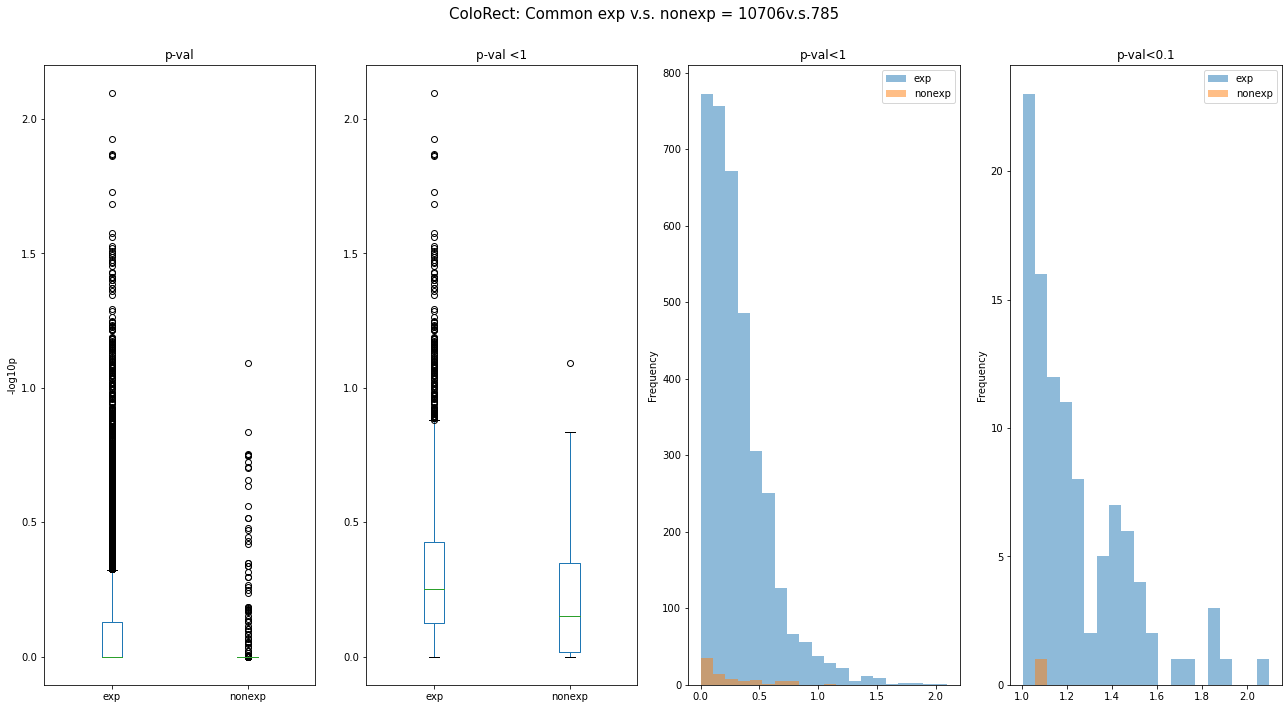

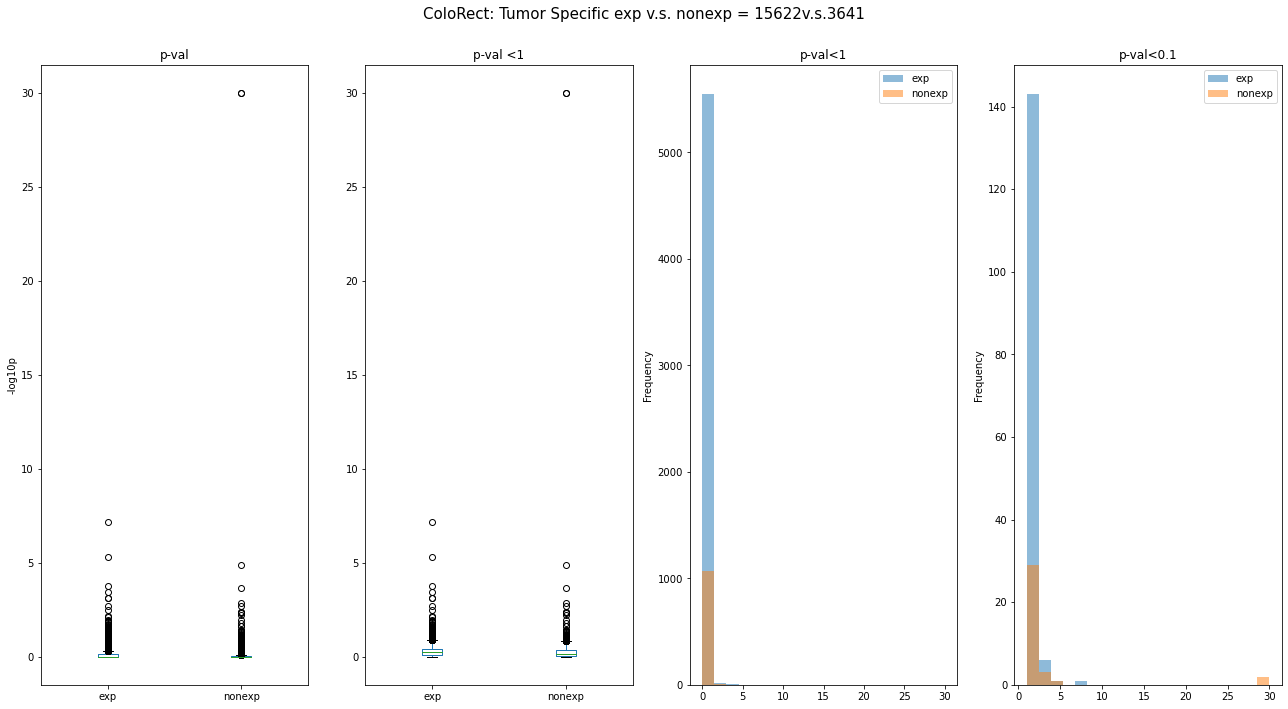

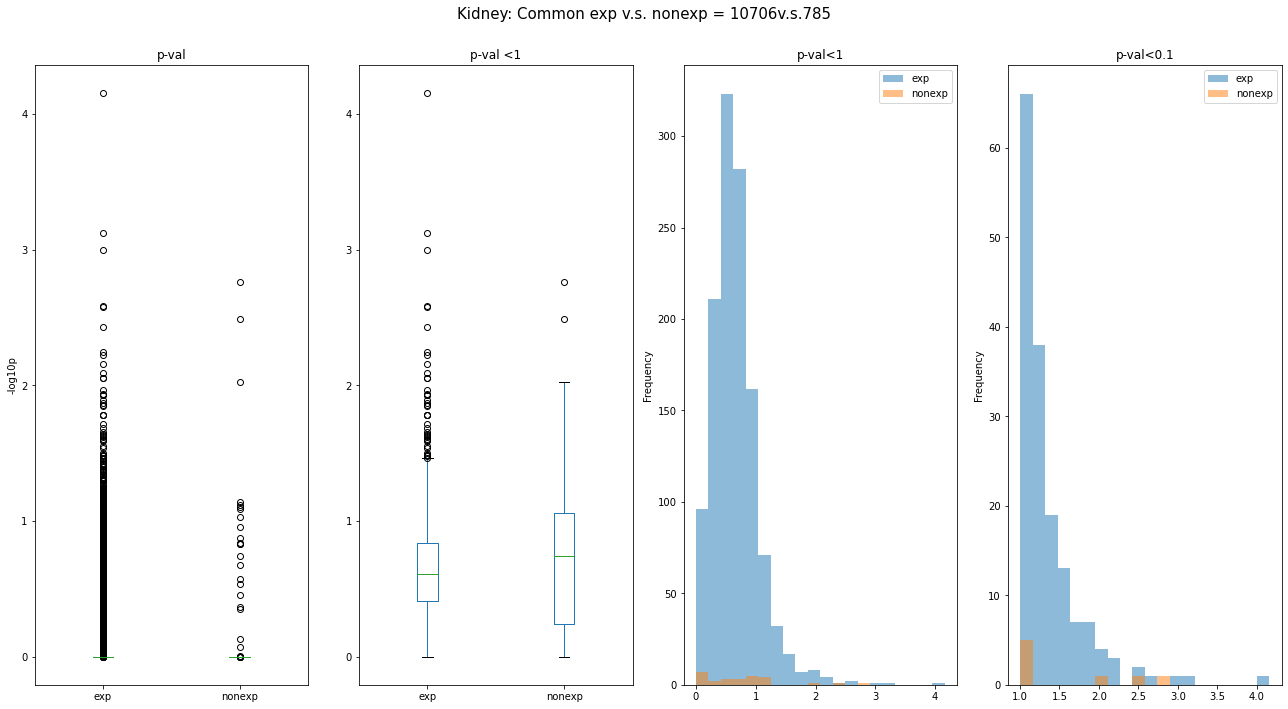

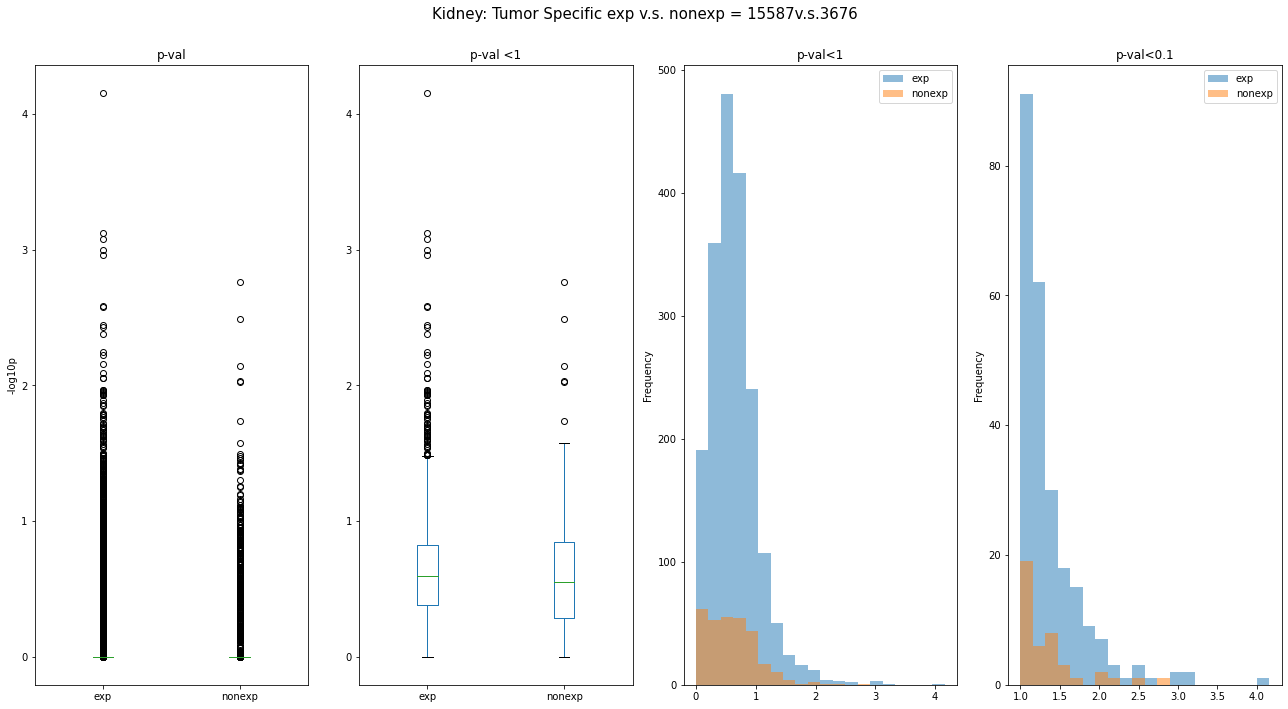

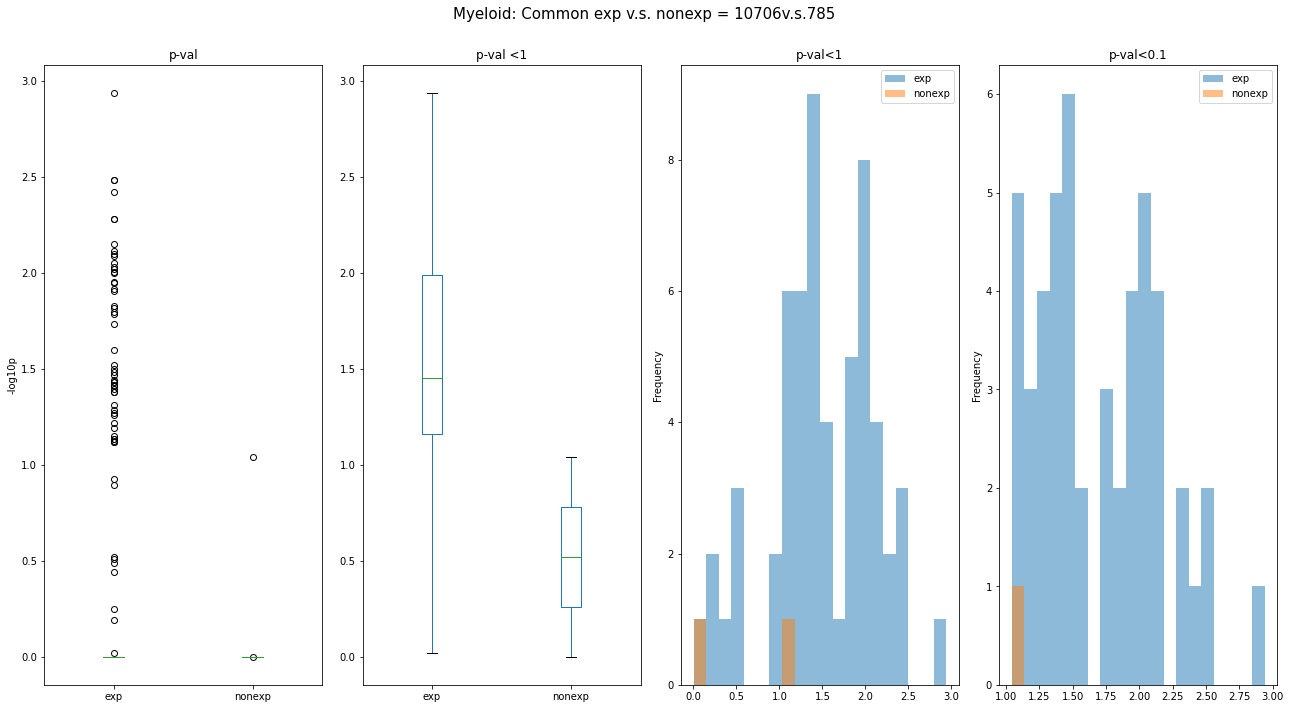

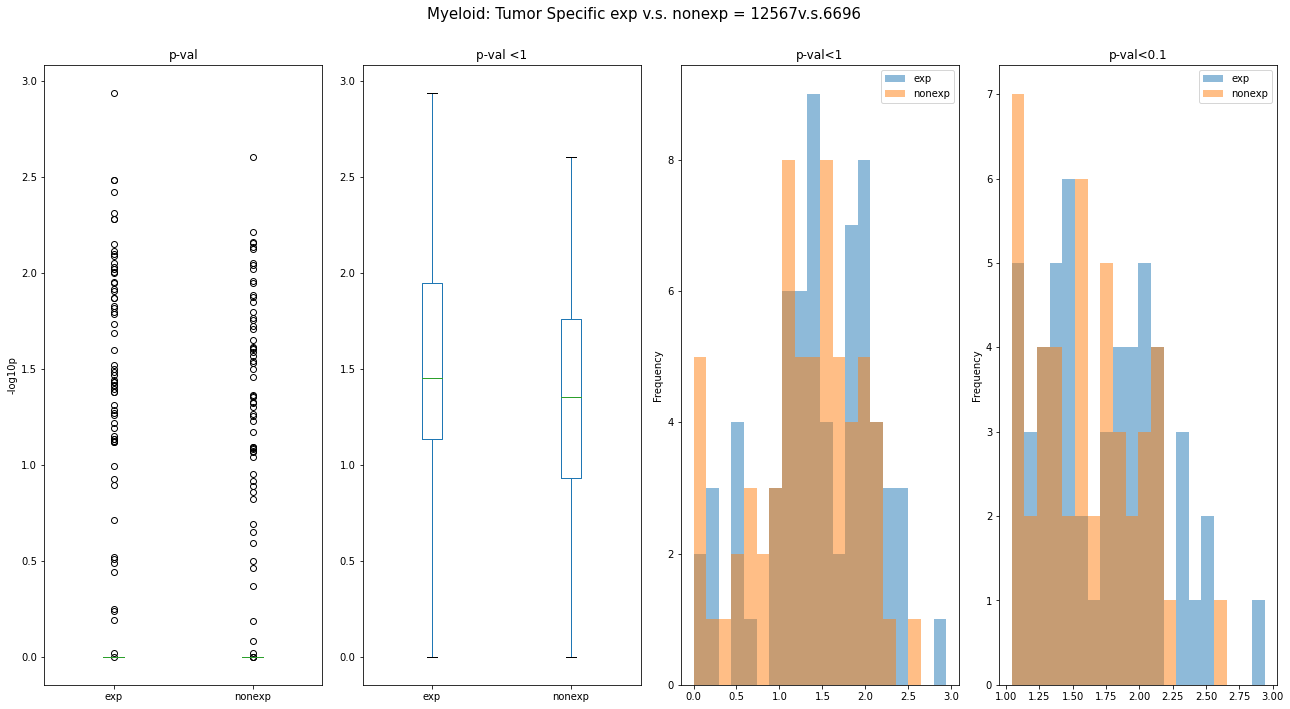

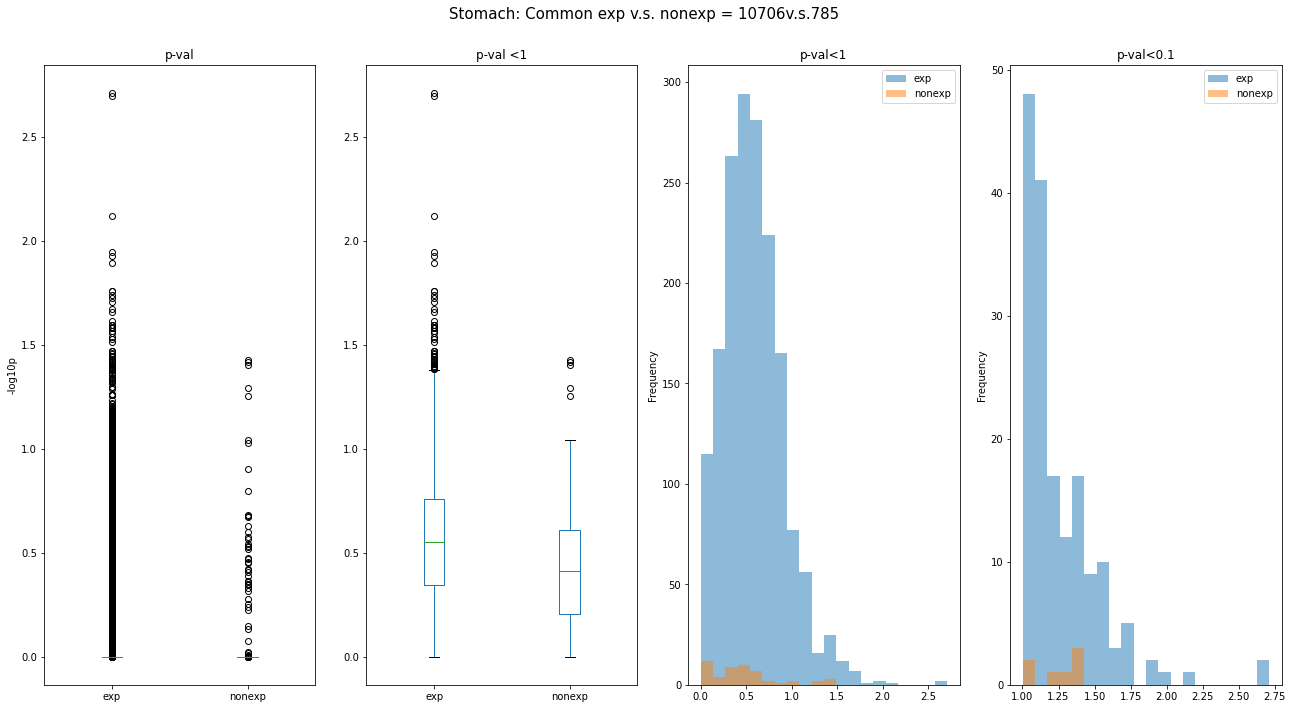

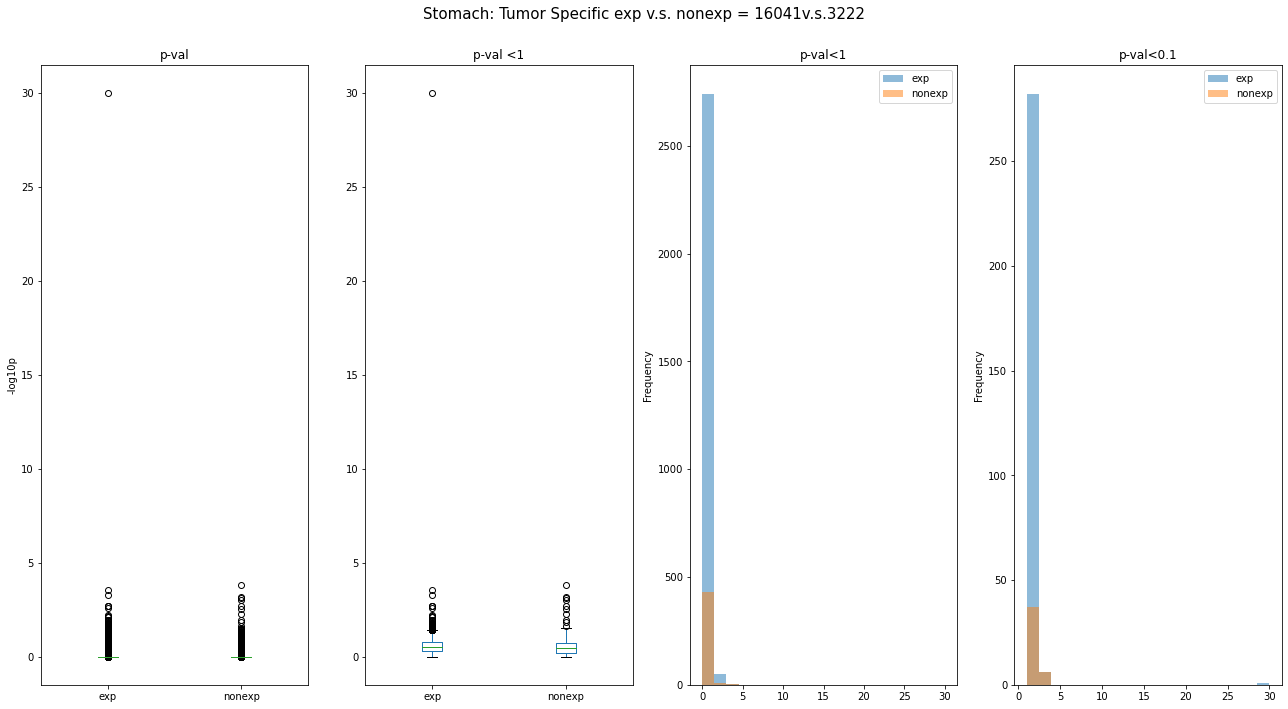

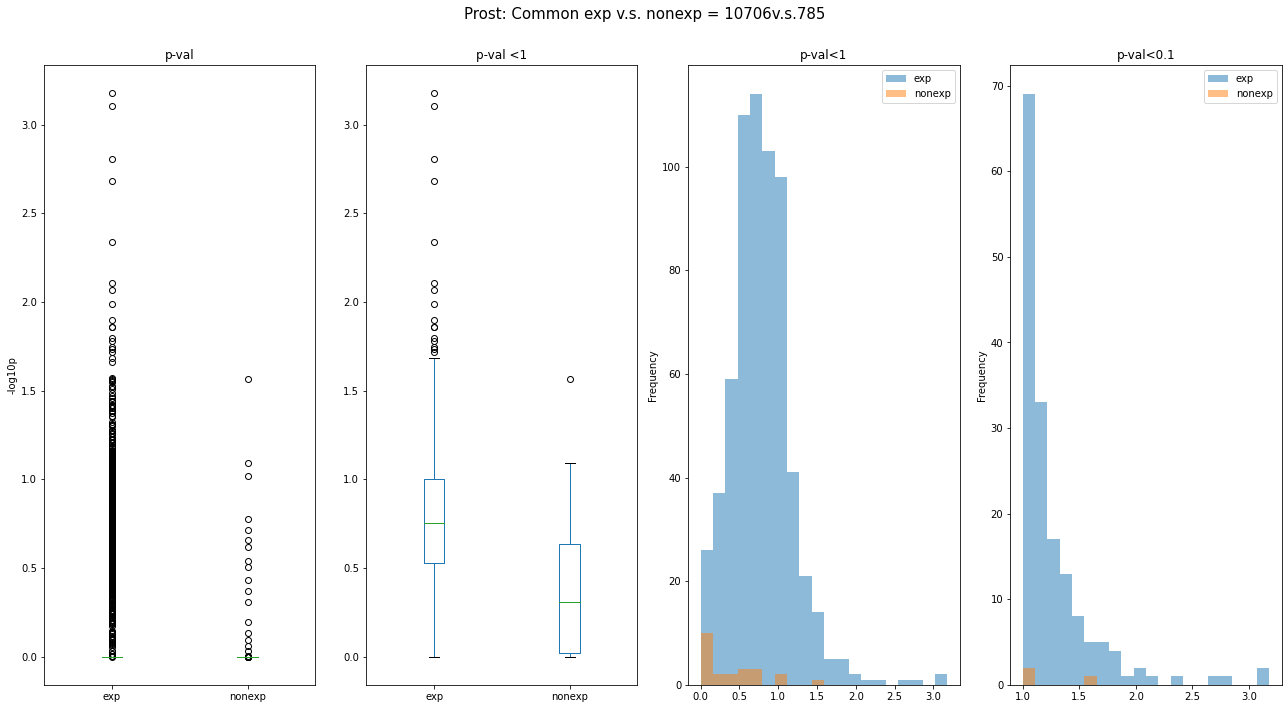

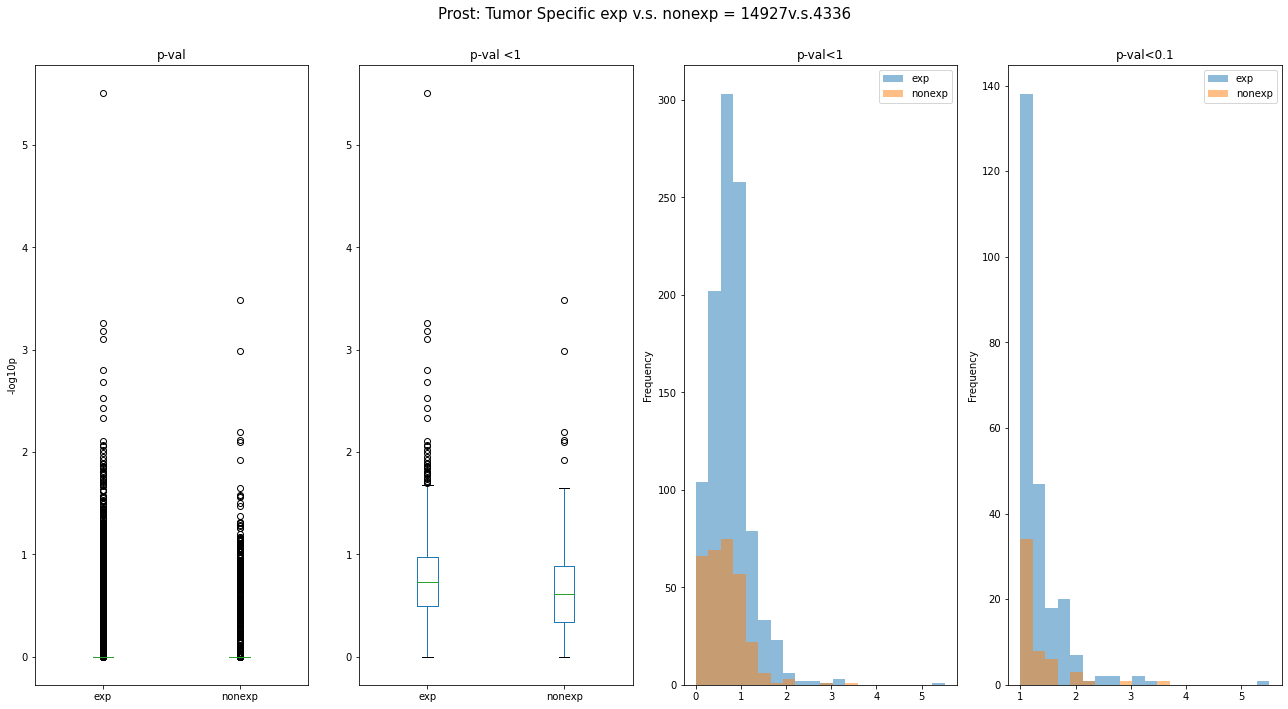

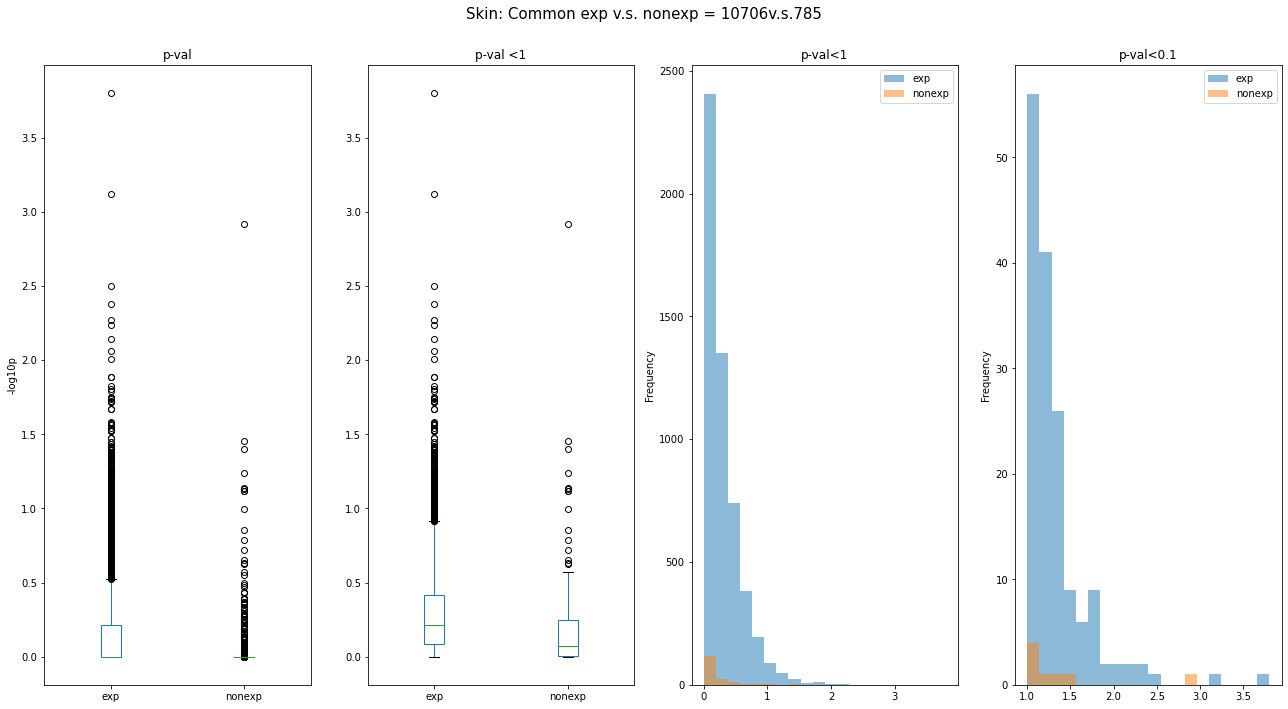

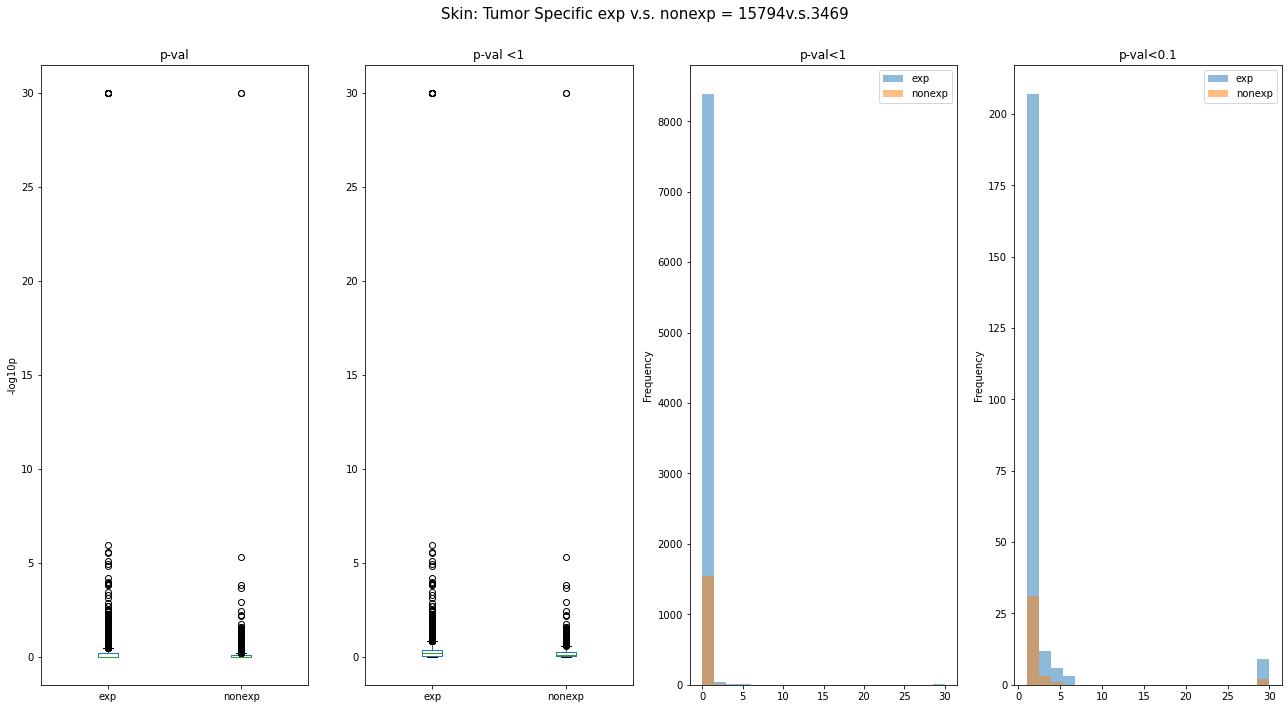

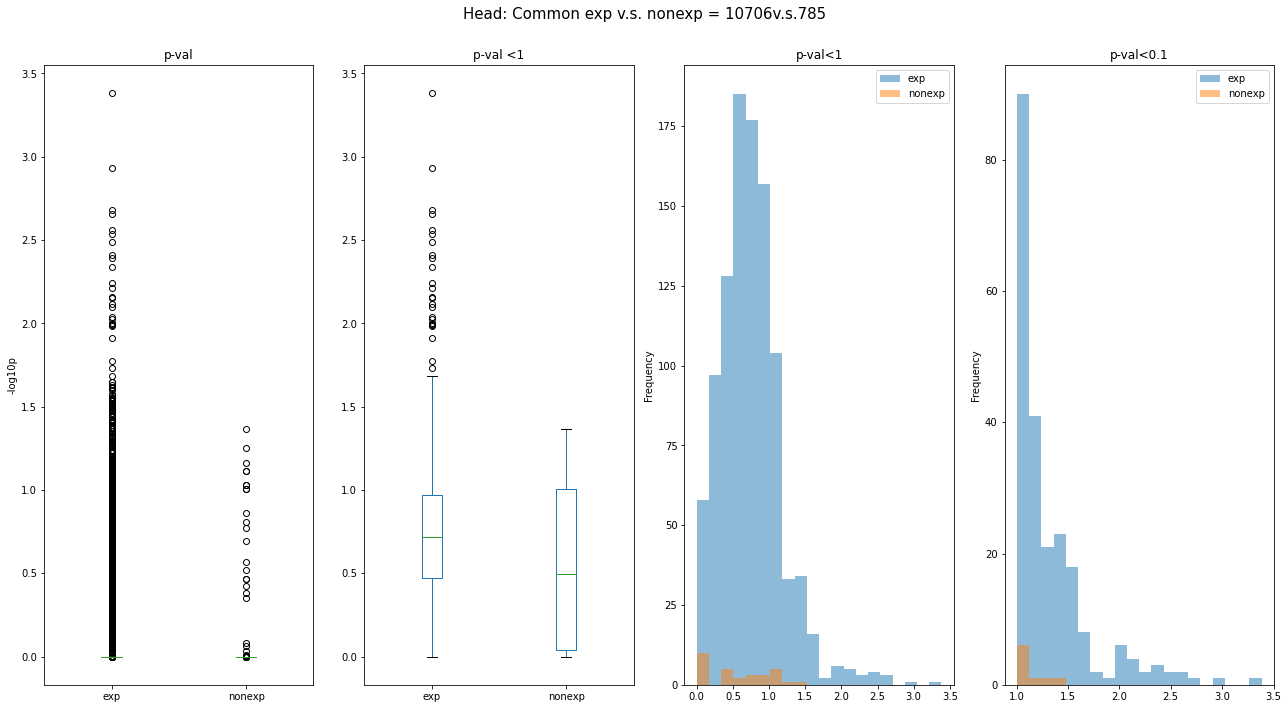

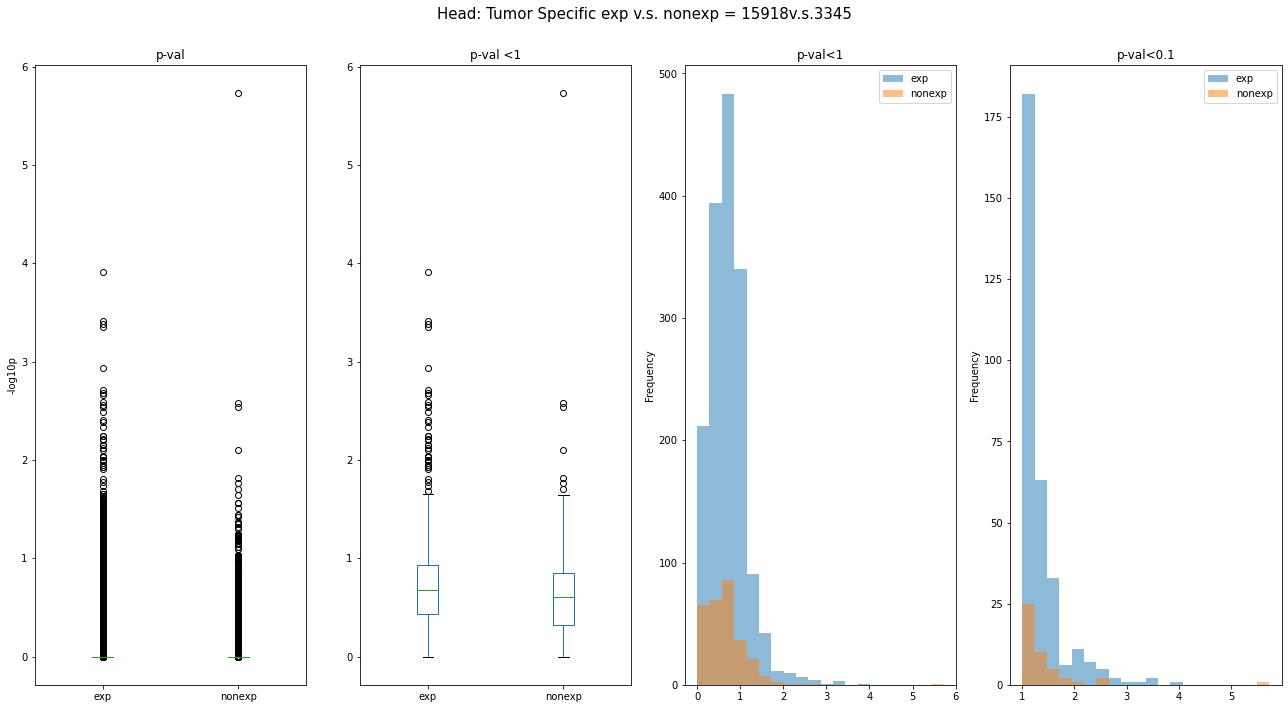

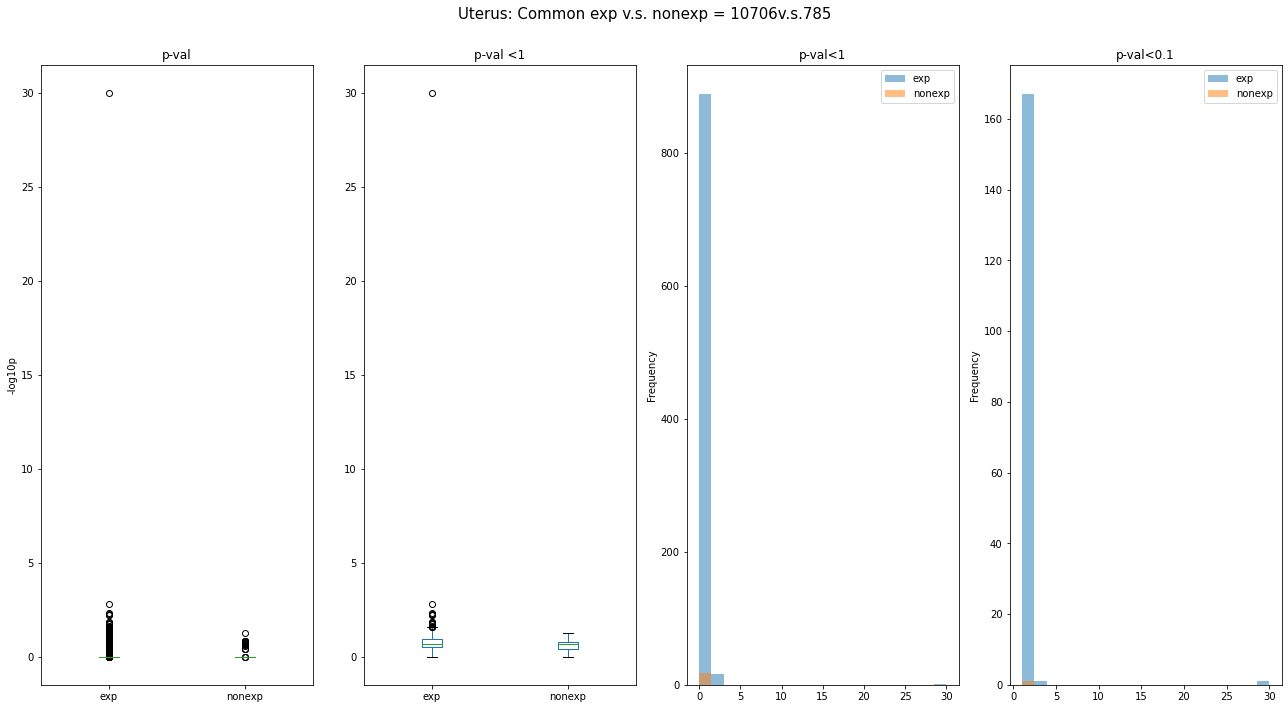

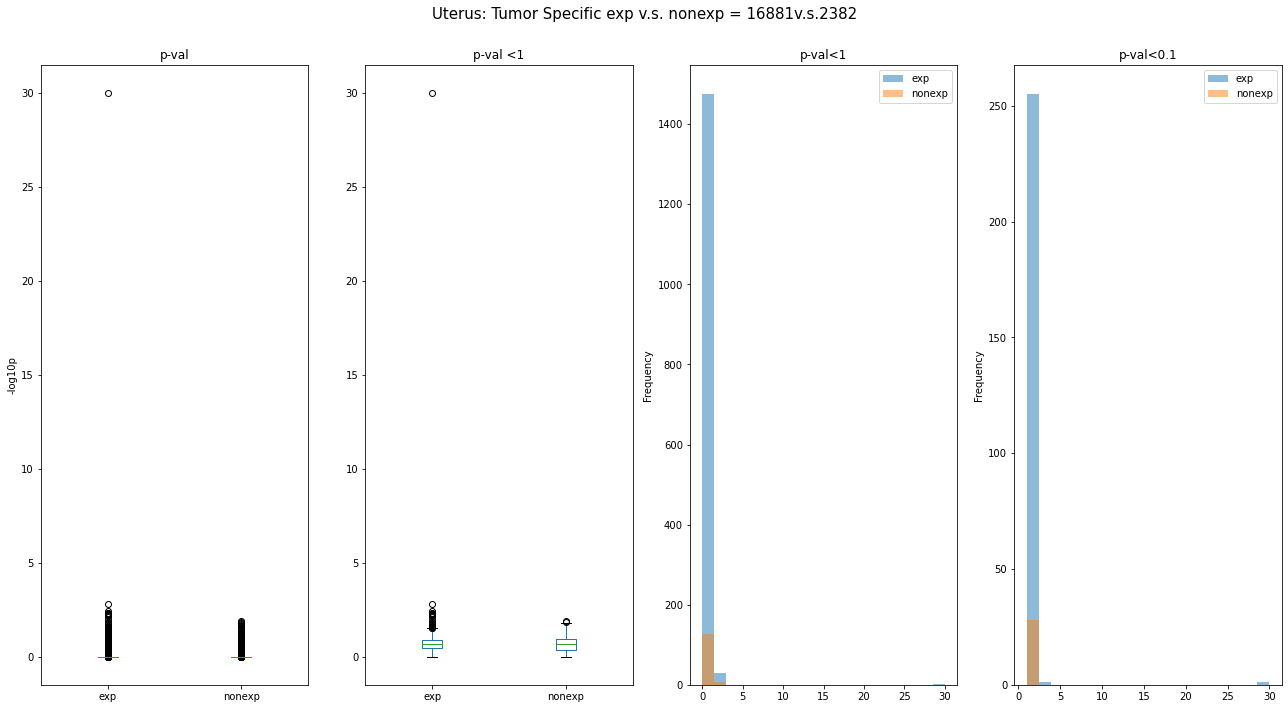

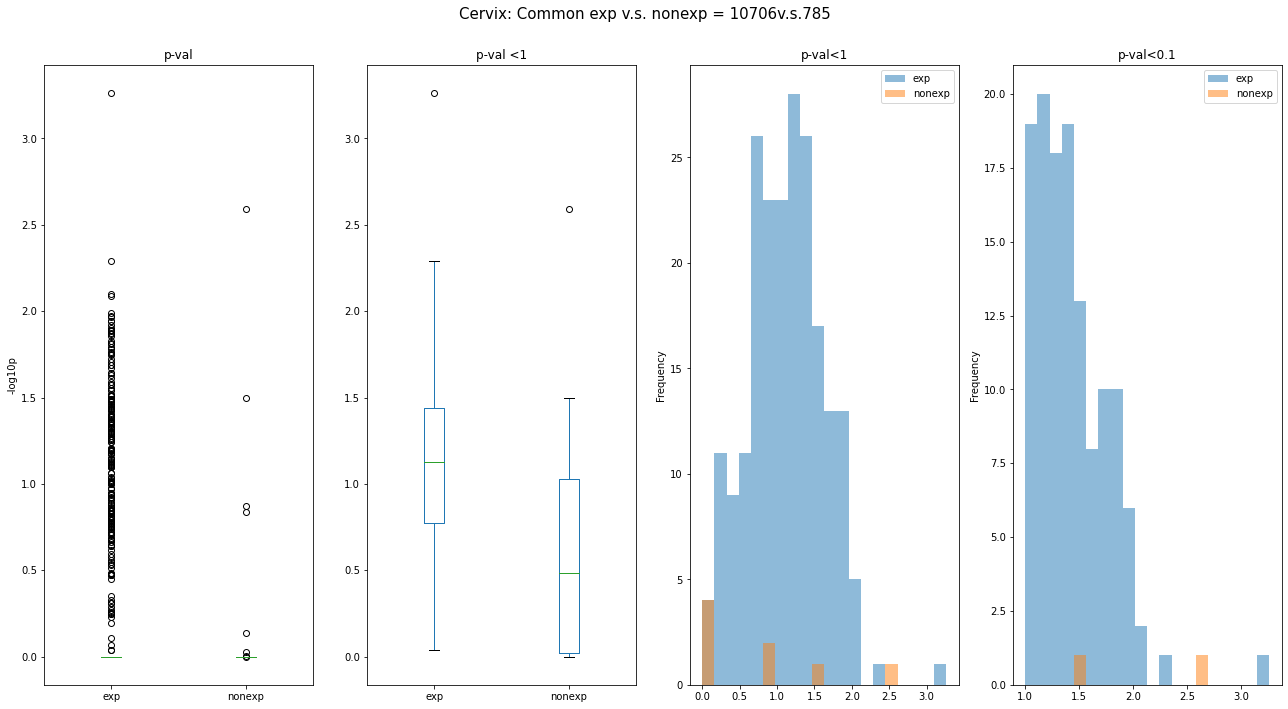

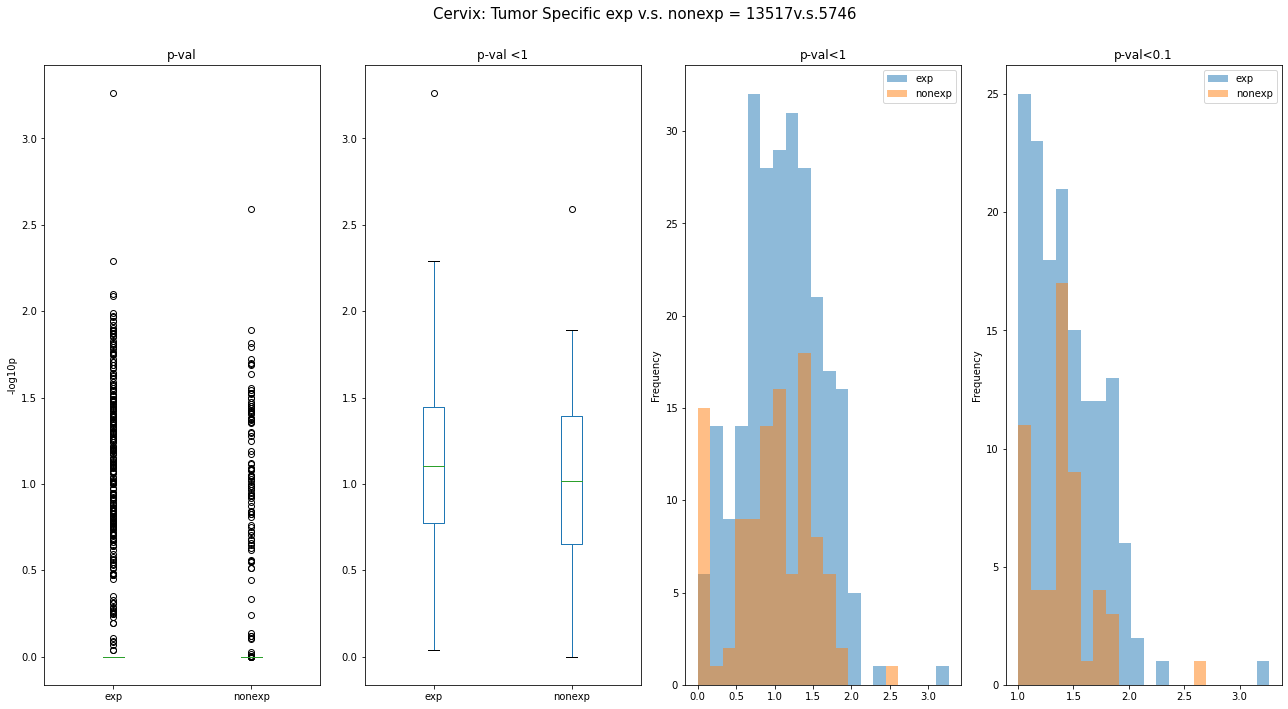

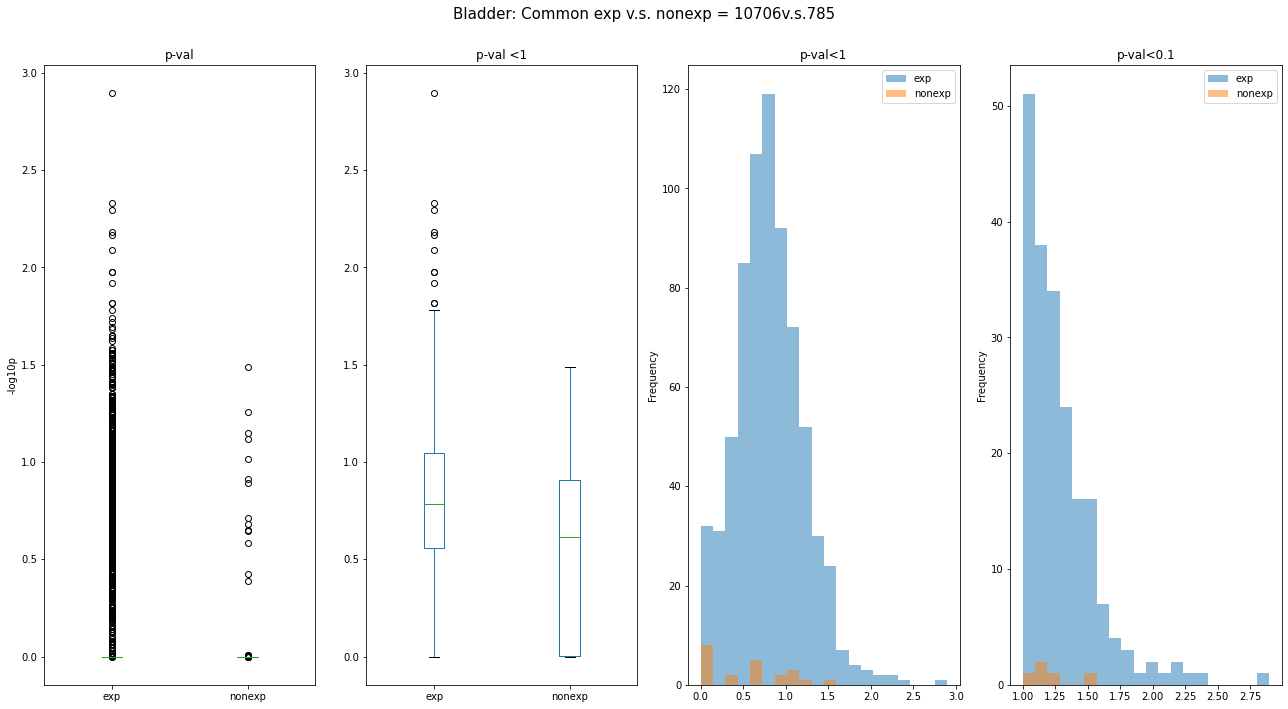

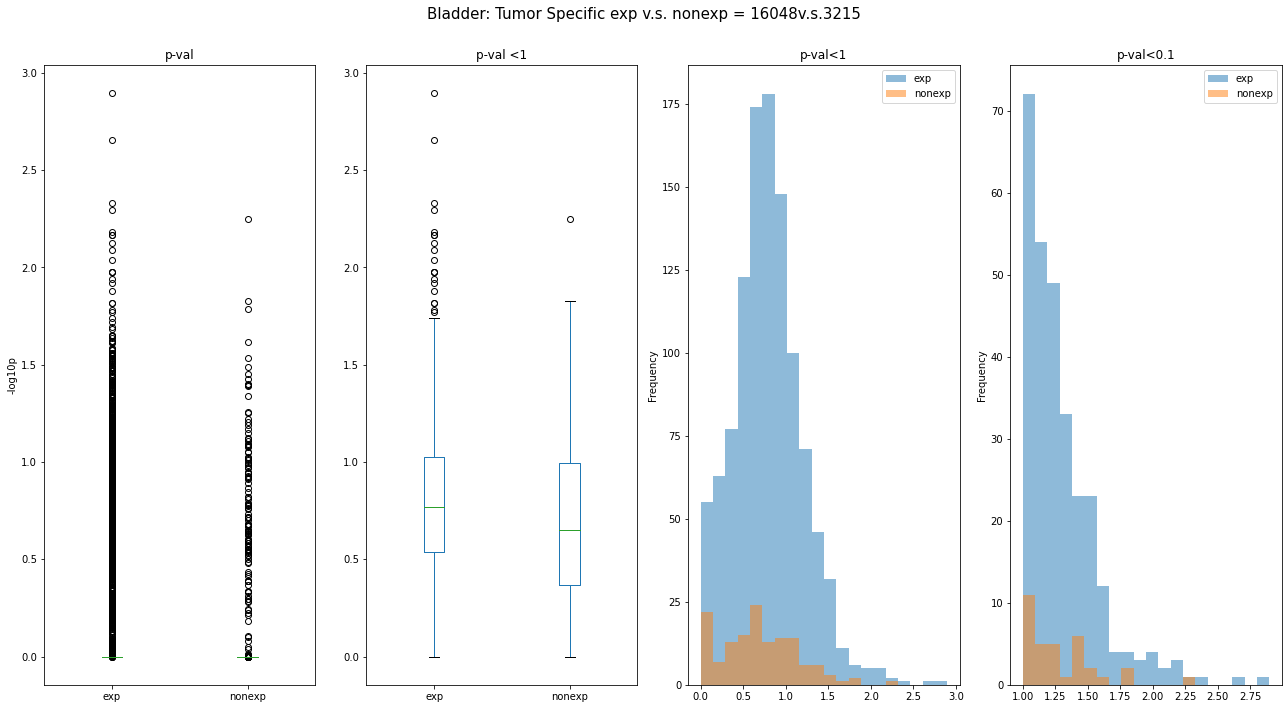

In [119]:
### Then map the p-vals in the sig gene files for common exp and nonexp genes
syn_dir = '../mutsig_out/syn/out10212020'
pdf = matplotlib.backends.backend_pdf.PdfPages("p-val_dist_common_&_tumor_specific.pdf")

for org in listdir(syn_dir):
    if not org.startswith('.') and not org == 'SoftTissue':
        org_dir = join(syn_dir,org)
        for f in listdir(org_dir):
            if f.endswith('sig_genes.txt'):
                f_dir = join(org_dir,f)
                df_org = pd.read_csv(f_dir,sep = '\t')
                df_org.loc[df_org['p']==0, 'p'] = 1e-30
                
                df_org_1 = df_org[df_org['p']<1]
                df_org_05 = df_org[df_org['p']<0.1]
                
                df_exp_p = -np.log10(df_org[df_org['gene'].isin(le)]['p'])
                df_nonexp_p = -np.log10(df_org[df_org['gene'].isin(lne)]['p'])
                
                df_exp_p_1 = -np.log10(df_org_1[df_org_1['gene'].isin(le)]['p'])
                df_nonexp_p_1 = -np.log10(df_org_1[df_org_1['gene'].isin(lne)]['p'])
                df_exp_p_05 = -np.log10(df_org_05[df_org_05['gene'].isin(le)]['p'])
                df_nonexp_p_05 = -np.log10(df_org_05[df_org_05['gene'].isin(lne)]['p'])
                

                df_p = pd.concat([df_exp_p,df_nonexp_p],ignore_index=True, axis=1 )
                df_p_1 = pd.concat([df_exp_p_1,df_nonexp_p_1],ignore_index=True, axis=1 )
                df_p_05 = pd.concat([df_exp_p_05,df_nonexp_p_05],ignore_index=True, axis=1 )
                df_p.columns = ['exp','nonexp']
                df_p_1.columns = ['exp','nonexp']
                df_p_05.columns = ['exp','nonexp']
                
                fig, axes = plt.subplots(nrows=1, ncols=4,figsize=(18,10))
                
                df_p.plot.box(ax = axes[0])
                axes[0].set(title = 'p-val', ylabel = '-log10p')
                df_p_1.plot.box(ax = axes[1])
                axes[1].set(title = 'p-val <1')

                df_p_1.plot.hist(alpha=0.5, bins = 20,ax = axes[2]);
                axes[2].set(title = 'p-val<1')
                df_p_05.plot.hist(alpha=0.5, bins = 20,ax = axes[3]);
                axes[3].set(title = 'p-val<0.1')
                
                plt.tight_layout()
                fig.suptitle(org + ': Common exp v.s. nonexp = '+str(len(le)) + 'v.s.' + str(len(lne)),fontsize =15)
                fig.subplots_adjust(top=0.9)
                pdf.savefig( fig )
                
#                 ### Strict expressed and nonexpressed
#                 df_exp_p = -np.log10(df_org[df_org['gene'].isin(lse)]['p'])
#                 df_nonexp_p = -np.log10(df_org[df_org['gene'].isin(lne)]['p'])
                
#                 df_exp_p_1 = -np.log10(df_org_1[df_org_1['gene'].isin(lse)]['p'])
#                 df_nonexp_p_1 = -np.log10(df_org_1[df_org_1['gene'].isin(lne)]['p'])
#                 df_exp_p_05 = -np.log10(df_org_05[df_org_05['gene'].isin(lse)]['p'])
#                 df_nonexp_p_05 = -np.log10(df_org_05[df_org_05['gene'].isin(lne)]['p'])
                

#                 df_p = pd.concat([df_exp_p,df_nonexp_p],ignore_index=True, axis=1 )
#                 df_p_1 = pd.concat([df_exp_p_1,df_nonexp_p_1],ignore_index=True, axis=1 )
#                 df_p_05 = pd.concat([df_exp_p_05,df_nonexp_p_05],ignore_index=True, axis=1 )
#                 df_p.columns = ['exp','nonexp']
#                 df_p_1.columns = ['exp','nonexp']
#                 df_p_05.columns = ['exp','nonexp']
                
#                 fig, axes = plt.subplots(nrows=1, ncols=4,figsize=(18,10))
                
#                 df_p.plot.box(ax = axes[0])
#                 axes[0].set(title = 'p-val', ylabel = '-log10p')
#                 df_p_1.plot.box(ax = axes[1])
#                 axes[1].set(title = 'p-val <1')

#                 df_p_1.plot.hist(alpha=0.5, bins = 20,ax = axes[2]);
#                 axes[2].set(title = 'p-val<1')
#                 df_p_05.plot.hist(alpha=0.5, bins = 20,ax = axes[3]);
#                 axes[3].set(title = 'p-val<0.1')
                
#                 plt.tight_layout()
#                 fig.suptitle(org + ': Strict exp(FPKM-UQ >5) v.s. nonexp(FPKM-UQ<0.5) = '+str(len(lse)) + 'v.s.' + str(len(lne)),fontsize =15)
#                 fig.subplots_adjust(top=0.9)
#                 pdf.savefig( fig )
                
                ### Tumor specific
                
                df_exp_p = -np.log10(df_org[df_org['gene'].isin(df_exp_gene[org])]['p'])
                df_nonexp_p = -np.log10(df_org[df_org['gene'].isin(df_nonexp_gene[org])]['p'])
                
                df_exp_p_1 = -np.log10(df_org_1[df_org_1['gene'].isin(df_exp_gene[org])]['p'])
                df_nonexp_p_1 = -np.log10(df_org_1[df_org_1['gene'].isin(df_nonexp_gene[org])]['p'])
                df_exp_p_05 = -np.log10(df_org_05[df_org_05['gene'].isin(df_exp_gene[org])]['p'])
                df_nonexp_p_05 = -np.log10(df_org_05[df_org_05['gene'].isin(df_nonexp_gene[org])]['p'])
                

                df_p = pd.concat([df_exp_p,df_nonexp_p],ignore_index=True, axis=1 )
                df_p_1 = pd.concat([df_exp_p_1,df_nonexp_p_1],ignore_index=True, axis=1 )
                df_p_05 = pd.concat([df_exp_p_05,df_nonexp_p_05],ignore_index=True, axis=1 )
                df_p.columns = ['exp','nonexp']
                df_p_1.columns = ['exp','nonexp']
                df_p_05.columns = ['exp','nonexp']
                
                fig, axes = plt.subplots(nrows=1, ncols=4,figsize=(18,10))
                
                df_p.plot.box(ax = axes[0])
                axes[0].set(title = 'p-val', ylabel = '-log10p')
                df_p_1.plot.box(ax = axes[1])
                axes[1].set(title = 'p-val <1')

                df_p_1.plot.hist(alpha=0.5, bins = 20,ax = axes[2]);
                axes[2].set(title = 'p-val<1')
                df_p_05.plot.hist(alpha=0.5, bins = 20,ax = axes[3]);
                axes[3].set(title = 'p-val<0.1')

#                 df_p.plot.hist(alpha=0.5, bins = 20,ax = axes[1]);
#                 df = df_p.melt(var_name='groups', value_name='vals')
#                 sns.violinplot(x="groups", y="vals", data=df,ax = axes[2])
#                 axes[2].set(ylim=(0, 0.5))
#                 axes[2].set(title="Violinplot of p-val")
                
                plt.tight_layout()
                fig.suptitle(org + ': Tumor Specific exp v.s. nonexp = '+str(len(df_exp_gene[org].dropna())) + 'v.s.' + str(len(df_nonexp_gene[org].dropna())),fontsize =15)
                fig.subplots_adjust(top=0.9)
                pdf.savefig( fig )
                
                
pdf.close()

<ipython-input-45-c3e2b2e3b3d5>:33: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrows=1, ncols=4,figsize=(20,12))


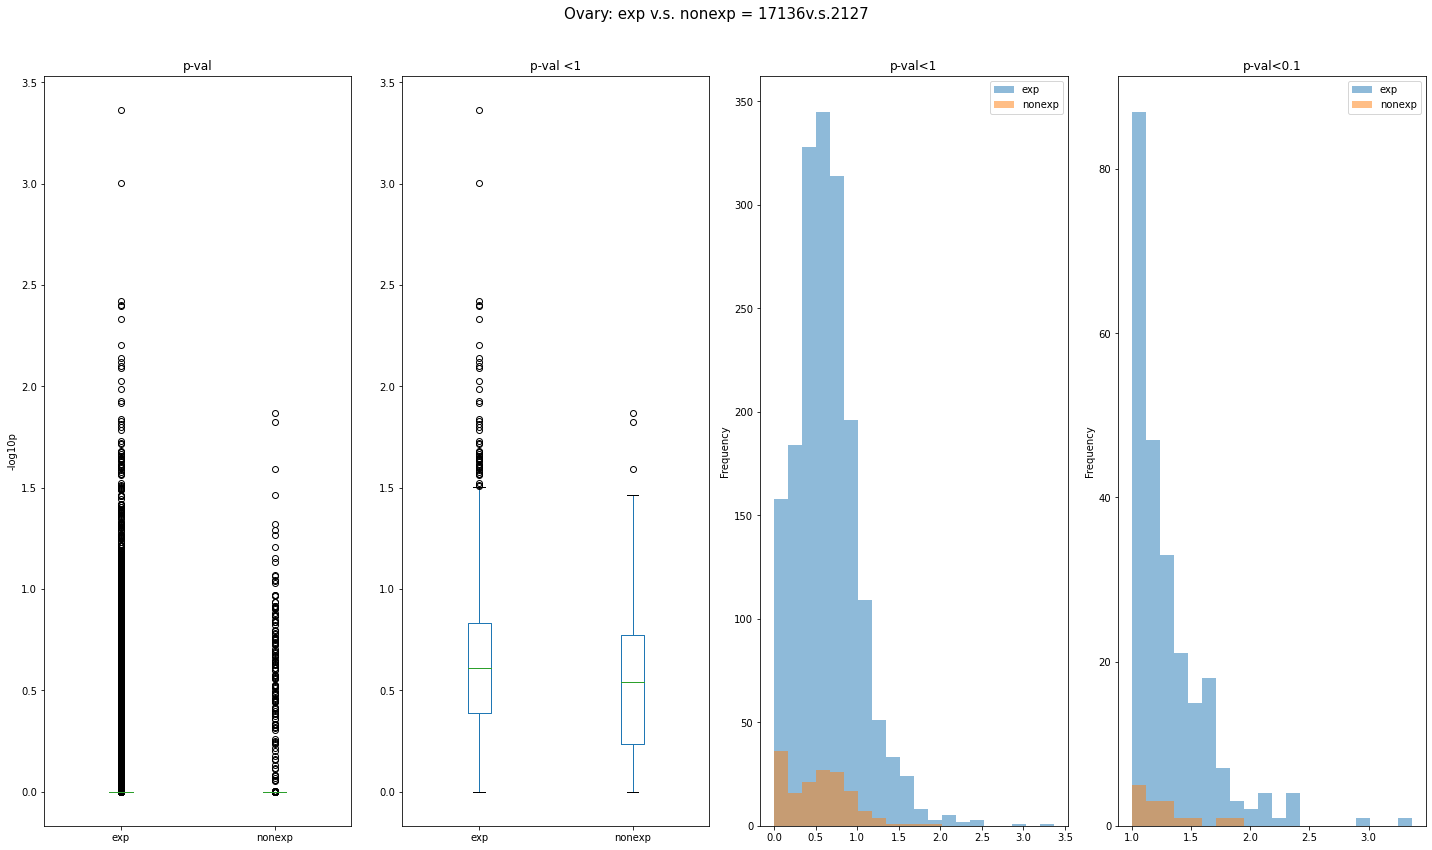

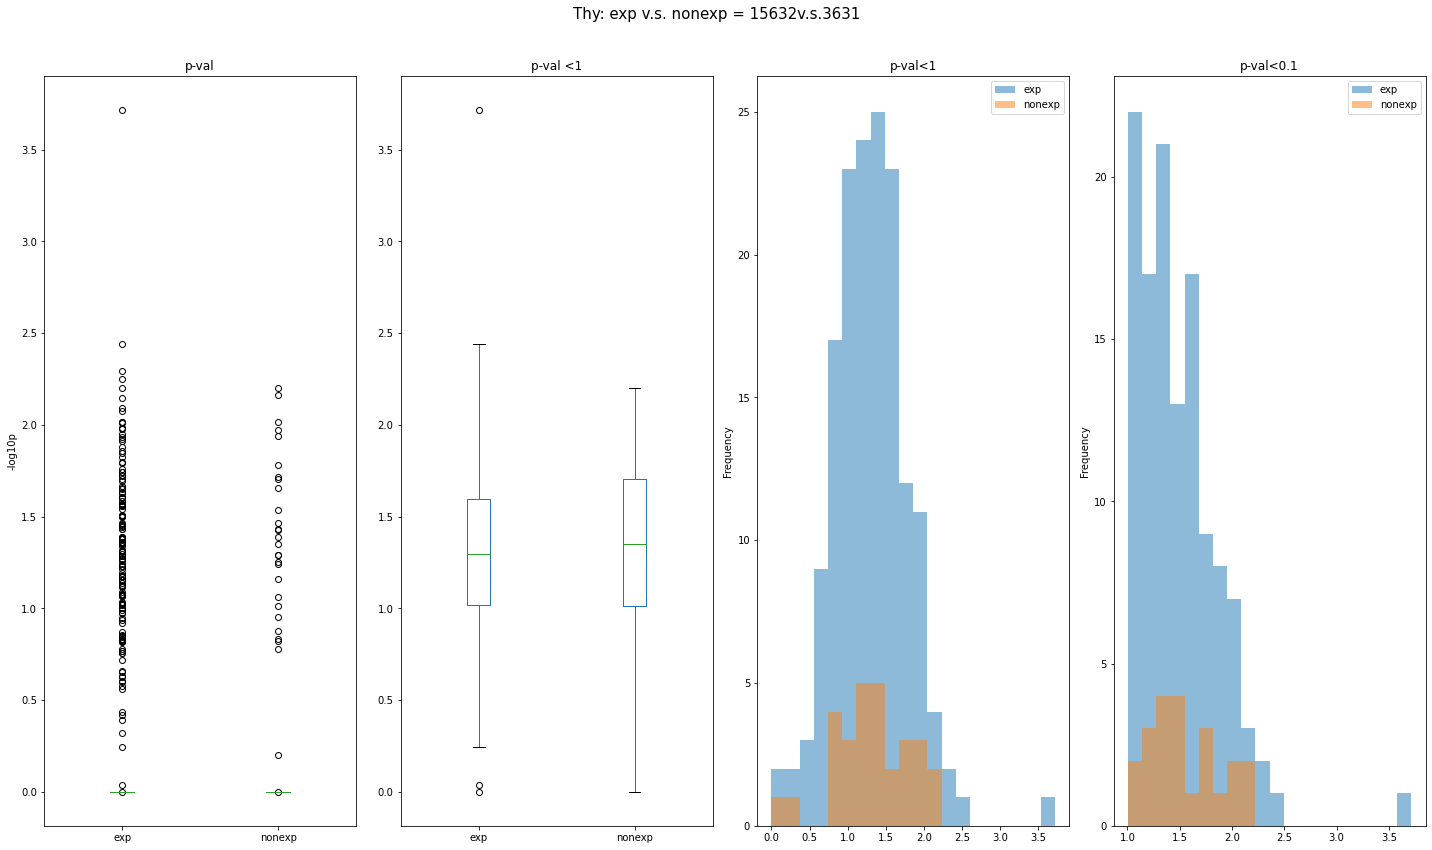

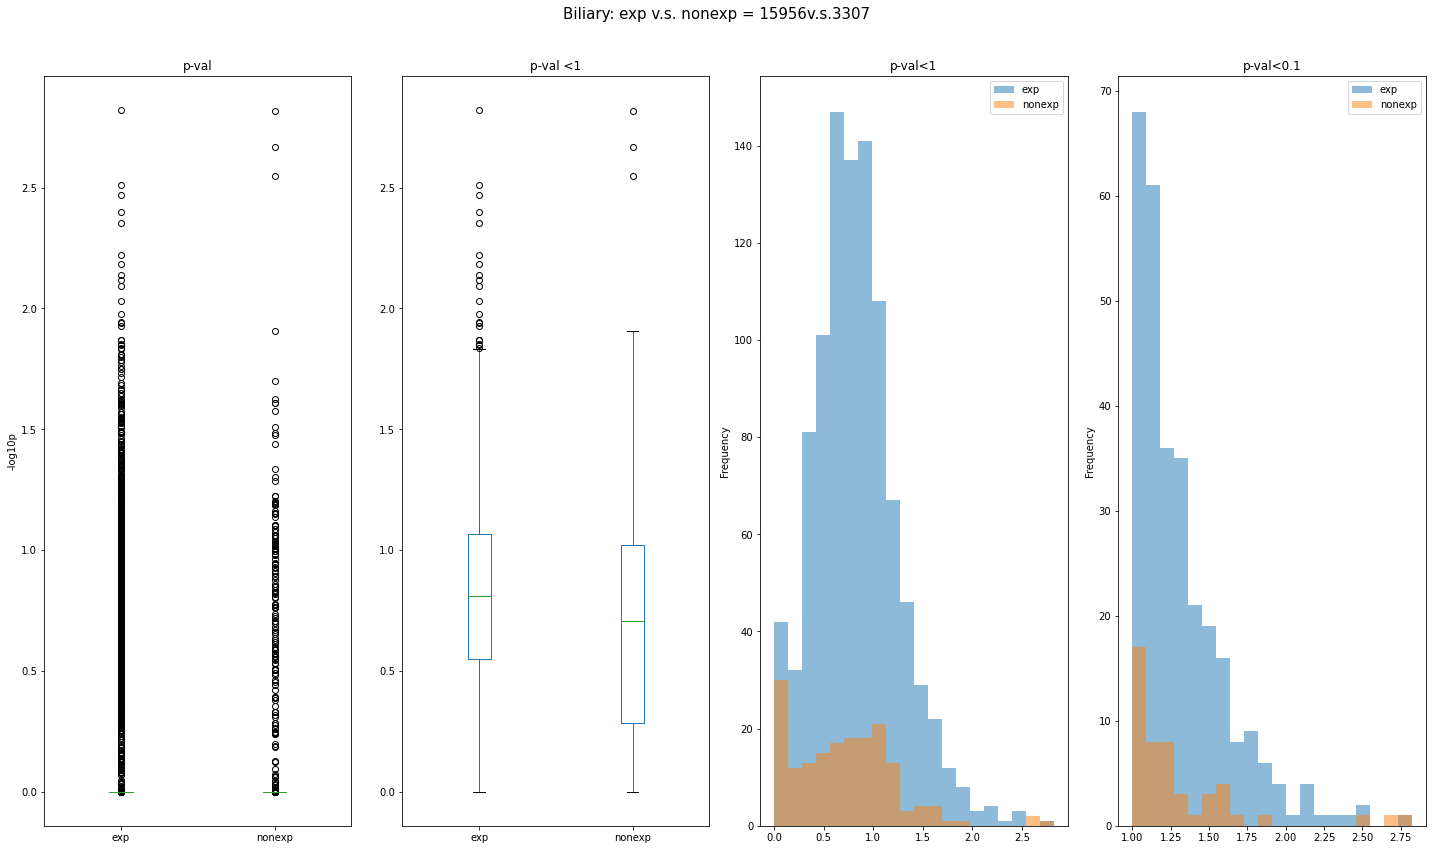

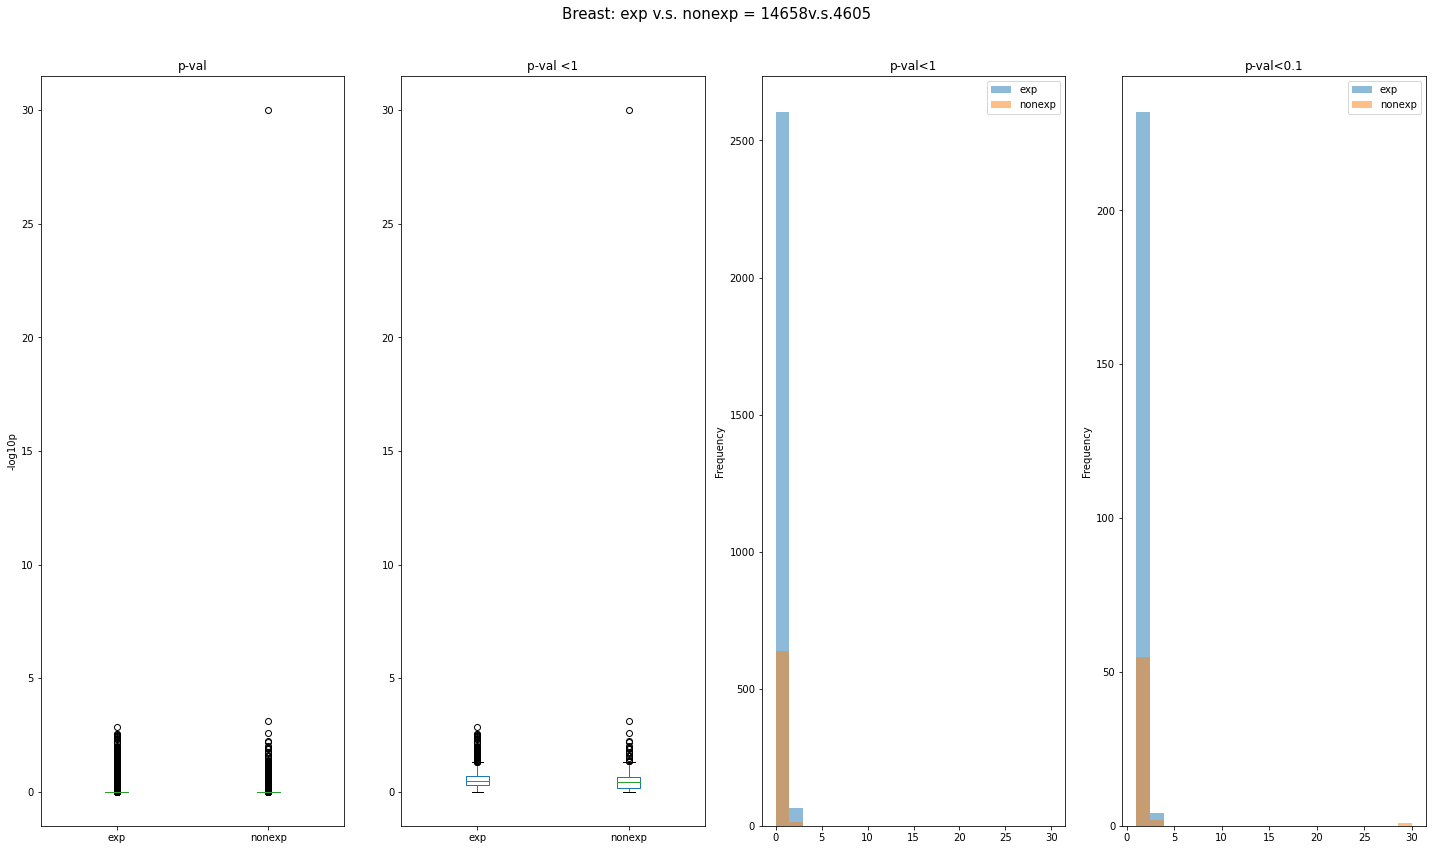

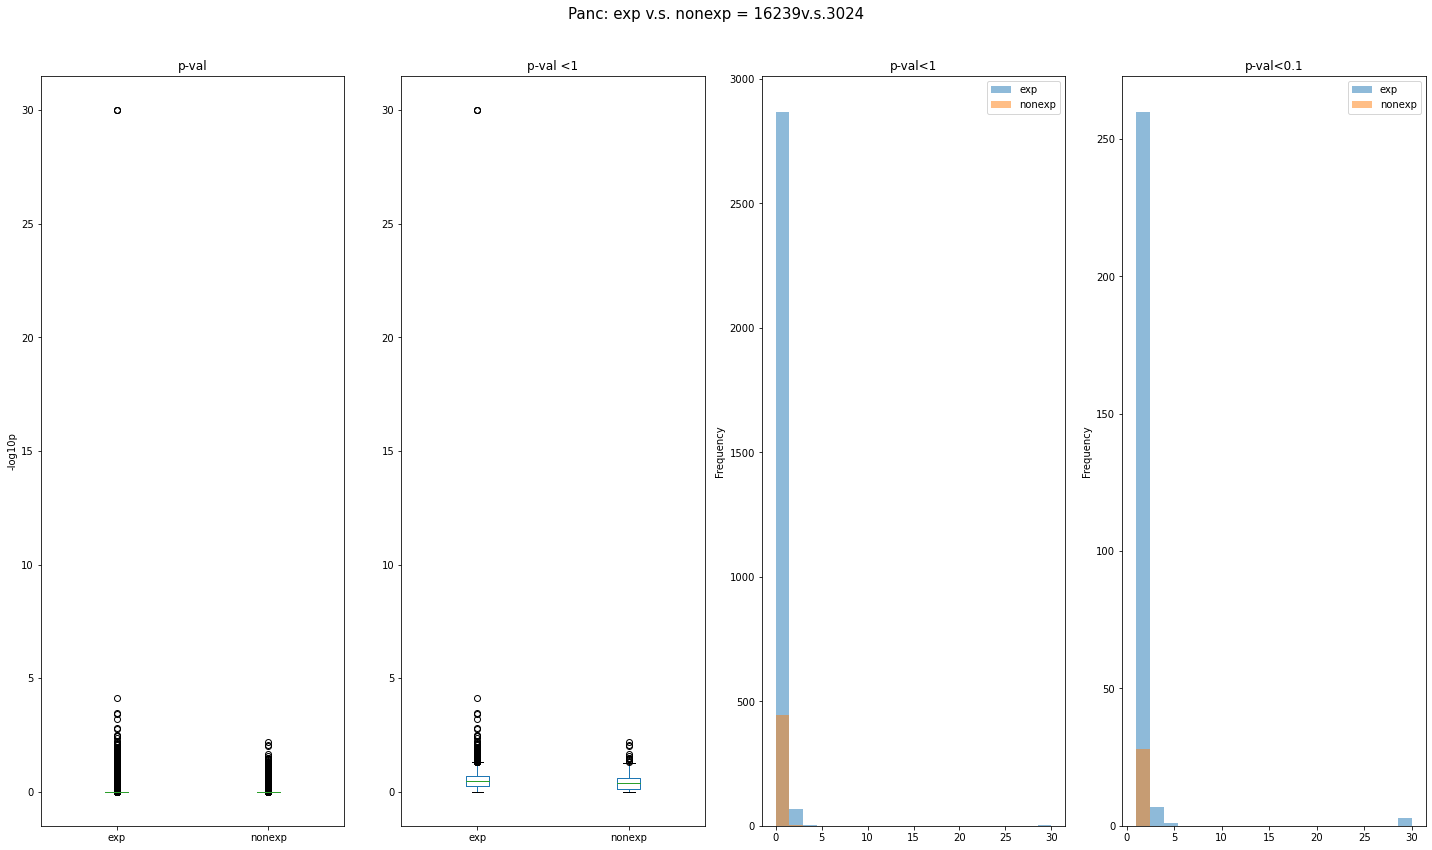

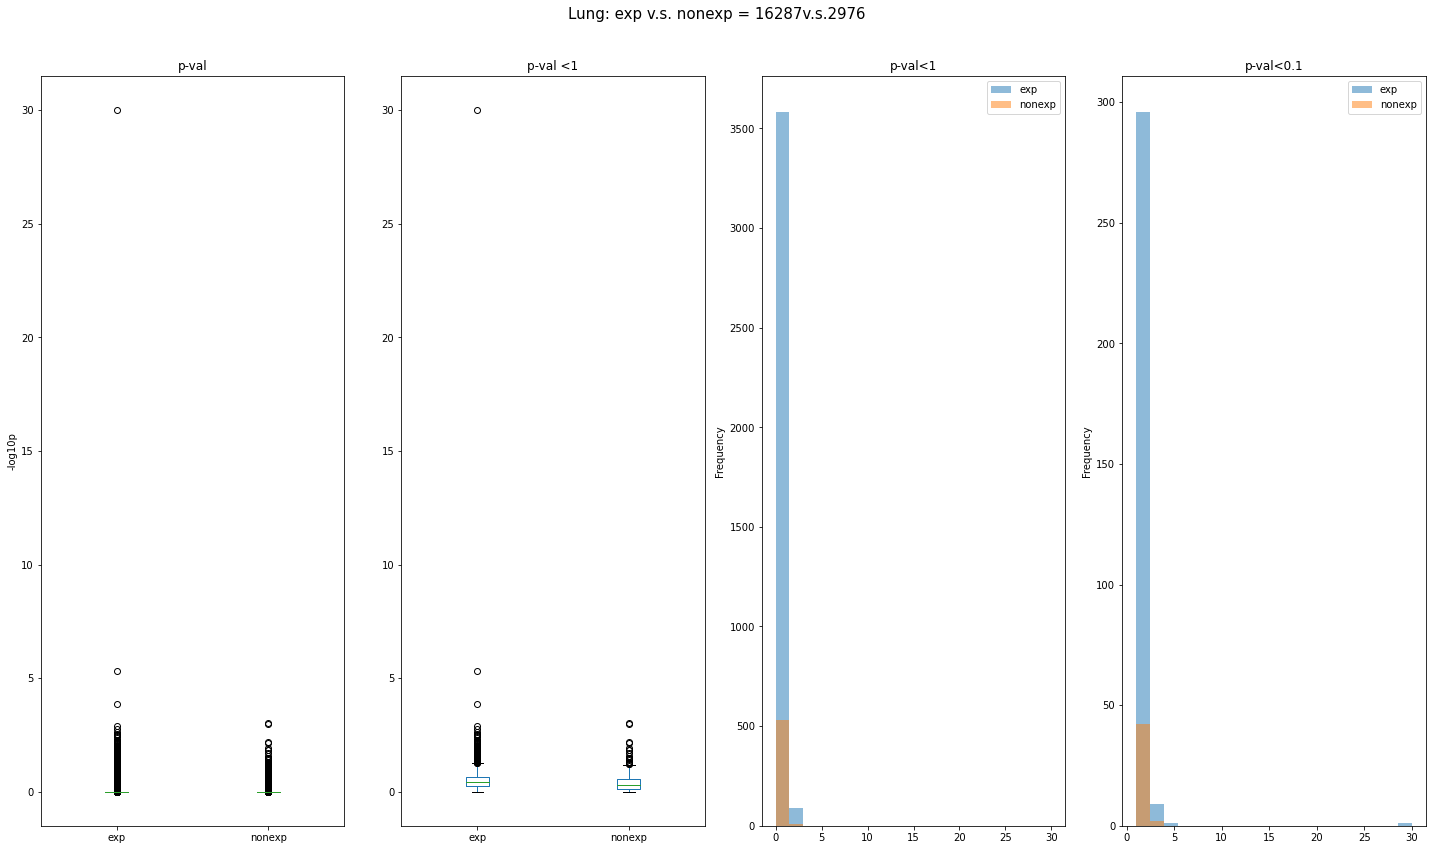

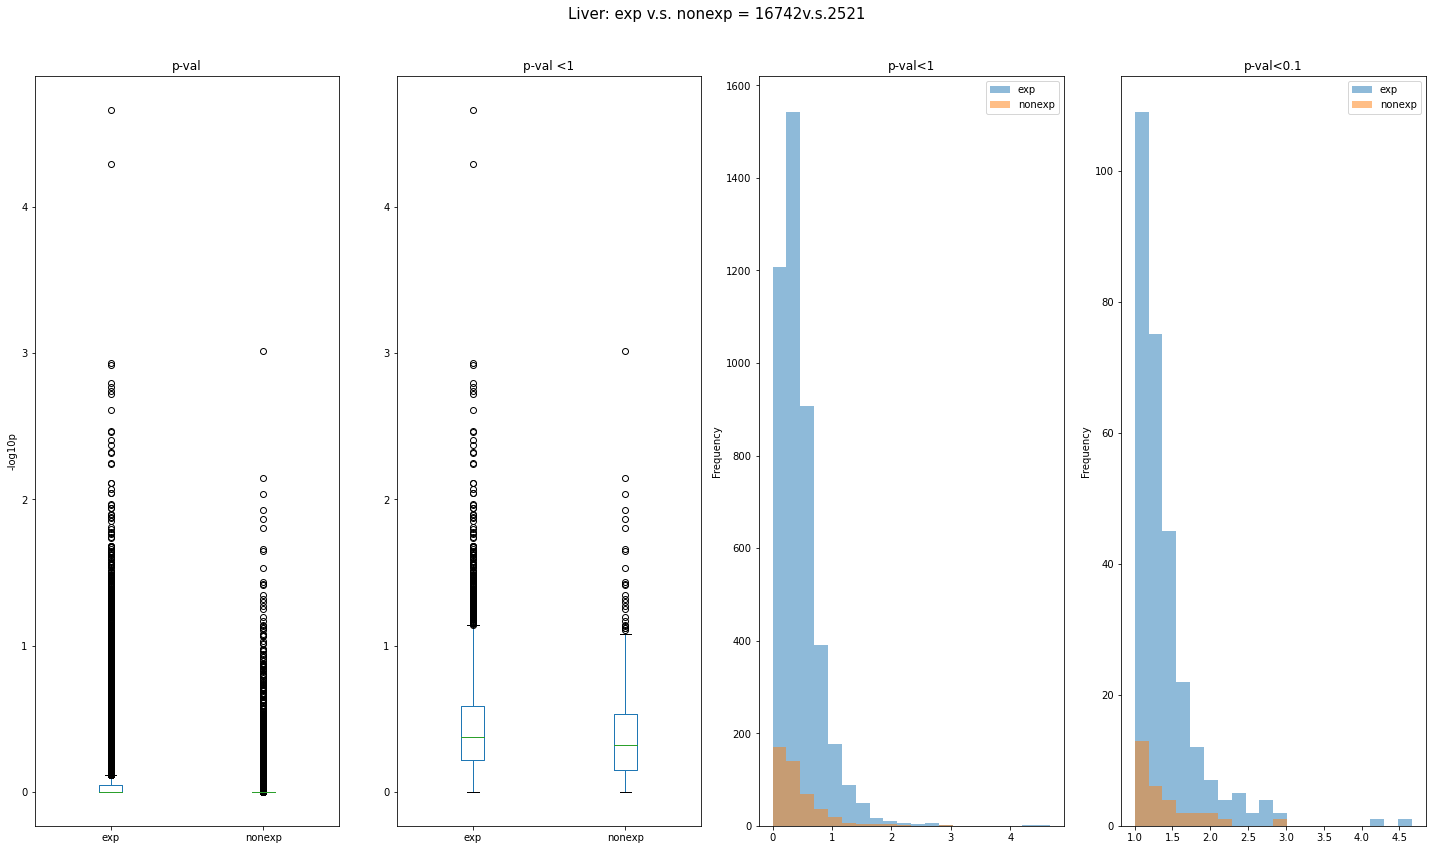

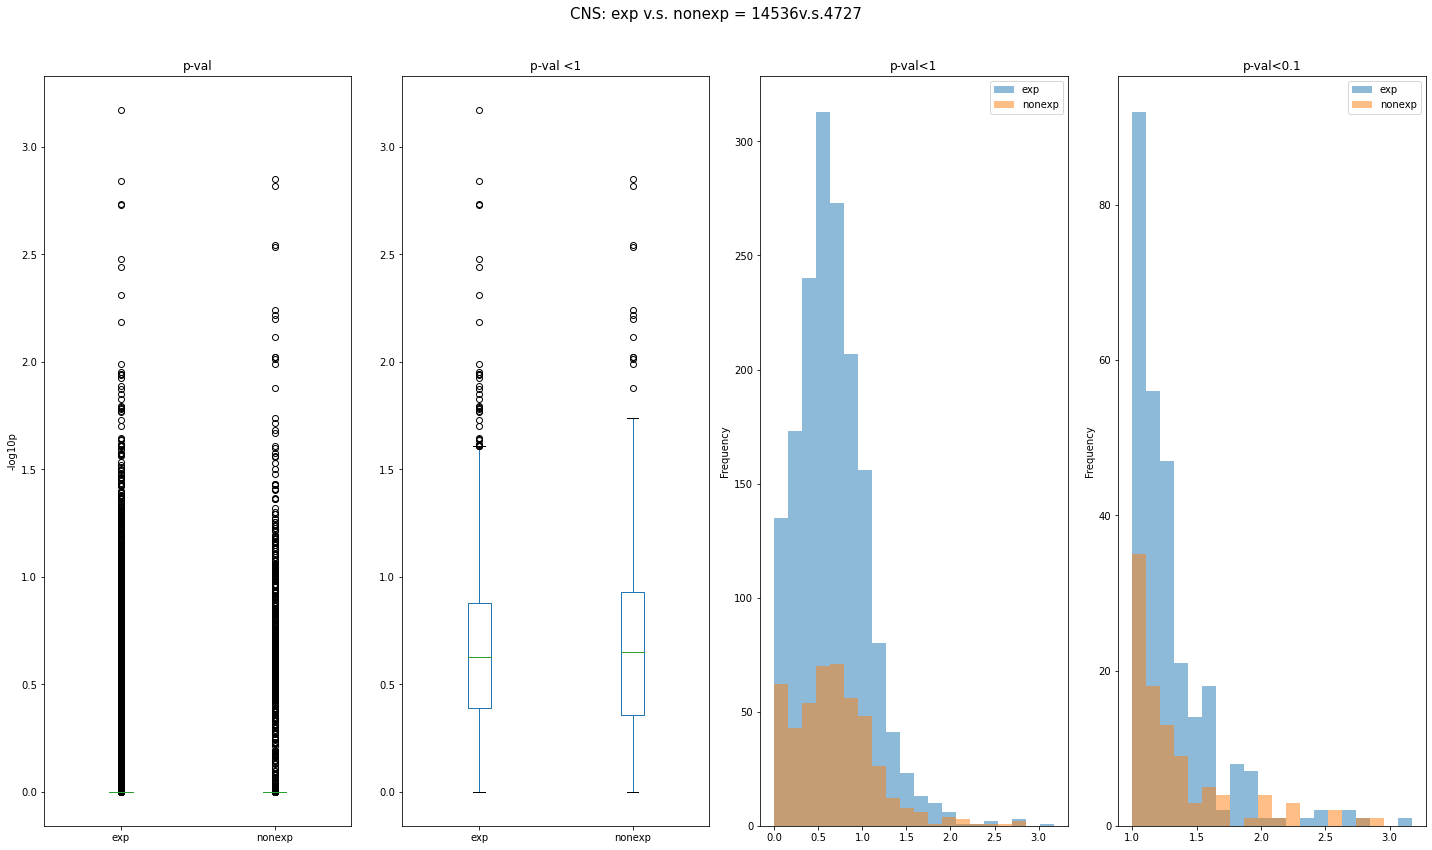

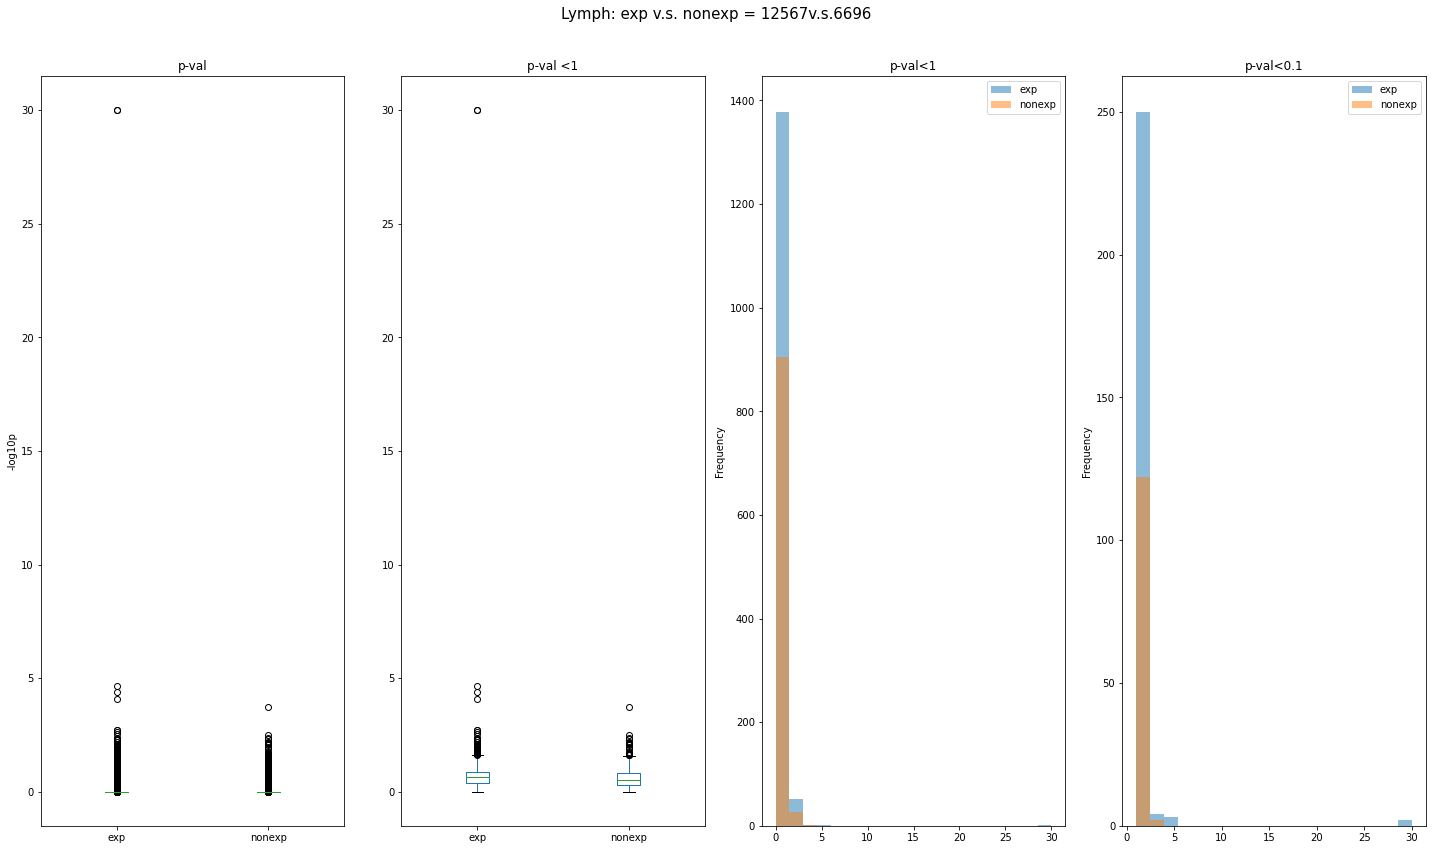

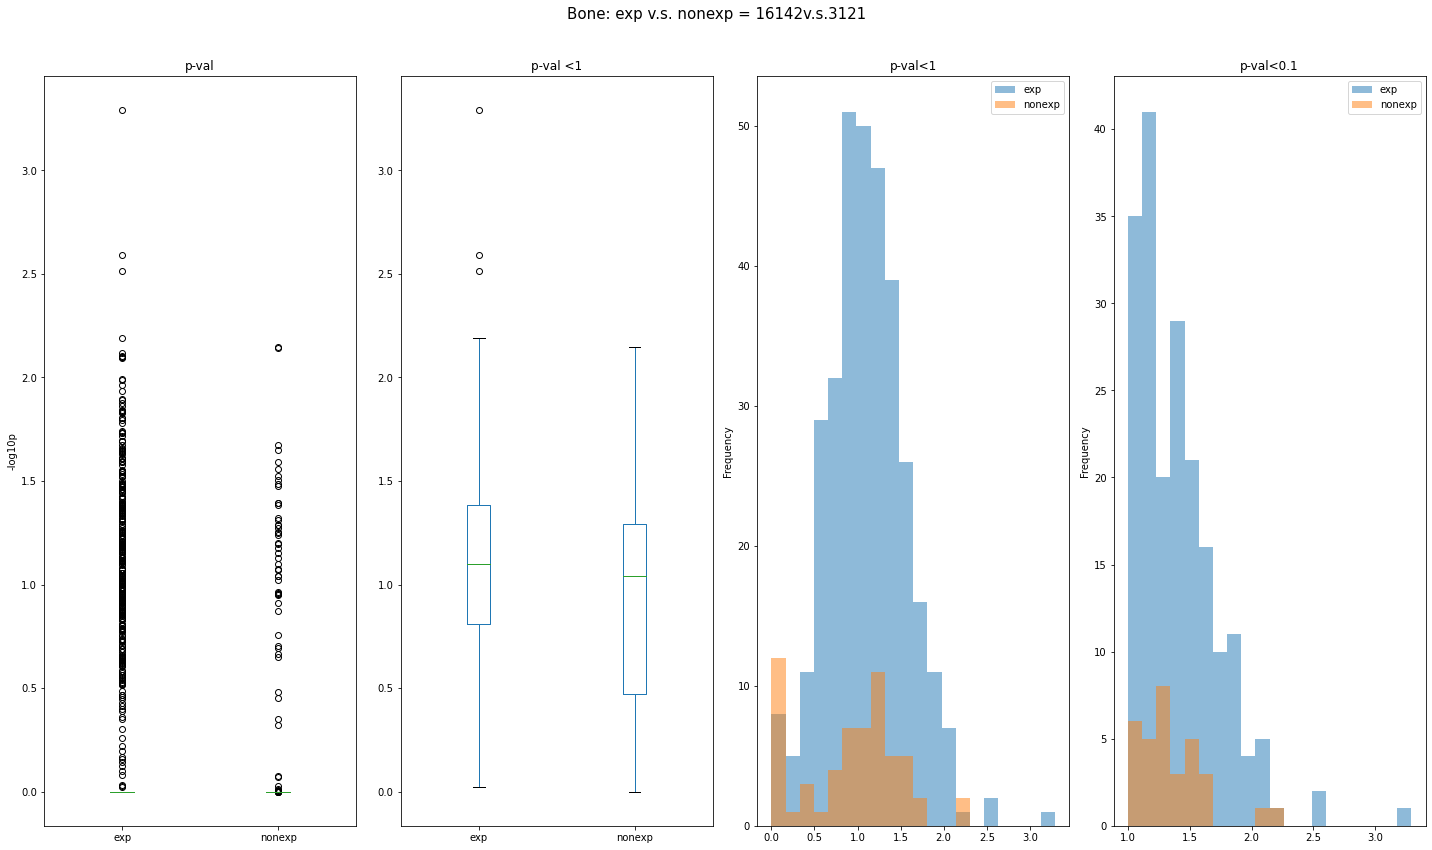

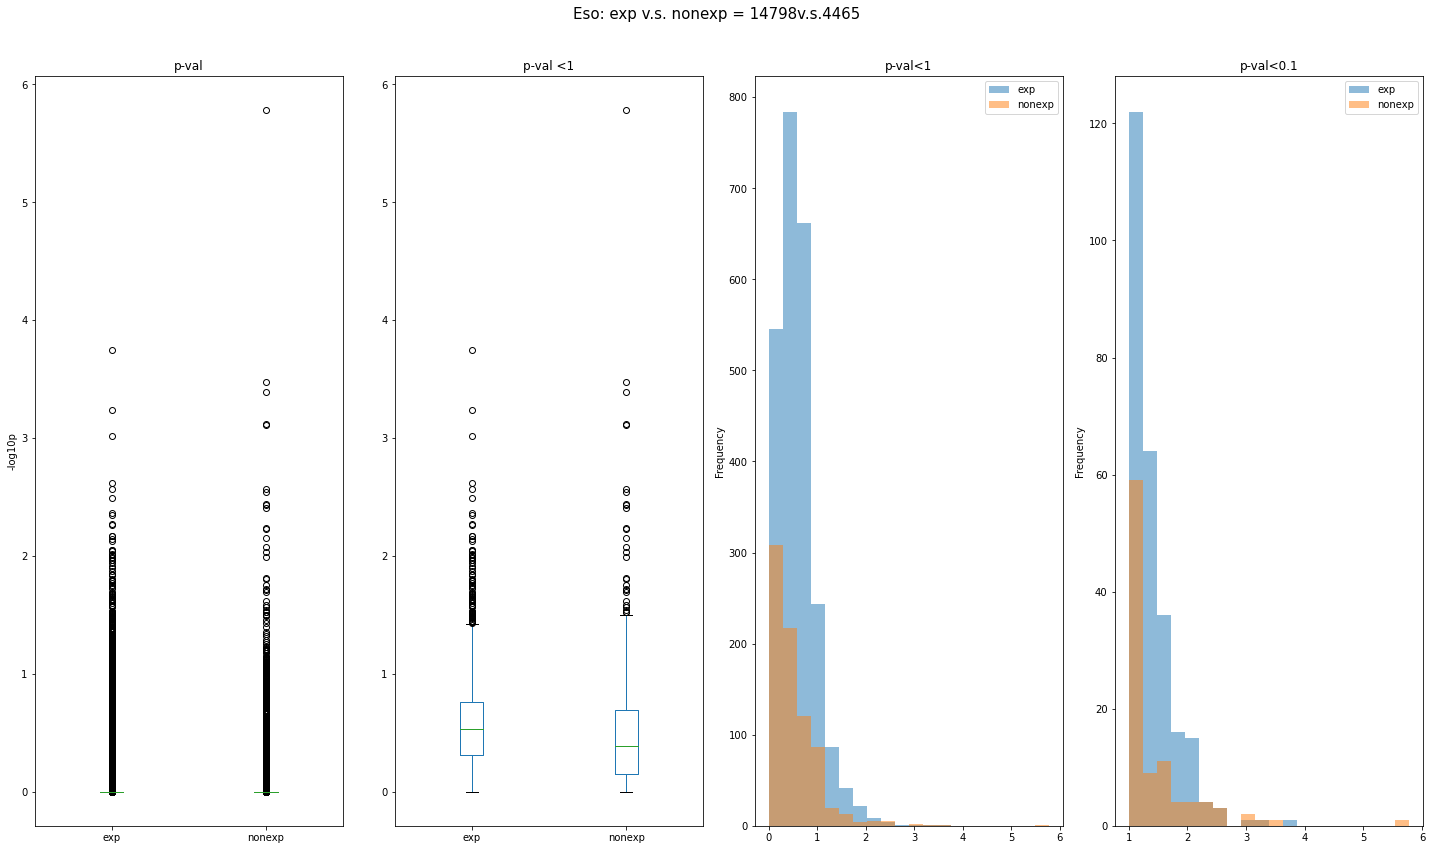

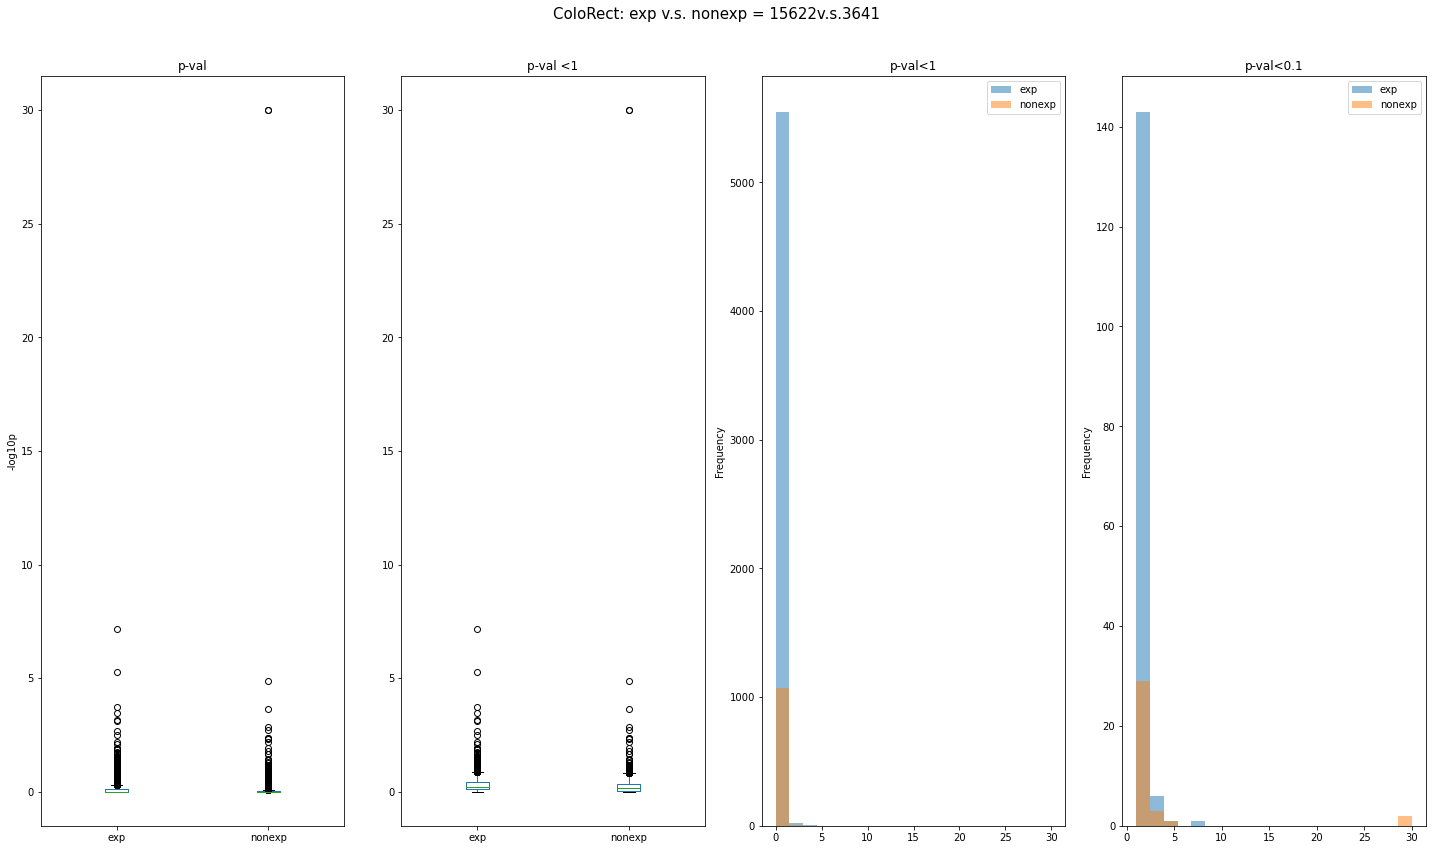

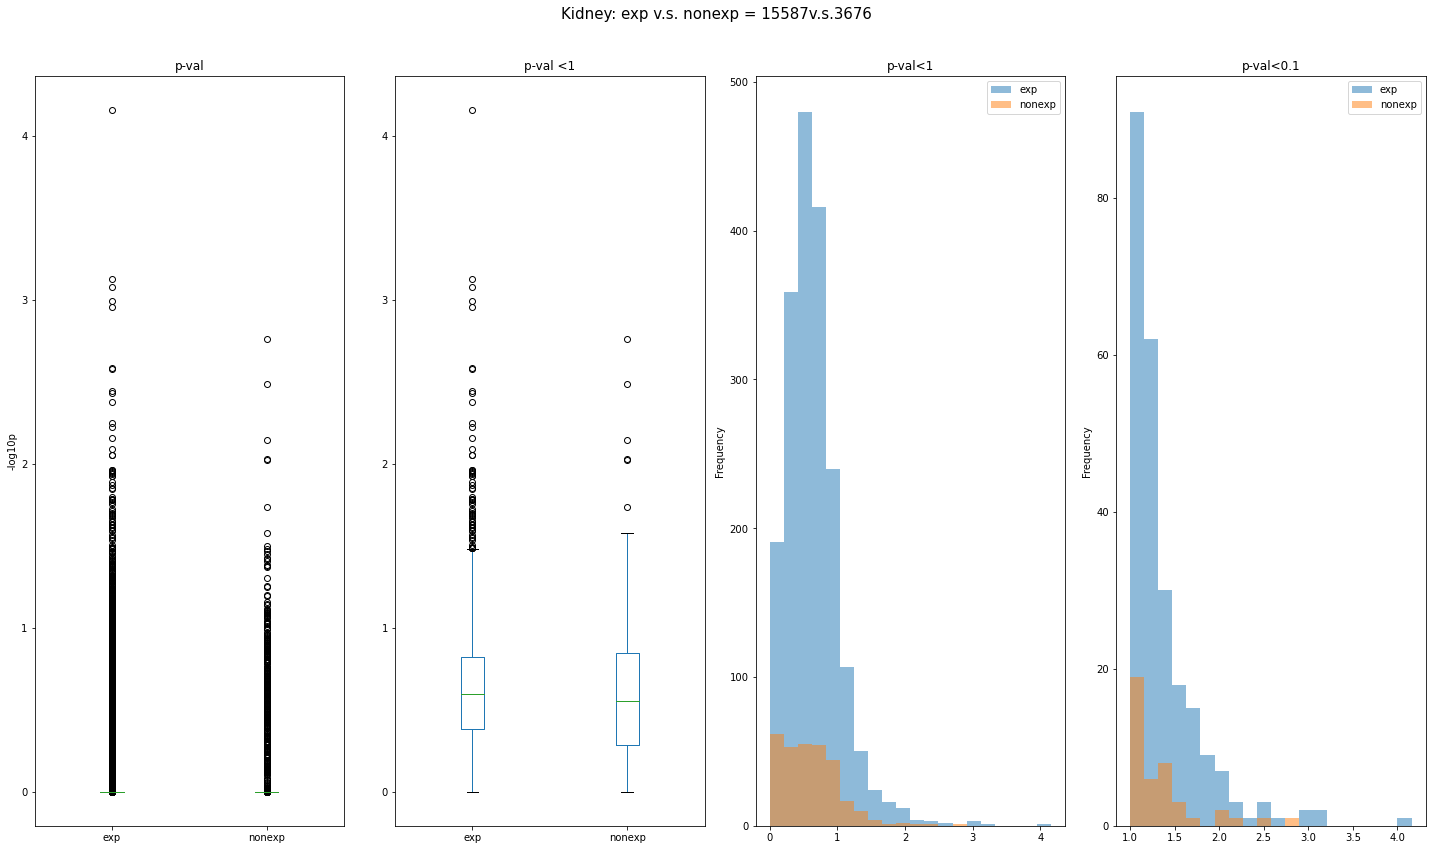

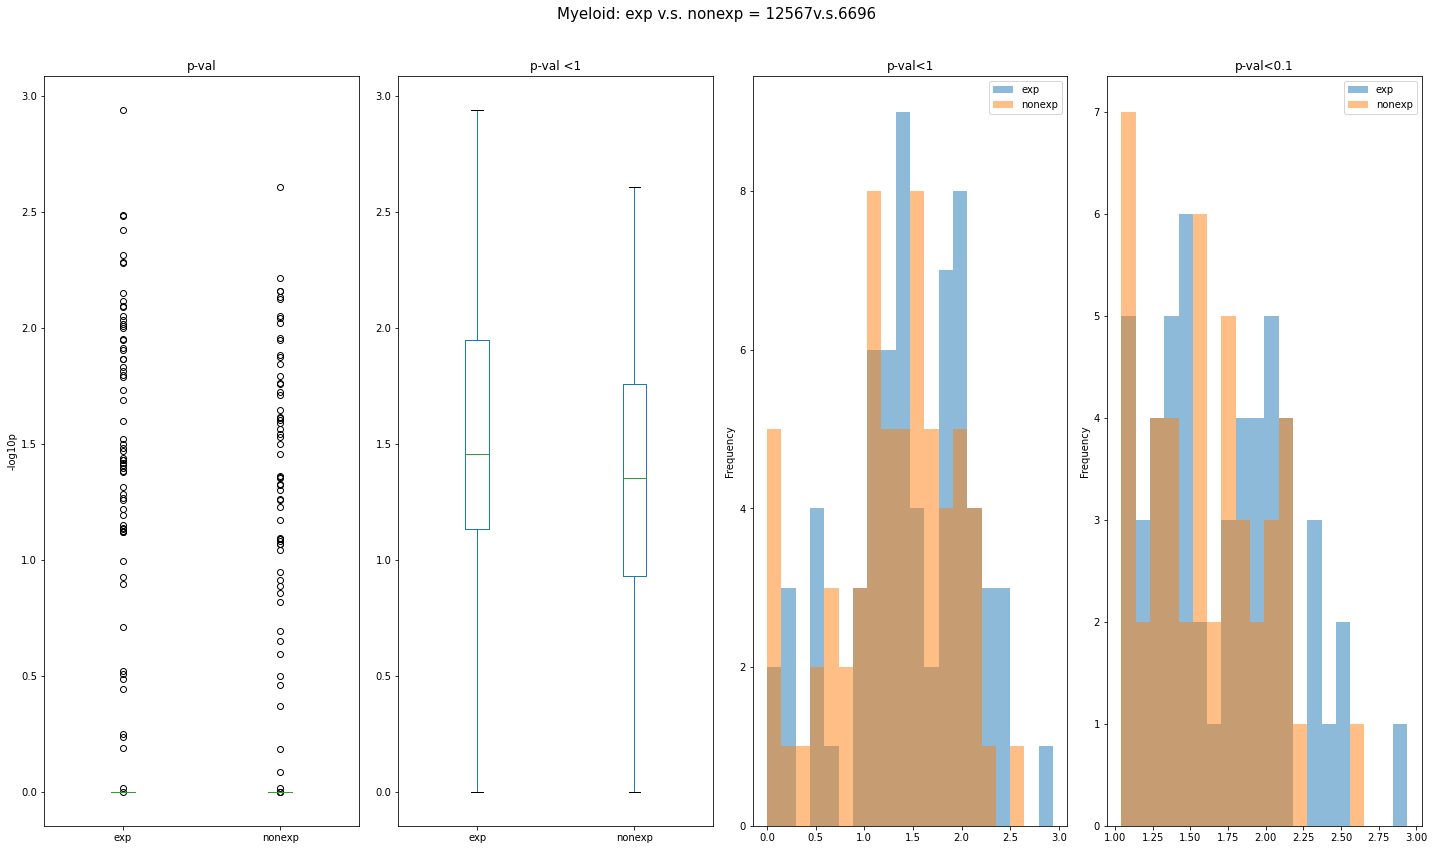

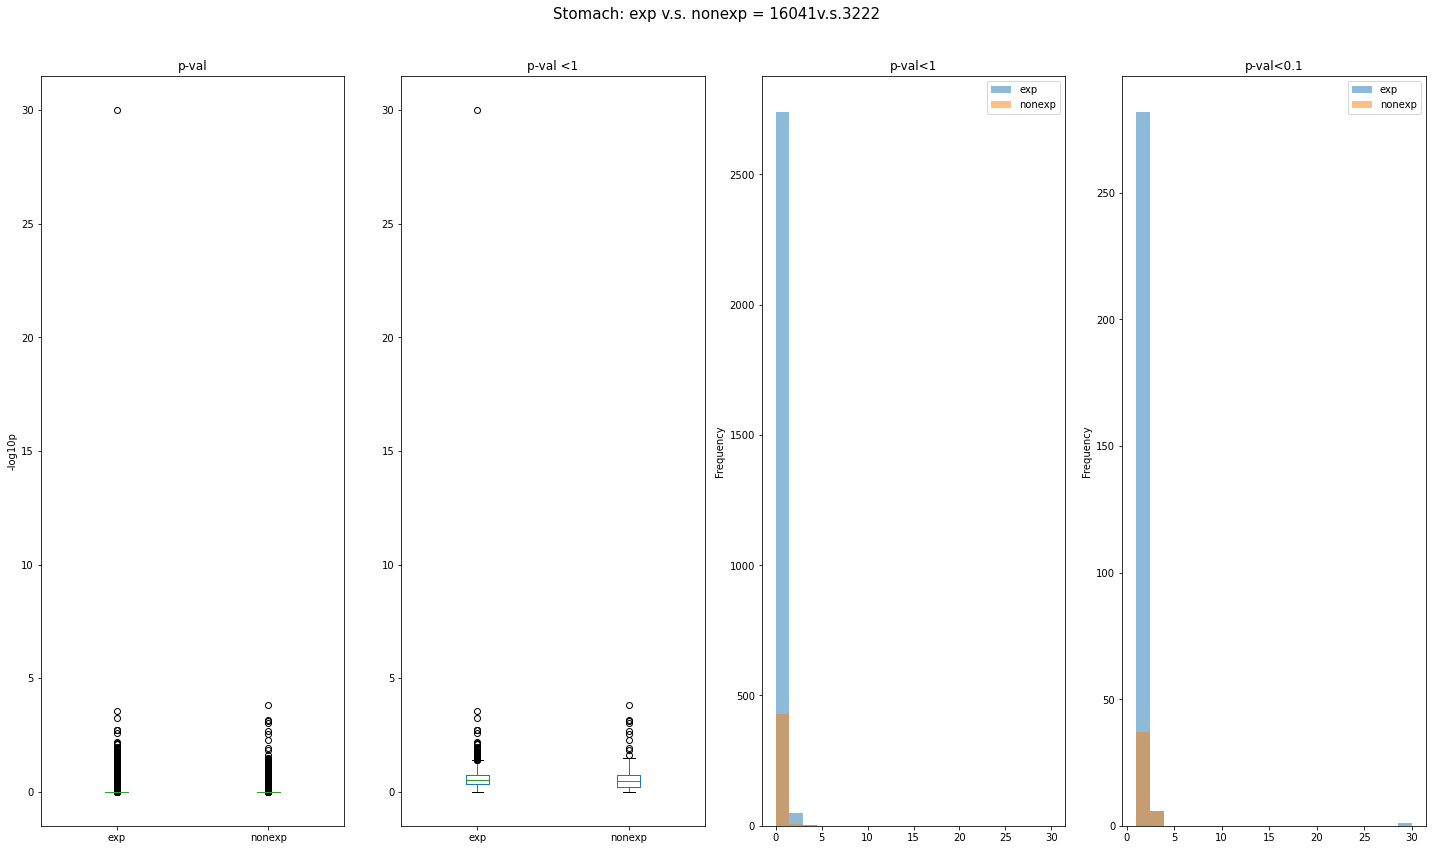

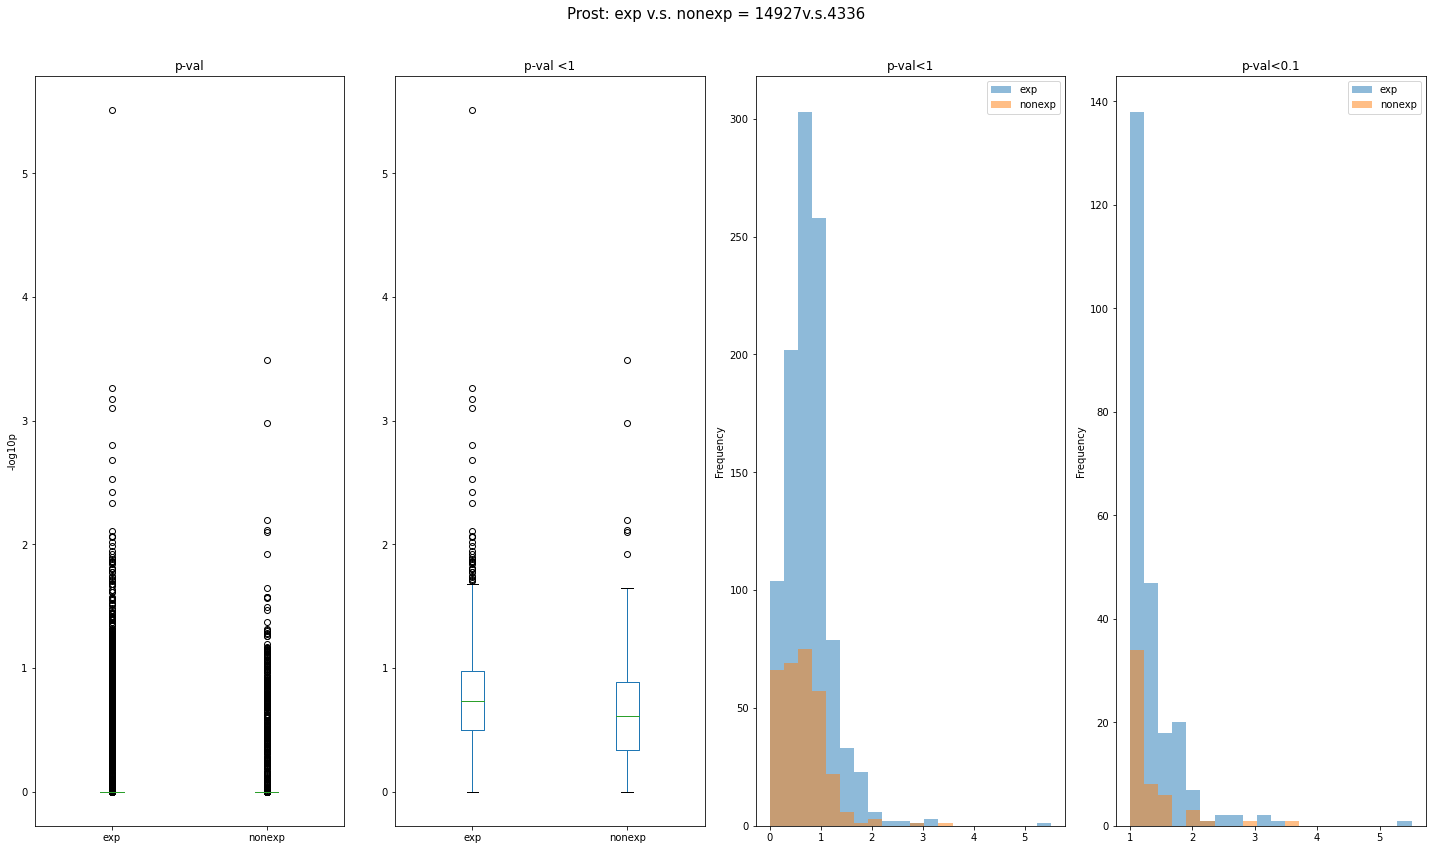

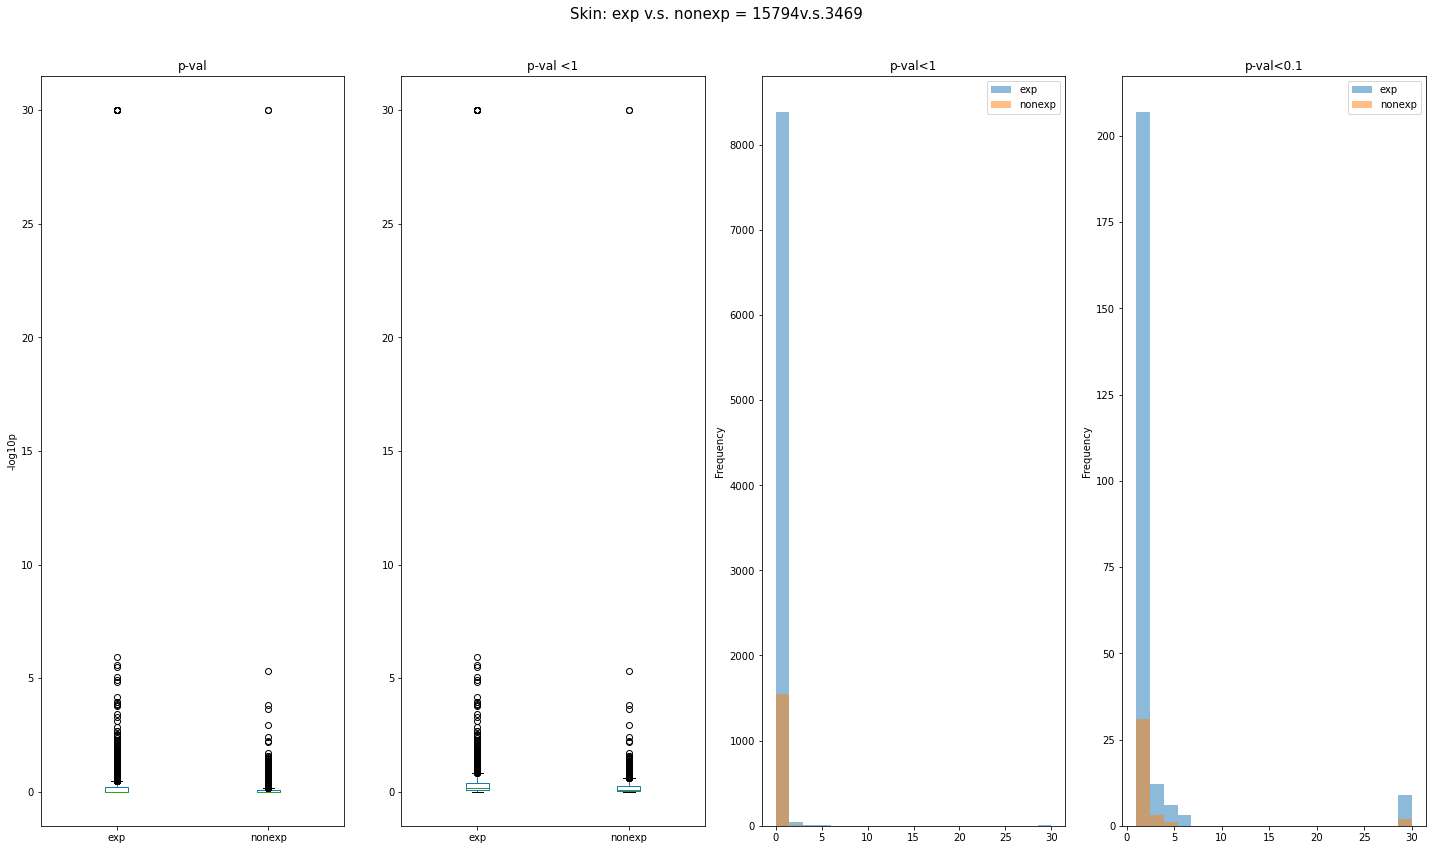

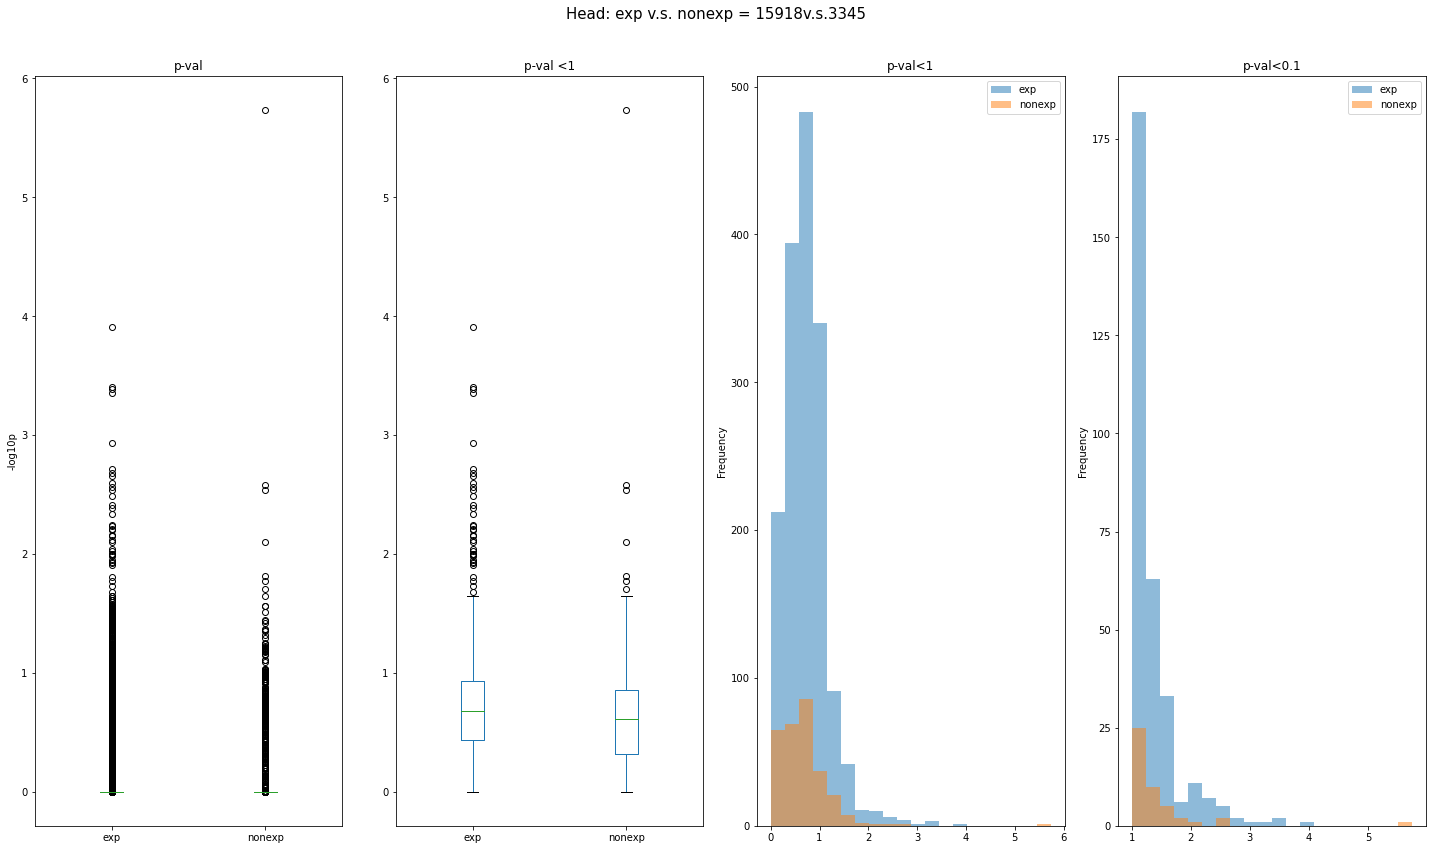

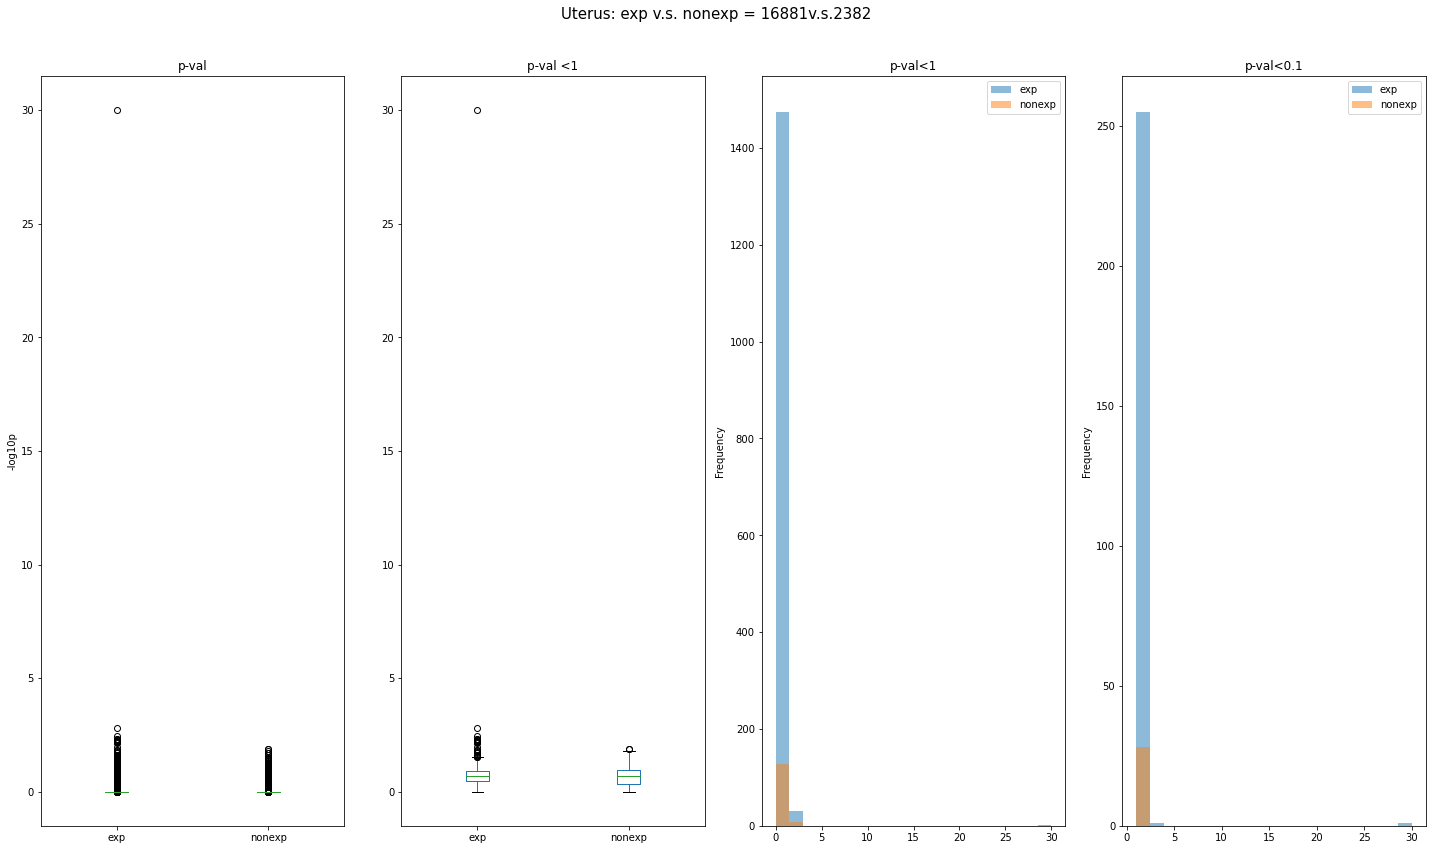

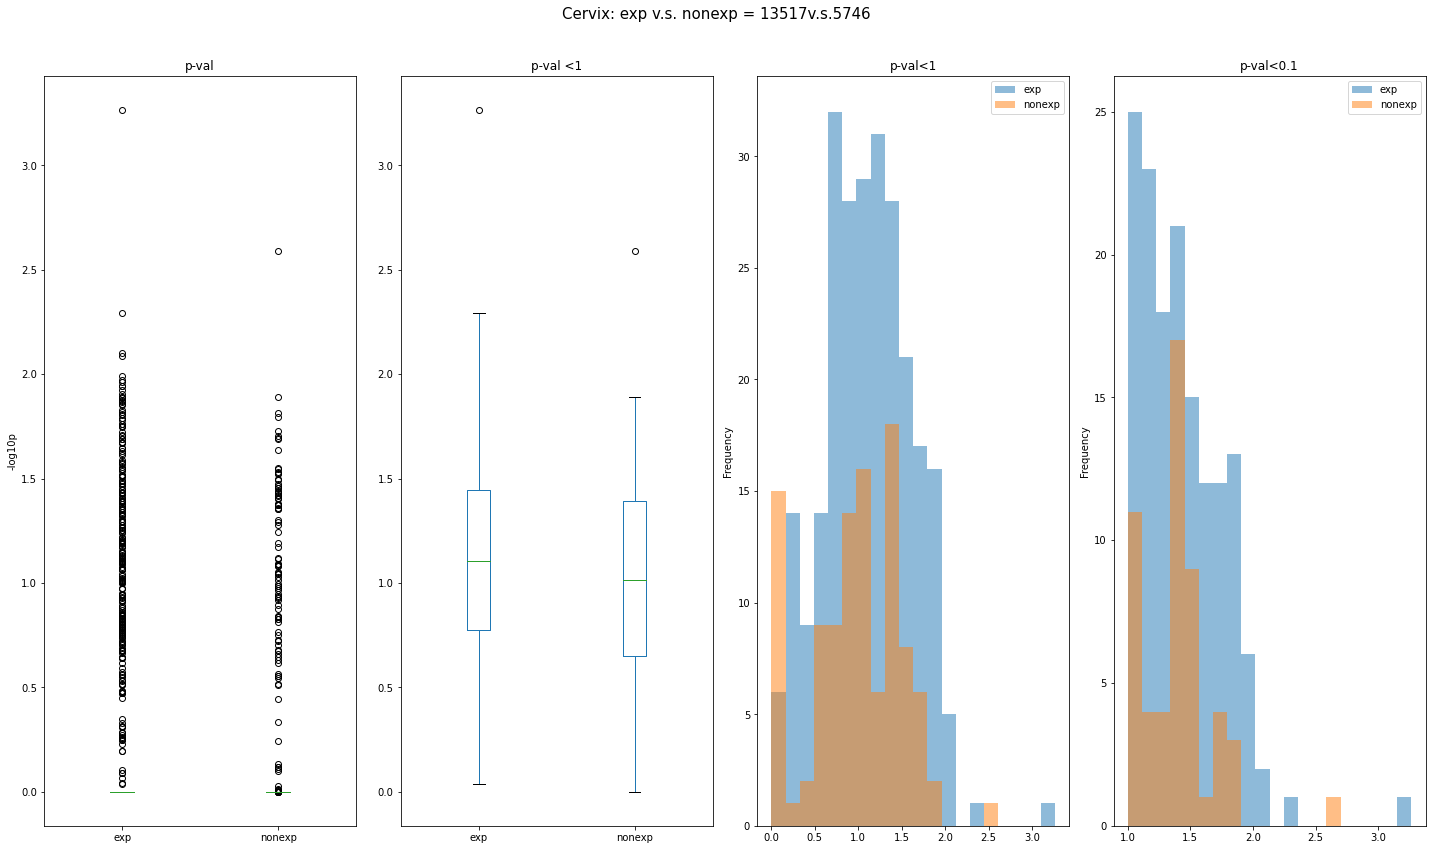

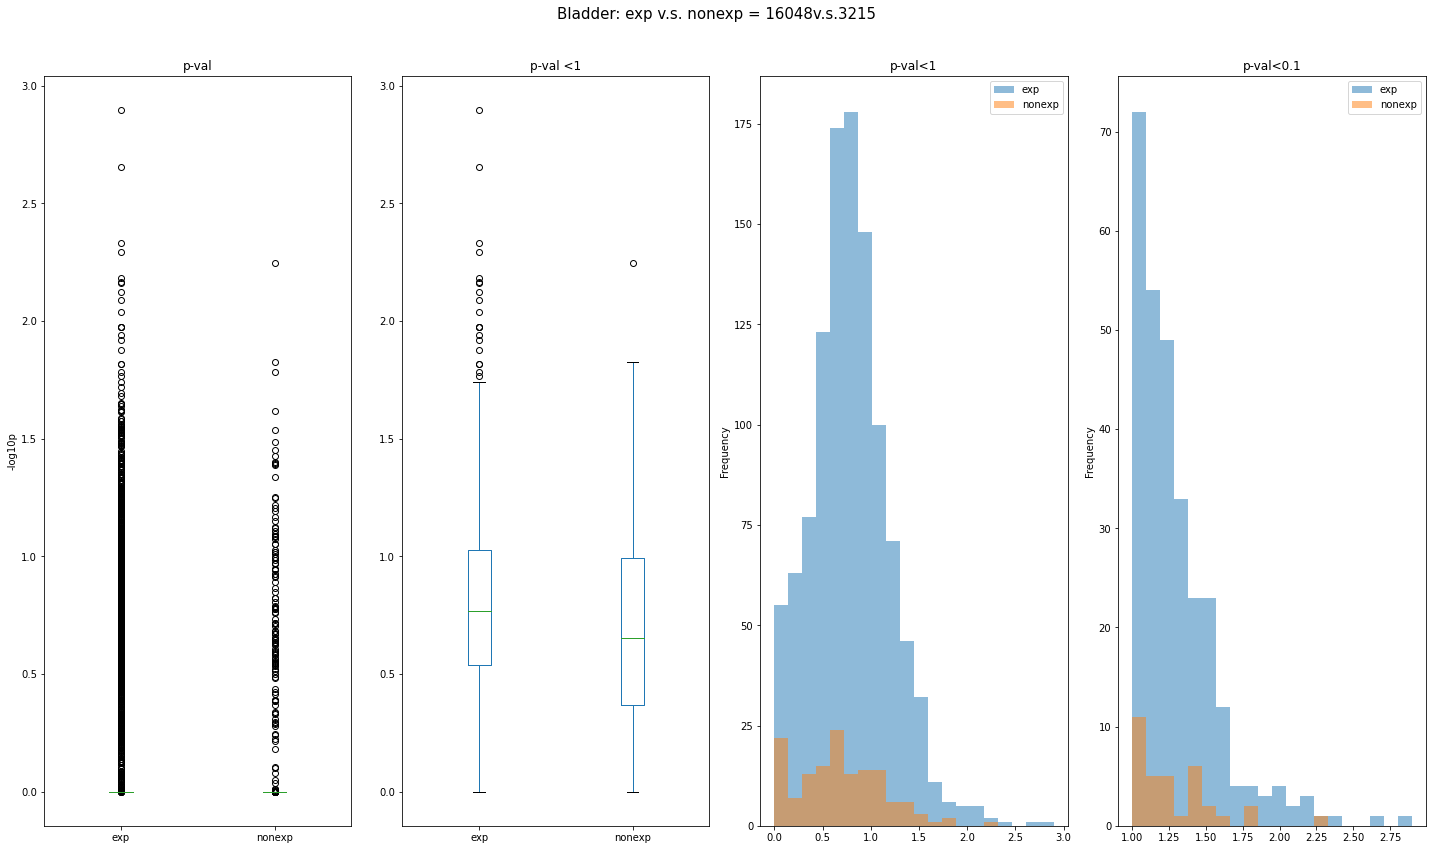

In [45]:
### Then map the p-vals in the sig gene files (all gene)
syn_dir = '../mutsig_out/syn/out10212020'
pdf = matplotlib.backends.backend_pdf.PdfPages("output.pdf")

for org in listdir(syn_dir):
    if not org.startswith('.') and not org == 'SoftTissue':
        org_dir = join(syn_dir,org)
        for f in listdir(org_dir):
            if f.endswith('sig_genes.txt'):
                f_dir = join(org_dir,f)
                df_org = pd.read_csv(f_dir,sep = '\t')
                df_org.loc[df_org['p']==0, 'p'] = 1e-30
                
                df_org_1 = df_org[df_org['p']<1]
                df_org_05 = df_org[df_org['p']<0.1]
                
                df_exp_p = -np.log10(df_org[df_org['gene'].isin(df_exp_gene[org])]['p'])
                df_nonexp_p = -np.log10(df_org[df_org['gene'].isin(df_nonexp_gene[org])]['p'])
                
                df_exp_p_1 = -np.log10(df_org_1[df_org_1['gene'].isin(df_exp_gene[org])]['p'])
                df_nonexp_p_1 = -np.log10(df_org_1[df_org_1['gene'].isin(df_nonexp_gene[org])]['p'])
                df_exp_p_05 = -np.log10(df_org_05[df_org_05['gene'].isin(df_exp_gene[org])]['p'])
                df_nonexp_p_05 = -np.log10(df_org_05[df_org_05['gene'].isin(df_nonexp_gene[org])]['p'])
                

                df_p = pd.concat([df_exp_p,df_nonexp_p],ignore_index=True, axis=1 )
                df_p_1 = pd.concat([df_exp_p_1,df_nonexp_p_1],ignore_index=True, axis=1 )
                df_p_05 = pd.concat([df_exp_p_05,df_nonexp_p_05],ignore_index=True, axis=1 )
                df_p.columns = ['exp','nonexp']
                df_p_1.columns = ['exp','nonexp']
                df_p_05.columns = ['exp','nonexp']
                
                fig, axes = plt.subplots(nrows=1, ncols=4,figsize=(20,12))
                
                df_p.plot.box(ax = axes[0])
                axes[0].set(title = 'p-val', ylabel = '-log10p')
                df_p_1.plot.box(ax = axes[1])
                axes[1].set(title = 'p-val <1')

                df_p_1.plot.hist(alpha=0.5, bins = 20,ax = axes[2]);
                axes[2].set(title = 'p-val<1')
                df_p_05.plot.hist(alpha=0.5, bins = 20,ax = axes[3]);
                axes[3].set(title = 'p-val<0.1')

#                 df_p.plot.hist(alpha=0.5, bins = 20,ax = axes[1]);
#                 df = df_p.melt(var_name='groups', value_name='vals')
#                 sns.violinplot(x="groups", y="vals", data=df,ax = axes[2])
#                 axes[2].set(ylim=(0, 0.5))
#                 axes[2].set(title="Violinplot of p-val")
                
                plt.tight_layout()
                fig.suptitle(org + ': Tumor Specific exp v.s. nonexp = '+str(len(df_exp_gene[org].dropna())) + 'v.s.' + str(len(df_nonexp_gene[org].dropna())),fontsize =15)
                fig.subplots_adjust(top=0.9)
                pdf.savefig( fig )
pdf.close()